In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_csv_in_chunks(file_path, chunk_size=50000):
    dfs = []
    for chunk in pd.read_csv(file_path, compression='gzip', chunksize=chunk_size):
        dfs.append(chunk)
    return pd.concat(dfs, ignore_index=True)

file_path = '/work/JinStorage/Hyponatremia/MIMIC_4/physionet.org/files/mimiciv/2.2/hosp/diagnoses_icd.csv.gz'
diagnoses = read_csv_in_chunks(file_path)

In [2]:
diagnoses.head()

subject_id   hadm_id  seq_num icd_code  icd_version
0    10000032  22595853        1     5723            9
1    10000032  22595853        2    78959            9
2    10000032  22595853        3     5715            9
3    10000032  22595853        4    07070            9
4    10000032  22595853        5      496            9

In [3]:
hyponatremia_diag = diagnoses[(diagnoses['icd_code'].isin(['2761', 'E871', 'P7422']))]

In [4]:
# Group by subject_id and hadm_id to find unique pairs
unique_pairs = hyponatremia_diag.groupby(['subject_id', 'hadm_id']).size().reset_index(name='count')

number_of_unique_pairs = len(unique_pairs)

print("Number of unique subject_id and hadm_id pairs:", number_of_unique_pairs)
print(unique_pairs)

Number of unique subject_id and hadm_id pairs: 21041
       subject_id   hadm_id  count
0        10000032  22841357      1
1        10000032  25742920      1
2        10000032  29079034      1
3        10000826  20032235      1
4        10000826  21086876      1
...           ...       ...    ...
21036    19998591  24349193      1
21037    19998878  21643535      1
21038    19998878  26489544      1
21039    19999204  29046609      1
21040    19999297  21439025      1

[21041 rows x 3 columns]


In [5]:
# Get unique subject_ids from the unique_pairs DataFrame
unique_subject_ids = unique_pairs['subject_id'].unique()

# Count the number of unique subject_ids
number_of_unique_subject_ids = len(unique_subject_ids)

print("Number of unique subject_ids:", number_of_unique_subject_ids)
print(unique_subject_ids)

Number of unique subject_ids: 14593
[10000032 10000826 10001176 ... 19998878 19999204 19999297]


In [6]:
fp ='/work/JinStorage/Hyponatremia/MIMIC_4/physionet.org/files/mimiciv/2.2/hosp/labevents.csv.gz'
labevents = read_csv_in_chunks(fp)
labevents.head()

labevent_id  subject_id  hadm_id  specimen_id  itemid order_provider_id  \
0            1    10000032      NaN     45421181   51237            P28Z0X   
1            2    10000032      NaN     45421181   51274            P28Z0X   
2            3    10000032      NaN     52958335   50853            P28Z0X   
3            4    10000032      NaN     52958335   50861            P28Z0X   
4            5    10000032      NaN     52958335   50862            P28Z0X   

             charttime            storetime value  valuenum valueuom  \
0  2180-03-23 11:51:00  2180-03-23 15:15:00   1.4       1.4      NaN   
1  2180-03-23 11:51:00  2180-03-23 15:15:00   ___      15.1      sec   
2  2180-03-23 11:51:00  2180-03-25 11:06:00   ___      15.0    ng/mL   
3  2180-03-23 11:51:00  2180-03-23 16:40:00   102     102.0     IU/L   
4  2180-03-23 11:51:00  2180-03-23 16:40:00   3.3       3.3     g/dL   

   ref_range_lower  ref_range_upper      flag priority  \
0              0.9              1.1  abnormal  ROUTINE   
1              9.4             12.5  abnormal  ROUTINE   
2             30.0             60.0  abnormal  ROUTINE   
3              0.0             40.0  abnormal  ROUTINE   
4              3.5              5.2  abnormal  ROUTINE   

                                            comments  
0                                                NaN  
1                                          VERIFIED.  
2  NEW ASSAY IN USE ___: DETECTS D2 AND D3 25-OH ...  
3                                                NaN  
4                                                NaN

In [7]:
# Perform an inner merge to find matching pairs in labevents
matching_pairs = pd.merge(unique_pairs[['subject_id', 'hadm_id']], labevents[['subject_id', 'hadm_id']], on=['subject_id', 'hadm_id'], how='inner').drop_duplicates()

# Count the unique pairs
count_matching_pairs = len(matching_pairs)

print("Count of unique subject_id and hadm_id pairs that exist in both DataFrames:", count_matching_pairs)

Count of unique subject_id and hadm_id pairs that exist in both DataFrames: 20742


In [8]:
# Merge matching_pairs with labevents to get relevant lab events
relevant_labevents = pd.merge(matching_pairs, labevents, on=['subject_id', 'hadm_id'], how='inner')

# Count the occurrences of each item_id in the relevant lab events
item_id_counts = relevant_labevents['itemid'].value_counts()

# Display the most common item_ids and their counts
print("Most common item_ids in labevents for matching pairs:")
print(item_id_counts.head(30))  

Most common item_ids in labevents for matching pairs:
itemid
50983    257390
50971    256090
50902    252856
50912    246390
51006    245395
50882    245352
50868    244860
50931    242002
50960    228742
51221    226327
50970    218515
51265    218388
50893    217626
51222    216242
51301    214409
51249    214053
51248    214040
51279    214040
51250    214040
51277    214030
51275    131580
51237    126097
51274    126096
50934    116545
51678    116543
50947    116540
52172    114150
50885     87571
50861     87010
50878     86995
Name: count, dtype: int64


In [9]:
fp = '/work/JinStorage/Hyponatremia/MIMIC_4/physionet.org/files/mimiciv/2.2/hosp/d_labitems.csv.gz'
d_labitems = read_csv_in_chunks(fp)

In [10]:
# Get the most common item_ids as a list
most_common_item_ids = item_id_counts.head(50).index.tolist()

# Filter d_labitems to only include rows with the most common item_ids
common_d_labitems = d_labitems[d_labitems['itemid'].isin(most_common_item_ids)]

print("Rows in d_labitems for the most common item_ids:")
print(common_d_labitems)

Rows in d_labitems for the most common item_ids:
      itemid                            label  fluid    category
1      50802                      Base Excess  Blood   Blood Gas
3      50804             Calculated Total CO2  Blood   Blood Gas
6      50808                     Free Calcium  Blood   Blood Gas
11     50813                          Lactate  Blood   Blood Gas
15     50817                Oxygen Saturation  Blood   Blood Gas
16     50818                             pCO2  Blood   Blood Gas
18     50820                               pH  Blood   Blood Gas
19     50821                              pO2  Blood   Blood Gas
59     50861   Alanine Aminotransferase (ALT)  Blood   Chemistry
60     50862                          Albumin  Blood   Chemistry
61     50863             Alkaline Phosphatase  Blood   Chemistry
66     50868                        Anion Gap  Blood   Chemistry
76     50878  Asparate Aminotransferase (AST)  Blood   Chemistry
80     50882                      Bicarbo

In [11]:
# Filter labevents for matching pairs that have item_id 51108 or 51109 (Urine Volume)
UV_labevents = labevents[(labevents['itemid'] == 51108) | (labevents['itemid'] == 51109)]

# Perform an inner merge with matching_pairs to ensure we only consider those pairs
matching_labevents = pd.merge(matching_pairs[['subject_id', 'hadm_id']], UV_labevents, on=['subject_id', 'hadm_id'], how='inner')

# Count occurrences of item_id 51108 and 51109 for each pair
item_id_counts_per_pair = matching_labevents.groupby(['subject_id', 'hadm_id', 'itemid']).size().reset_index(name='count')

# Calculate the total counts of 51108 and 51109 per pair (irrespective of item_id)
total_counts_per_pair = item_id_counts_per_pair.groupby(['subject_id', 'hadm_id'])['count'].sum().reset_index(name='total_count')

pairs_with_occurrence_UV = total_counts_per_pair[['subject_id', 'hadm_id']]

# Calculate the average occurrence of these item_ids across pairs that had at least one occurrence
average_occurrence = total_counts_per_pair['total_count'].mean()

#  Count how many unique pairs had these occurrences
number_of_pairs_with_UV_occurrence = len(pairs_with_occurrence_UV)

print(f"Number of pairs that had at least one occurrence of itemids 51108 or 51109: {number_of_pairs_with_UV_occurrence}")
print(f"Average occurrence of itemids 51108 and/or 51109 (Urine Volume) for pairs that had at least one occurrence: {average_occurrence}")

Number of pairs that had at least one occurrence of itemids 51108 or 51109: 261
Average occurrence of itemids 51108 and/or 51109 (Urine Volume) for pairs that had at least one occurrence: 1.3371647509578544


In [12]:
# Filter labevents for matching pairs that have item_id 50983, 52623, 50824, or 52455 (Serum Sodium)
Sena_labevents = labevents[(labevents['itemid'].isin([50983, 52623, 50824, 52455]))]

# Perform an inner merge with matching_pairs to ensure we only consider those pairs
matching_sena_labevents = pd.merge(matching_pairs[['subject_id', 'hadm_id']], Sena_labevents, on=['subject_id', 'hadm_id'], how='inner')

# Count occurrences of item_id 50983, 52623, 50824, and 52455 for each pair
Sena_item_id_counts_per_pair = matching_sena_labevents.groupby(['subject_id', 'hadm_id', 'itemid']).size().reset_index(name='count')

# Calculate the total counts of these item_ids per pair (irrespective of item_id)
total_sena_counts_per_pair = Sena_item_id_counts_per_pair.groupby(['subject_id', 'hadm_id'])['count'].sum().reset_index(name='total_count')

# Calculate the average occurrence of these item_ids across pairs that had at least one occurrence
average_sena_occurrence = total_sena_counts_per_pair['total_count'].mean()

# Store the pairs which had at least one occurrence
pairs_with_Sena_occurrence = total_sena_counts_per_pair[['subject_id', 'hadm_id']]

# Count how many such pairs
number_of_pairs_with_Sena_occurrence = len(pairs_with_Sena_occurrence)

print(f"Average occurrence of item_ids 50983, 52623, 50824, and 52455 for pairs that had at least one occurrence: {average_sena_occurrence}")
print(f"Number of pairs with at least one occurrence of the specified item_ids: {number_of_pairs_with_Sena_occurrence}")

Average occurrence of item_ids 50983, 52623, 50824, and 52455 for pairs that had at least one occurrence: 13.010727228799228
Number of pairs with at least one occurrence of the specified item_ids: 20695


In [13]:
# Ensure charttime is a datetime object
Sena_labevents['charttime'] = pd.to_datetime(Sena_labevents['charttime'])

# Sort by subject_id, hadm_id, and charttime to ensure chronological order
Sena_labevents_sorted = Sena_labevents.sort_values(['subject_id', 'hadm_id', 'charttime'])

# Calculate time differences within each pair
Sena_labevents_sorted['time_diff'] = Sena_labevents_sorted.groupby(['subject_id', 'hadm_id'])['charttime'].diff()

# Drop the NaN values that result from diff() as the first entry of each group will always be NaN
Sena_labevents_sorted = Sena_labevents_sorted.dropna(subset=['time_diff'])

# Convert time differences to a suitable unit (e.g., hours)
Sena_labevents_sorted['time_diff_hours'] = Sena_labevents_sorted['time_diff'].dt.total_seconds() / 3600

# Calculate the average time difference for each pair
average_time_diff_per_pair = Sena_labevents_sorted.groupby(['subject_id', 'hadm_id'])['time_diff_hours'].mean().reset_index(name='average_time_diff')

# Calculate the overall average time difference
overall_average_time_diff = average_time_diff_per_pair['average_time_diff'].mean()

# Count the number of Serum Sodium recordings for each pair
recordings_count_per_pair = Sena_labevents.groupby(['subject_id', 'hadm_id']).size().reset_index(name='recordings_count')

# Calculate the average number of recordings across all pairs
overall_recordings_count = recordings_count_per_pair['recordings_count'].mean()

print(f"Average number of Serum Sodium recordings for all pairs: {overall_recordings_count}")
print(f"Overall average time difference between Serum Sodium recordings: {overall_average_time_diff} hours")

/tmp/ipykernel_72000/398909133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sena_labevents['charttime'] = pd.to_datetime(Sena_labevents['charttime'])


Average number of Serum Sodium recordings for all pairs: 6.264908646282768
Overall average time difference between Serum Sodium recordings: 21.797590650023285 hours


In [14]:
# Filter for occurrences where Serum Sodium is less than 120
low_valuenum_events = Sena_labevents[Sena_labevents['valuenum'] < 120]

# Identify and store unique pairs of subject_id and hadm_id with at least one low valuenum occurrence
unique_pairs_low_valuenum = low_valuenum_events[['subject_id', 'hadm_id']].drop_duplicates()

# Count these pairs
count_of_pairs_with_low_valuenum = len(unique_pairs_low_valuenum)

print(f"Count of pairs with at least one Serum Sodium < 120 occurrence: {count_of_pairs_with_low_valuenum}")

Count of pairs with at least one Serum Sodium < 120 occurrence: 2429


In [15]:
# Remove rows with NaN values from unique_pairs_low_valuenum
unique_pairs_low_valuenum = unique_pairs_low_valuenum.dropna()

count_of_pairs_with_low_valuenum = len(unique_pairs_low_valuenum)

print(f"Count of pairs with at least one Serum Sodium < 120 occurrence after removing missing pairs: {count_of_pairs_with_low_valuenum}")

Count of pairs with at least one Serum Sodium < 120 occurrence after removing missing pairs: 1554


In [16]:
# Perform an inner join to filter labevents for those rows that match the unique_pairs_low_valuenum
filtered_labevents_severe_hyponatremia = pd.merge(labevents, unique_pairs_low_valuenum, on=['subject_id', 'hadm_id'], how='inner')

In [17]:
# Count the occurrences of each item_id in the labevents for patients with severe hyponatremia
item_id_counts_sh = filtered_labevents_severe_hyponatremia['itemid'].value_counts()

# Display the most common item_ids and their counts
print("Most common item_ids in labevents for patients with severe hyponatremia:")
print(item_id_counts_sh.head(30)) 

Most common item_ids in labevents for patients with severe hyponatremia:
itemid
50983    37530
50971    36259
50902    35742
50882    33429
50912    33419
50868    33316
51006    33260
50931    32935
50960    31007
50970    29737
50893    29524
51221    27628
51265    26447
51222    26130
51301    25887
51277    25825
51248    25825
51279    25825
51250    25825
51249    25825
51275    16992
51274    15931
51237    15931
50934    15598
50947    15598
51678    15598
52033    15515
52172    13056
50820    12899
50821    11411
Name: count, dtype: int64


In [18]:
# Get the most common item_ids as a list
most_common_item_ids_sh = item_id_counts_sh.head(50).index.tolist()

# Filter d_labitems to only include rows with the most common item_ids
common_d_labitems_sh = d_labitems[d_labitems['itemid'].isin(most_common_item_ids_sh)]

print("Rows in d_labitems for the most common item_ids for patients with severe hyponatremia:")
print(common_d_labitems_sh)

Rows in d_labitems for the most common item_ids for patients with severe hyponatremia:
      itemid                            label  fluid    category
1      50802                      Base Excess  Blood   Blood Gas
3      50804             Calculated Total CO2  Blood   Blood Gas
6      50808                     Free Calcium  Blood   Blood Gas
11     50813                          Lactate  Blood   Blood Gas
15     50817                Oxygen Saturation  Blood   Blood Gas
16     50818                             pCO2  Blood   Blood Gas
18     50820                               pH  Blood   Blood Gas
19     50821                              pO2  Blood   Blood Gas
20     50822           Potassium, Whole Blood  Blood   Blood Gas
22     50824              Sodium, Whole Blood  Blood   Blood Gas
59     50861   Alanine Aminotransferase (ALT)  Blood   Chemistry
60     50862                          Albumin  Blood   Chemistry
61     50863             Alkaline Phosphatase  Blood   Chemistry
66 

In [19]:
# Merge to get all Serum Sodium recordings for pairs with at least one valuenum < 120
Sena_labevents_for_low_valuenum_pairs = pd.merge(unique_pairs_low_valuenum, Sena_labevents, on=['subject_id', 'hadm_id'], how='inner')

# Ensure charttime is in datetime format
Sena_labevents_for_low_valuenum_pairs['charttime'] = pd.to_datetime(Sena_labevents_for_low_valuenum_pairs['charttime'])

# Sort by subject_id, hadm_id, and charttime
Sena_labevents_for_low_valuenum_pairs_sorted = Sena_labevents_for_low_valuenum_pairs.sort_values(['subject_id', 'hadm_id', 'charttime'])

# Calculate time differences within each pair
Sena_labevents_for_low_valuenum_pairs_sorted['time_diff'] = Sena_labevents_for_low_valuenum_pairs_sorted.groupby(['subject_id', 'hadm_id'])['charttime'].diff()

# Drop the NaN values
Sena_labevents_for_low_valuenum_pairs_sorted = Sena_labevents_for_low_valuenum_pairs_sorted.dropna(subset=['time_diff'])

# Convert time differences to a suitable unit (e.g., hours)
Sena_labevents_for_low_valuenum_pairs_sorted['time_diff_hours'] = Sena_labevents_for_low_valuenum_pairs_sorted['time_diff'].dt.total_seconds() / 3600

# Calculate the average time difference for these pairs
average_time_diff_per_low_valuenum_pair = Sena_labevents_for_low_valuenum_pairs_sorted.groupby(['subject_id', 'hadm_id'])['time_diff_hours'].mean().reset_index(name='average_time_diff')

# Calculate the overall average time difference
overall_average_time_diff_low_valuenum = average_time_diff_per_low_valuenum_pair['average_time_diff'].mean()

# Count the number of Serum Sodium recordings for each pair
recordings_count_per_low_valuenum_pair = Sena_labevents_for_low_valuenum_pairs.groupby(['subject_id', 'hadm_id']).size().reset_index(name='recordings_count')

# Calculate the overall number of recordings for these pairs
overall_recordings_count = recordings_count_per_low_valuenum_pair['recordings_count'].mean()

print(f"Overall average time difference between Serum Sodium recordings for pairs with Serum Sodium < 120: {overall_average_time_diff_low_valuenum} hours")
print(f"Average number of Serum Sodium recordings for pairs with Serum Sodium < 120: {overall_recordings_count}")

Overall average time difference between Serum Sodium recordings for pairs with Serum Sodium < 120: 11.524413485862814 hours
Average number of Serum Sodium recordings for pairs with Serum Sodium < 120: 28.35006435006435


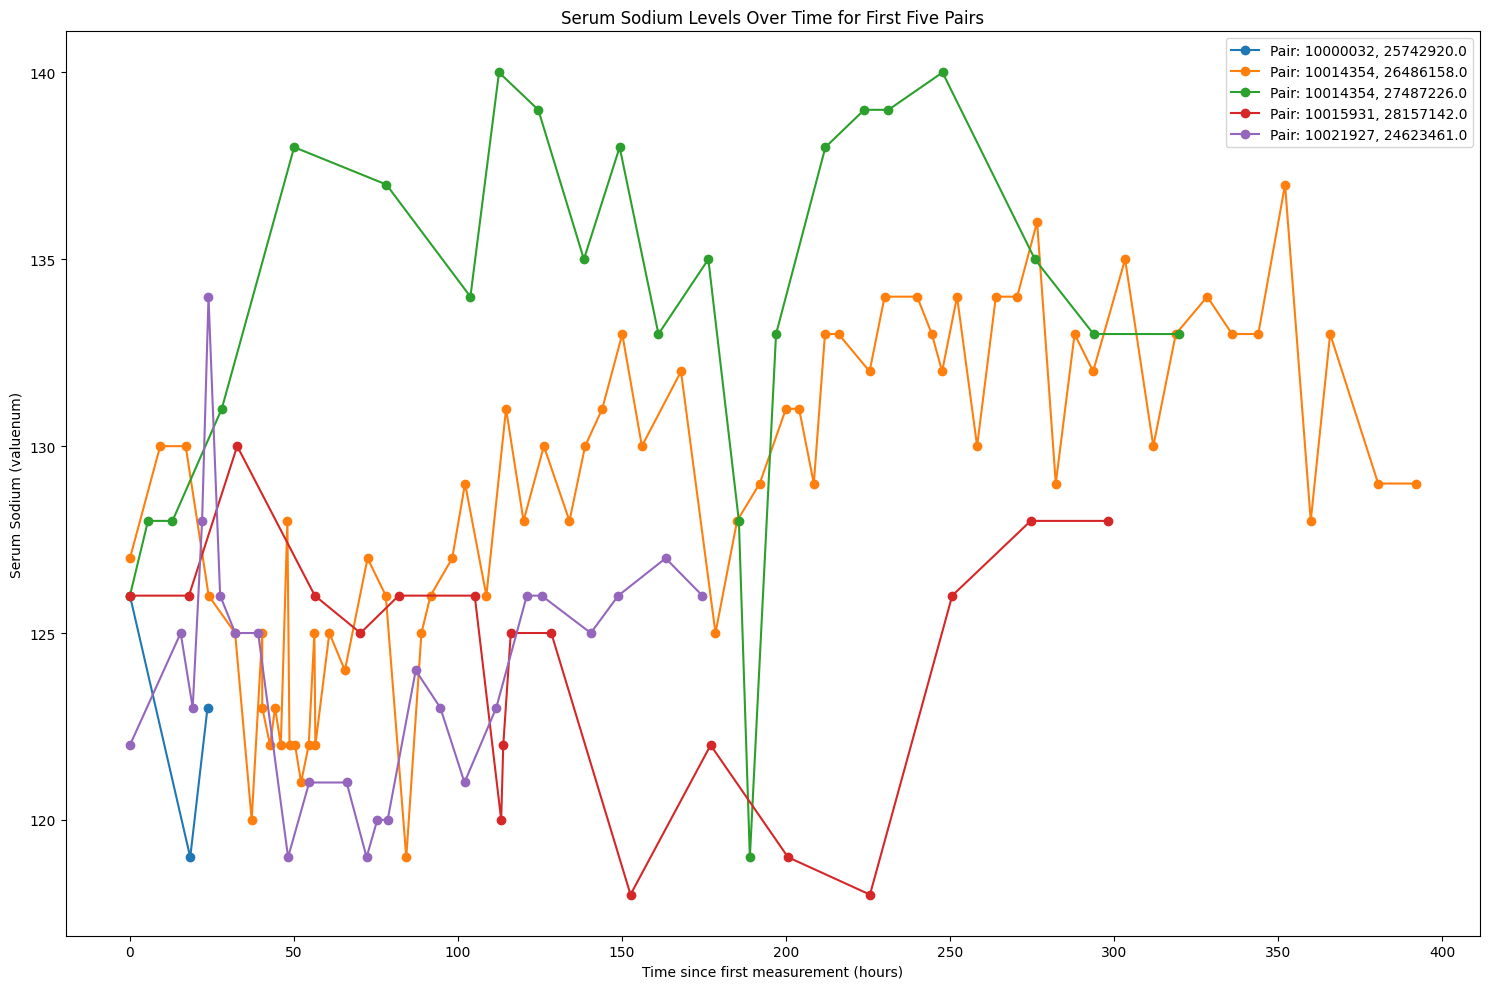

In [20]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Group by subject_id and hadm_id
grouped = Sena_labevents_for_low_valuenum_pairs.groupby(['subject_id', 'hadm_id'])

# Initialize a counter to only plot the first five pairs
counter = 0

# Set up the figure for plotting
plt.figure(figsize=(15, 10))

for (subject_id, hadm_id), group in grouped:
    if counter < 5:  
        # Normalize time by subtracting the minimum charttime in the group from all charttimes in the group
        group['normalized_time'] = group['charttime'] - group['charttime'].min()
        
        # Convert normalized_time to hours
        group['normalized_hours'] = group['normalized_time'].dt.total_seconds() / 3600

        # Plotting
        plt.plot(group['normalized_hours'], group['valuenum'], marker='o', linestyle='-', label=f'Pair: {subject_id}, {hadm_id}')
        plt.legend()
        plt.xlabel('Time since first measurement (hours)')
        plt.ylabel('Serum Sodium (valuenum)')
        plt.title('Serum Sodium Levels Over Time for First Five Pairs')
    else:
        break  
    counter += 1

plt.tight_layout()  
plt.show()

In [21]:
# Assuming item_id_counts_sh holds the count of occurrences for each item_id
top_30_item_ids = item_id_counts_sh.head(30).index.tolist()

# Add additional item_ids to the list (included urine osmolality, urine sodium, urine potassium)
additional_item_ids = [50824, 52623,51093, 51100, 51017]
all_relevant_item_ids = top_30_item_ids + additional_item_ids

# Ensure the list is unique in case 50824 or 52623 are already in the top 30
all_relevant_item_ids = list(set(all_relevant_item_ids))

In [22]:
all_relevant_item_ids

[50947,
 50820,
 50821,
 50824,
 52623,
 50960,
 51221,
 51222,
 51093,
 50970,
 50971,
 51100,
 51237,
 50983,
 51248,
 51249,
 51250,
 50868,
 51006,
 51265,
 50882,
 52033,
 51017,
 51274,
 51275,
 52172,
 50893,
 51277,
 51279,
 50902,
 51678,
 50912,
 51301,
 50931,
 50934]

In [23]:
fp = '/work/JinStorage/Hyponatremia/MIMIC_4/physionet.org/files/mimiciv/2.2/hosp/prescriptions.csv.gz'
prescriptions = read_csv_in_chunks(fp)

/tmp/ipykernel_72000/3235212656.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, compression='gzip', chunksize=chunk_size):
/tmp/ipykernel_72000/3235212656.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, compression='gzip', chunksize=chunk_size):
/tmp/ipykernel_72000/3235212656.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, compression='gzip', chunksize=chunk_size):
/tmp/ipykernel_72000/3235212656.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, compression='gzip', chunksize=chunk_size):
/tmp/ipykernel_72000/3235212656.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set

In [24]:
# Filter each DataFrame to keep only the rows with subject_id and hadm_id in unique_pairs_low_valuenum
lab_events_filtered = labevents.merge(unique_pairs_low_valuenum, on=['subject_id', 'hadm_id'])
diagnoses_filtered = diagnoses.merge(unique_pairs_low_valuenum, on=['subject_id', 'hadm_id'])
prescriptions_filtered = prescriptions.merge(unique_pairs_low_valuenum, on=['subject_id', 'hadm_id'])

In [25]:
lab_events_filtered = lab_events_filtered[['subject_id', 'hadm_id', 'itemid', 'charttime', 'valuenum']]
diagnoses_filtered = diagnoses_filtered[['subject_id', 'hadm_id', 'icd_code', 'icd_version']]
prescriptions_filtered = prescriptions_filtered[['subject_id', 'hadm_id', 'starttime', 'stoptime', 'drug', 'drug_type', 'ndc', 'dose_val_rx', 'dose_unit_rx', 'form_val_disp', 'form_unit_disp', 'doses_per_24_hrs', 'route']]

In [26]:
print("Shape of lab_events_filtered:", lab_events_filtered.shape)
print("Shape of diagnoses_filtered:", diagnoses_filtered.shape)
print("Shape of prescriptions_filtered:", prescriptions_filtered.shape)

Shape of lab_events_filtered: (1064912, 5)
Shape of diagnoses_filtered: (30321, 4)
Shape of prescriptions_filtered: (186991, 13)


In [27]:
prescriptions_filtered = prescriptions_filtered.dropna(subset=['ndc', 'starttime', 'stoptime', 'route'])

In [28]:
print("Missing values in lab_events_filtered:")
print(lab_events_filtered.isna().sum())

print("\nMissing values in diagnoses_filtered:")
print(diagnoses_filtered.isna().sum())

print("\nMissing values in prescriptions_filtered:")
print(prescriptions_filtered.isna().sum())

Missing values in lab_events_filtered:
subject_id        0
hadm_id           0
itemid            0
charttime         0
valuenum      95379
dtype: int64

Missing values in diagnoses_filtered:
subject_id     0
hadm_id        0
icd_code       0
icd_version    0
dtype: int64

Missing values in prescriptions_filtered:
subject_id              0
hadm_id                 0
starttime               0
stoptime                0
drug                    0
drug_type               0
ndc                     0
dose_val_rx             0
dose_unit_rx            0
form_val_disp           0
form_unit_disp          0
doses_per_24_hrs    73780
route                   0
dtype: int64


In [29]:
print("Unique values in lab_events_filtered:")
print(lab_events_filtered.nunique())

print("\nUnique values in diagnoses_filtered:")
print(diagnoses_filtered.nunique())

print("\nUnique values in prescriptions_filtered:")
print(prescriptions_filtered.nunique())

Unique values in lab_events_filtered:
subject_id     1431
hadm_id        1554
itemid          700
charttime     74280
valuenum       6112
dtype: int64

Unique values in diagnoses_filtered:
subject_id     1431
hadm_id        1554
icd_code       4097
icd_version       2
dtype: int64

Unique values in prescriptions_filtered:
subject_id           1430
hadm_id              1553
starttime           75629
stoptime            58836
drug                 1352
drug_type               3
ndc                  3037
dose_val_rx           601
dose_unit_rx           57
form_val_disp         725
form_unit_disp         49
doses_per_24_hrs       11
route                  62
dtype: int64


In [31]:
print("Data types and info for lab_events_filtered:")
lab_events_filtered.info()

print("\nData types and info for diagnoses_filtered:")
diagnoses_filtered.info()

print("\nData types and info for prescriptions_filtered:")
prescriptions_filtered.info()

Data types and info for lab_events_filtered:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1064912 entries, 0 to 1064911
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   subject_id  1064912 non-null  int64  
 1   hadm_id     1064912 non-null  float64
 2   itemid      1064912 non-null  int64  
 3   charttime   1064912 non-null  object 
 4   valuenum    969533 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 40.6+ MB

Data types and info for diagnoses_filtered:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30321 entries, 0 to 30320
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subject_id   30321 non-null  int64 
 1   hadm_id      30321 non-null  int64 
 2   icd_code     30321 non-null  object
 3   icd_version  30321 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 947.7+ KB

Data types and info for pre

In [32]:
lab_events_filtered['charttime'] = pd.to_datetime(lab_events_filtered['charttime'])

In [33]:
# Group by 'subject_id', 'hadm_id', and 'itemid', then calculate the time since the first 'charttime' in each group
lab_events_filtered['time_since_reference'] = lab_events_filtered.groupby(['subject_id', 'hadm_id', 'itemid'])['charttime'].transform(lambda x: (x - x.min()).dt.total_seconds())

In [34]:
train_data = lab_events_filtered.dropna(subset=['valuenum'])
predict_data = lab_events_filtered[lab_events_filtered['valuenum'].isna()]
# Drop 'charttime' column from both datasets
train_data = train_data.drop(columns=['charttime'])
predict_data = predict_data.drop(columns=['charttime'])

In [35]:
import xgboost as xgb
# 'valuenum' is the target and other columns are features
X_train = train_data.drop(['valuenum'], axis=1)
y_train = train_data['valuenum']
X_predict = predict_data.drop(['valuenum'], axis=1)

# Initialize and train the XGBoost model
xgbmodel = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgbmodel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [36]:
predicted_valuenum = xgbmodel.predict(X_predict)

In [37]:
lab_events_filtered.loc[lab_events_filtered['valuenum'].isna(), 'valuenum'] = predicted_valuenum

In [38]:
print(lab_events_filtered.isna().sum())

subject_id              0
hadm_id                 0
itemid                  0
charttime               0
valuenum                0
time_since_reference    0
dtype: int64


In [39]:
unique_ndc_drug_pairs = prescriptions_filtered[['ndc', 'drug']].drop_duplicates()
display(unique_ndc_drug_pairs)

ndc                        drug
0       6.746706e+10  Albumin 25% (12.5g / 50mL)
1       6.655300e+10           Calcium Carbonate
2       4.094902e+08                Dextrose 50%
3       1.730682e+08           Albuterol Inhaler
4       5.107901e+10                  Furosemide
...              ...                         ...
186300  5.107902e+10                Voriconazole
186333  6.131403e+10             Filgrastim-sndz
186527  2.282631e+08      Isosorbide Mononitrate
186735  1.210544e+08                     Docusat
186763  9.042245e+08                     Docusat

[3671 rows x 2 columns]

In [40]:
# Group by 'drug' and count unique 'ndc' values for each drug
drug_ndc_counts = unique_ndc_drug_pairs.groupby('drug')['ndc'].nunique()

# Filter to get drugs with more than one unique 'ndc'
drugs_with_multiple_ndc = drug_ndc_counts[drug_ndc_counts > 1]

# Display the results
print(drugs_with_multiple_ndc)


drug
0.45% Sodium Chloride                2
0.9% NaCl (EXCEL/ViaFLO BAG)         2
0.9% Sodium Chloride                11
0.9% Sodium Chloride (EXCEL BAG)     2
1/2 NS                               3
                                    ..
rocuronium                           2
sevelamer CARBONATE                  4
sevelamer HYDROCHLORIDE              2
sodium chloride                      2
traZODONE                            2
Name: ndc, Length: 703, dtype: int64


In [41]:
prescriptions_filtered['starttime'] = pd.to_datetime(prescriptions_filtered['starttime'])
prescriptions_filtered['stoptime'] = pd.to_datetime(prescriptions_filtered['stoptime'])

# Calculate the duration within each group
duration_per_group = prescriptions_filtered.groupby(['ndc', 'subject_id', 'hadm_id']).apply(
    lambda group: (group['stoptime'] - group['starttime']).dt.total_seconds()
).reset_index(name='duration')

# Merge the calculated duration back into the original DataFrame
prescriptions_filtered = prescriptions_filtered.merge(duration_per_group, on=['ndc', 'subject_id', 'hadm_id'], how='left')

/tmp/ipykernel_72000/2403041842.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  duration_per_group = prescriptions_filtered.groupby(['ndc', 'subject_id', 'hadm_id']).apply(


In [42]:
print(prescriptions_filtered.dtypes)

subject_id                   int64
hadm_id                      int64
starttime           datetime64[ns]
stoptime            datetime64[ns]
drug                        object
drug_type                   object
ndc                        float64
dose_val_rx                 object
dose_unit_rx                object
form_val_disp               object
form_unit_disp              object
doses_per_24_hrs           float64
route                       object
level_3                      int64
duration                   float64
dtype: object


In [43]:
from sklearn.preprocessing import LabelEncoder

# Creating a copy to avoid changing the original DataFrame
df_processed = prescriptions_filtered.copy()

# Exclude 'starttime' and 'stoptime' from the dataset
df_processed = df_processed.drop(columns=['starttime', 'stoptime'])

# List of columns to encode
categorical_columns = ['drug', 'drug_type', 'dose_val_rx', 'dose_unit_rx', 'form_val_disp', 'form_unit_disp', 'route']

# Apply Label Encoding for simplicity in this example
for col in categorical_columns:
    le = LabelEncoder()
    # Fit and transform the data and replace NaN with -1 after converting to string
    df_processed[col] = le.fit_transform(df_processed[col].fillna('NaN').astype(str))

# Convert 'ndc' to a categorical variable for simplicity
df_processed['ndc'] = LabelEncoder().fit_transform(df_processed['ndc'].fillna(-1).astype(str))

# Prepare training data: exclude rows with missing 'doses_per_24_hrs'
train_data = df_processed.dropna(subset=['doses_per_24_hrs'])

# Prepare prediction data: include only rows with missing 'doses_per_24_hrs'
predict_data = df_processed[df_processed['doses_per_24_hrs'].isna()]

In [44]:
# Prepare training data
X_train = train_data.drop('doses_per_24_hrs', axis=1)
y_train = train_data['doses_per_24_hrs']

# Train the model
xgbmodel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [45]:
# Prepare prediction data
X_predict = predict_data.drop('doses_per_24_hrs', axis=1)

# Predict missing 'doses_per_24_hrs' values
predicted_doses = xgbmodel.predict(X_predict)

# Fill in the missing 'doses_per_24_hrs' values in the original DataFrame
prescriptions_filtered.loc[prescriptions_filtered['doses_per_24_hrs'].isna(), 'doses_per_24_hrs'] = predicted_doses

In [46]:
print(prescriptions_filtered.isna().sum())

subject_id          0
hadm_id             0
starttime           0
stoptime            0
drug                0
drug_type           0
ndc                 0
dose_val_rx         0
dose_unit_rx        0
form_val_disp       0
form_unit_disp      0
doses_per_24_hrs    0
route               0
level_3             0
duration            0
dtype: int64


In [47]:
prescriptions_filtered.head()

subject_id   hadm_id           starttime            stoptime  \
0    10000032  25742920 2180-08-06 17:00:00 2180-08-06 19:00:00   
1    10000032  25742920 2180-08-06 03:00:00 2180-08-07 22:00:00   
2    10000032  25742920 2180-08-06 09:00:00 2180-08-06 11:00:00   
3    10000032  25742920 2180-08-06 09:00:00 2180-08-06 11:00:00   
4    10000032  25742920 2180-08-06 03:00:00 2180-08-07 22:00:00   

                         drug drug_type           ndc dose_val_rx  \
0  Albumin 25% (12.5g / 50mL)      MAIN  6.746706e+10          25   
1           Calcium Carbonate      MAIN  6.655300e+10         500   
2                Dextrose 50%      MAIN  4.094902e+08          25   
3                Dextrose 50%      MAIN  4.094902e+08          25   
4           Albuterol Inhaler      MAIN  1.730682e+08           2   

  dose_unit_rx form_val_disp form_unit_disp  doses_per_24_hrs  route  level_3  \
0            g             1            BAG          1.000000     IV        0   
1           mg             1            TAB          2.000000  PO/NG        1   
2           gm             1            SYR          1.000000     IV        2   
3           gm             1            SYR          1.000000     IV        5   
4         PUFF          0.02            INH          4.812078     IH        3   

   duration  
0    7200.0  
1  154800.0  
2    7200.0  
3    7200.0  
4  154800.0

In [48]:
lab_events_filtered.head()

subject_id     hadm_id  itemid           charttime  valuenum  \
0    10000032  25742920.0   51221 2180-08-06 06:36:00      34.6   
1    10000032  25742920.0   51222 2180-08-06 06:36:00      12.1   
2    10000032  25742920.0   51248 2180-08-06 06:36:00      35.9   
3    10000032  25742920.0   51249 2180-08-06 06:36:00      34.8   
4    10000032  25742920.0   51250 2180-08-06 06:36:00     103.0   

   time_since_reference  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [49]:
file_path = '/work/JinStorage/Hyponatremia/MIMIC_4/physionet.org/files/mimiciv/2.2/hosp/patients.csv.gz'
patients = read_csv_in_chunks(file_path)
patients.head()

subject_id gender  anchor_age  anchor_year anchor_year_group         dod
0    10000032      F          52         2180       2014 - 2016  2180-09-09
1    10000048      F          23         2126       2008 - 2010         NaN
2    10000068      F          19         2160       2008 - 2010         NaN
3    10000084      M          72         2160       2017 - 2019  2161-02-13
4    10000102      F          27         2136       2008 - 2010         NaN

In [50]:
# Merge diagnoses_filtered with a subset of patients containing only subject_id, gender, and anchor_age
diagnoses_filtered = pd.merge(diagnoses_filtered,
                              patients[['subject_id', 'gender', 'anchor_age']],
                              on='subject_id',
                              how='inner')

diagnoses_filtered = diagnoses_filtered.rename(columns={'anchor_age': 'age'})

In [51]:
file_path = '/work/JinStorage/Hyponatremia/MIMIC_4/physionet.org/files/mimiciv/2.2/hosp/omr.csv.gz'
omr = read_csv_in_chunks(file_path)
omr.head(40)

subject_id   chartdate  seq_num      result_name result_value
0     10000032  2180-04-27        1   Blood Pressure       110/65
1     10000032  2180-04-27        1     Weight (Lbs)           94
2     10000032  2180-05-07        1      BMI (kg/m2)         18.0
3     10000032  2180-05-07        1  Height (Inches)           60
4     10000032  2180-05-07        1     Weight (Lbs)        92.15
5     10000032  2180-05-07        2     Weight (Lbs)        92.15
6     10000032  2180-05-07        3     Weight (Lbs)        92.15
7     10000032  2180-05-07        4     Weight (Lbs)        92.15
8     10000032  2180-05-07        5     Weight (Lbs)        92.15
9     10000032  2180-05-07        6     Weight (Lbs)        92.15
10    10000032  2180-05-07        7     Weight (Lbs)        92.15
11    10000032  2180-05-07        8     Weight (Lbs)        92.15
12    10000032  2180-05-07        9     Weight (Lbs)        92.15
13    10000032  2180-05-07       10     Weight (Lbs)        92.15
14    10000032  2180-05-07       11     Weight (Lbs)        92.15
15    10000032  2180-05-07       12     Weight (Lbs)        92.15
16    10000032  2180-05-07       13     Weight (Lbs)        92.15
17    10000032  2180-05-07       14     Weight (Lbs)        92.15
18    10000032  2180-05-07       15     Weight (Lbs)        92.15
19    10000032  2180-05-07       16     Weight (Lbs)        92.15
20    10000032  2180-05-07       17     Weight (Lbs)        92.15
21    10000032  2180-05-25        1   Blood Pressure       106/60
22    10000032  2180-05-25        1      BMI (kg/m2)         18.6
23    10000032  2180-05-25        1     Weight (Lbs)           95
24    10000032  2180-06-01        1   Blood Pressure       121/77
25    10000032  2180-06-01        1      BMI (kg/m2)         18.7
26    10000032  2180-06-01        1     Weight (Lbs)         95.7
27    10000032  2180-06-22        1   Blood Pressure       100/60
28    10000032  2180-06-22        1      BMI (kg/m2)         18.9
29    10000032  2180-06-22        1  Height (Inches)           60
30    10000032  2180-06-22        1     Weight (Lbs)           97
31    10000032  2180-06-27        1      BMI (kg/m2)         19.2
32    10000032  2180-06-27        1     Weight (Lbs)        98.32
33    10000032  2180-06-30        1   Blood Pressure       102/60
34    10000032  2180-06-30        1      BMI (kg/m2)         18.0
35    10000032  2180-06-30        1     Weight (Lbs)         92.2
36    10000032  2180-07-09        1   Blood Pressure        98/66
37    10000032  2180-07-09        1      BMI (kg/m2)         18.7
38    10000032  2180-07-09        1     Weight (Lbs)         95.8
39    10000032  2180-08-06        1      BMI (kg/m2)         18.2

In [52]:
omr['result_name'].unique()

array(['Blood Pressure', 'Weight (Lbs)', 'BMI (kg/m2)', 'Height (Inches)',
       'Blood Pressure Sitting', 'Blood Pressure Standing (1 min)',
       'Blood Pressure Lying', 'Blood Pressure Standing (3 mins)', 'BMI',
       'Weight', 'Blood Pressure Standing', 'eGFR', 'Height'],
      dtype=object)

In [53]:
# Convert 'result_value' to numeric, setting errors='coerce' to handle non-numeric values
omr['result_value'] = pd.to_numeric(omr['result_value'], errors='coerce')

# Pivot the 'omr' DataFrame to make 'result_name' values into separate columns and take the average of 'result_value' for each 'subject_id'
omr_pivoted = omr.pivot_table(index='subject_id', 
                              columns='result_name', 
                              values='result_value', 
                              aggfunc='mean').reset_index()

# Ensure 'result_value' is numeric for aggregation
for column in ['Weight (Lbs)', 'Height (Inches)', 'BMI (kg/m2)']:
    omr_pivoted[column] = pd.to_numeric(omr_pivoted[column], errors='coerce')

In [54]:
# Merge the pivoted and aggregated 'omr' DataFrame with 'diagnoses_filtered'
diagnoses_filtered = pd.merge(diagnoses_filtered, 
                              omr_pivoted[['subject_id', 'Weight (Lbs)', 'Height (Inches)', 'BMI (kg/m2)']], 
                              on='subject_id', 
                              how='inner')

In [55]:
diagnoses_filtered = diagnoses_filtered.dropna(subset=['Weight (Lbs)'])

In [56]:
categorical_cols = ['gender', 'icd_code']

# Apply Label Encoding
for col in categorical_cols:
    le = LabelEncoder()
    diagnoses_filtered[col] = le.fit_transform(diagnoses_filtered[col])

In [57]:
# Data for training
train_data = diagnoses_filtered.dropna(subset=['Height (Inches)'])

# Data for prediction
predict_data = diagnoses_filtered[diagnoses_filtered['Height (Inches)'].isna()]

X_train = train_data.drop(['Height (Inches)', 'BMI (kg/m2)'], axis=1)
y_train = train_data['Height (Inches)']

X_predict = predict_data.drop(['Height (Inches)', 'BMI (kg/m2)'], axis=1)

In [58]:
xgbmodel.fit(X_train, y_train)

# Predict missing heights
predicted_heights = xgbmodel.predict(X_predict)

# Fill in the missing heights in the original DataFrame
diagnoses_filtered.loc[diagnoses_filtered['Height (Inches)'].isna(), 'Height (Inches)'] = predicted_heights

In [59]:
# Conversion factors
lbs_to_kg = 0.453592
inches_to_m = 0.0254

# Calculate BMI only where it's missing
mask = diagnoses_filtered['BMI (kg/m2)'].isna()
diagnoses_filtered.loc[mask, 'BMI (kg/m2)'] = (diagnoses_filtered.loc[mask, 'Weight (Lbs)'] * lbs_to_kg) / (diagnoses_filtered.loc[mask, 'Height (Inches)'] * inches_to_m) ** 2

In [60]:
diagnoses_filtered.isna().sum()

subject_id         0
hadm_id            0
icd_code           0
icd_version        0
gender             0
age                0
Weight (Lbs)       0
Height (Inches)    0
BMI (kg/m2)        0
dtype: int64

In [61]:
diagnoses_filtered.dtypes

subject_id           int64
hadm_id              int64
icd_code             int64
icd_version          int64
gender               int64
age                  int64
Weight (Lbs)       float64
Height (Inches)    float64
BMI (kg/m2)        float64
dtype: object

In [62]:
lab_events_filtered.dtypes

subject_id                       int64
hadm_id                        float64
itemid                           int64
charttime               datetime64[ns]
valuenum                       float64
time_since_reference           float64
dtype: object

In [63]:
prescriptions_filtered.dtypes

subject_id                   int64
hadm_id                      int64
starttime           datetime64[ns]
stoptime            datetime64[ns]
drug                        object
drug_type                   object
ndc                        float64
dose_val_rx                 object
dose_unit_rx                object
form_val_disp               object
form_unit_disp              object
doses_per_24_hrs           float64
route                       object
level_3                      int64
duration                   float64
dtype: object

In [64]:
# Find the most frequently administered drugs
top_drugs_series = prescriptions_filtered['drug'].value_counts().head(10)

# Print the top 30 drugs
print(top_drugs_series)

drug
Insulin                        313989
Bag                            235942
Iso-Osmotic Dextrose           165003
0.9% Sodium Chloride           157561
Sodium Chloride 0.9%  Flush    157498
5% Dextrose                    127654
Sterile Water                   98998
SW                              69308
Furosemide                      68533
Vial                            63988
Name: count, dtype: int64


In [65]:
# Put them in a list
top_drugs_list = top_drugs_series.index.tolist()

In [66]:
import re
prescriptions_filtered['drug_normalized'] = prescriptions_filtered['drug'].str.lower()

# Define the search patterns for each drug, taking into account various formatting/spelling
search_patterns = [
    r'ddavp',
    r'desmopressin',
    r'3% normal saline',
    r'3% sodium chloride',
    r'3% nacl'
]

# Combine the search patterns into a single regular expression
combined_pattern = '|'.join(search_patterns)

# Use str.contains with the regex to filter rows that match any of the patterns
matches = prescriptions_filtered[prescriptions_filtered['drug_normalized'].str.contains(combined_pattern, regex=True, na=False)]

# Print and put the matched 'drug' entries in a list (assuming you want the original formatting)
matched_drugs_list = matches['drug'].unique().tolist()

print("Matched drugs:", matched_drugs_list)

Matched drugs: ['Desmopressin Acetate', '0.83% Sodium Chloride', 'Desmopressin Nasal']


In [67]:
top_drugs_list.append('Desmopressin Acetate')
top_drugs_list.append('Desmopressin Nasal')

In [68]:
lab_events_filtered.dtypes

subject_id                       int64
hadm_id                        float64
itemid                           int64
charttime               datetime64[ns]
valuenum                       float64
time_since_reference           float64
dtype: object

In [69]:
# Normalize the text for case-insensitive matching
d_labitems['label_normalized'] = d_labitems['label'].str.lower()

# Define search patterns for "Urine Volume" and similar terms
search_patterns = ['urine volume', 'urine vol', 'volume']

# Combine the search patterns into a single regular expression, considering partial matches for "volume"
combined_pattern = '|'.join(search_patterns)

# Use str.contains with the regex to filter rows that match any of the patterns
matches = d_labitems[d_labitems['label_normalized'].str.contains(combined_pattern, regex=True, na=False)]

# Print matching labels and their itemIDs
print("Matching itemIDs and labels:")
print(matches[['itemid', 'label']])

Matching itemIDs and labels:
      itemid                 label
24     50826          Tidal Volume
296    51108          Urine Volume
297    51109   Urine Volume, Total
1234   52142  Mean Platelet Volume


In [70]:
lab_events_filtered['hadm_id'] = lab_events_filtered['hadm_id'].astype('int64')

In [71]:
common_pairs = pd.merge(
    lab_events_filtered[['subject_id', 'hadm_id']].drop_duplicates(), 
    prescriptions_filtered[['subject_id', 'hadm_id']].drop_duplicates(), 
    on=['subject_id', 'hadm_id']
)

In [72]:
first_two_pairs = common_pairs.head(2)

In [73]:
lab_times = lab_events_filtered[
    lab_events_filtered[['subject_id', 'hadm_id']].apply(tuple, axis=1).isin(first_two_pairs.apply(tuple, axis=1))
]

prescription_times = prescriptions_filtered[
    prescriptions_filtered[['subject_id', 'hadm_id']].apply(tuple, axis=1).isin(first_two_pairs.apply(tuple, axis=1))
]

In [74]:
print(lab_times[['subject_id', 'hadm_id', 'charttime']])
print(prescription_times[['subject_id', 'hadm_id', 'starttime', 'stoptime']])

     subject_id   hadm_id           charttime
0      10000032  25742920 2180-08-06 06:36:00
1      10000032  25742920 2180-08-06 06:36:00
2      10000032  25742920 2180-08-06 06:36:00
3      10000032  25742920 2180-08-06 06:36:00
4      10000032  25742920 2180-08-06 06:36:00
..          ...       ...                 ...
993    10014354  27487226 2148-07-13 05:08:00
994    10014354  27487226 2148-07-13 05:08:00
995    10014354  27487226 2148-07-13 05:08:00
996    10014354  27487226 2148-07-13 05:08:00
997    10014354  27487226 2148-07-13 05:08:00

[998 rows x 3 columns]
      subject_id   hadm_id           starttime            stoptime
0       10000032  25742920 2180-08-06 17:00:00 2180-08-06 19:00:00
1       10000032  25742920 2180-08-06 03:00:00 2180-08-07 22:00:00
2       10000032  25742920 2180-08-06 09:00:00 2180-08-06 11:00:00
3       10000032  25742920 2180-08-06 09:00:00 2180-08-06 11:00:00
4       10000032  25742920 2180-08-06 03:00:00 2180-08-07 22:00:00
...          ...      

In [75]:
import warnings
warnings.filterwarnings('ignore')

In [76]:
sodium_item_ids = [50983, 52623, 50824, 52455]  
sodium_df = lab_events_filtered[lab_events_filtered['itemid'].isin(sodium_item_ids)]

In [77]:
def process_admission(sodium_row, lab_events, top_30_item_ids):
    subject_id, hadm_id = sodium_row['subject_id'].iloc[0], sodium_row['hadm_id'].iloc[0]
    # Extract the charttime directly from the sodium_row, which is the focus of this analysis
    sodium_charttime = sodium_row['charttime'].iloc[0]
    print(f"Processing subject_id: {subject_id}, hadm_id: {hadm_id}, charttime: {sodium_charttime}")
    
    # Initialize result dictionary with subject_id, hadm_id, and the sodium measurement charttime
    result = {
        'subject_id': subject_id, 
        'hadm_id': hadm_id,
        'sodium_charttime': sodium_charttime  # Store the sodium measurement charttime
    }
    
    for item_id in top_30_item_ids:
        # Filter lab_events for the current item_id, belonging to the same subject_id and hadm_id
        filtered_events = lab_events[(lab_events['subject_id'] == subject_id) &
                                     (lab_events['hadm_id'] == hadm_id) &
                                     (lab_events['itemid'] == item_id)].copy()
        
        # Calculate time difference in hours between the sodium measurement charttime and lab event charttime
        filtered_events['time_diff_hours'] = (sodium_charttime - filtered_events['charttime']).dt.total_seconds() / 3600
        
        # Identify valid events within the past 2-hour window from the sodium measurement time
        valid_events_within_2hrs = filtered_events[(filtered_events['time_diff_hours'] <= 0) & (filtered_events['time_diff_hours'] >= -2)]
        
        # If there are valid events, take the latest valuenum; if not, fill with 0
        if not valid_events_within_2hrs.empty:
            latest_valuenum = valid_events_within_2hrs.nlargest(1, 'charttime')['valuenum'].values[0]
            result[f'itemid_{item_id}'] = latest_valuenum
        else:
            result[f'itemid_{item_id}'] = 0  # No measurements within the 2-hour window
    
    # Return a DataFrame constructed from the result dictionary for this particular admission
    return pd.DataFrame([result])

In [78]:
from joblib import Parallel, delayed
from tqdm import tqdm

# Define top 30 item IDs 
top_30_item_ids = [50983, 50971, 50902, 50912, 51006, 50882, 50868, 50931, 50960, 51221, 
                   50970, 51265, 50893, 51222, 51301, 51249, 51248, 51279, 51250, 51277, 
                   51275, 51237, 51274, 50934, 51678, 50947, 52172, 50885, 50861, 50878, 
                   51093, 51100, 51097]

urine_volume_id = [51108, 51109]

all_labitem_ids = top_30_item_ids + urine_volume_id

results = Parallel(n_jobs=-1)(
    delayed(process_admission)(
        sodium_df.iloc[[i]],
        lab_events_filtered,
        all_labitem_ids
    )
    for i in tqdm(range(len(sodium_df)), desc="Processing admissions")
)

# Concatenate all results
final_df = pd.concat(results, ignore_index=True)

Processing admissions:  14%|█▍        | 6120/44056 [01:35<06:05, 103.90it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-12 03:12:00
Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-09-07 00:00:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-10 22:34:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-26 04:04:00
Processing subject_id: 10055361, hadm_id: 21240921, charttime: 2166-09-20 18:47:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-29 00:08:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-26 14:49:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-10-04 05:22:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-18 04:57:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-26 03:22:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-19 17:33:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-31 03:20:00
Proc

Processing admissions:  15%|█▍        | 6480/44056 [01:38<05:49, 107.63it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-05 15:49:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-09 03:37:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-27 16:55:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-31 06:15:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-04-22 01:47:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-05 11:05:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-18 03:02:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-11 16:30:00
Processing subject_id: 10157542, hadm_id: 20312647, charttime: 2157-02-16 06:53:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-27 05:17:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-30 02:06:00
Processing subject_id: 10192748, hadm_id: 28947730, charttime: 2139-09-17 16:45:00
Proc

Processing admissions:  15%|█▌        | 6660/44056 [01:40<05:46, 107.91it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-27 12:40:00
Processing subject_id: 10015931, hadm_id: 28157142, charttime: 2176-11-19 17:15:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-14 05:36:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-04 21:59:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-02-14 02:10:00
Processing subject_id: 10098008, hadm_id: 26457193, charttime: 2128-06-14 14:04:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-02-07 05:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-14 05:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-23 03:41:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-20 17:23:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-03 00:08:00
Processing subject_id: 10154731, hadm_id: 23388128, charttime: 2164-10-06 05:50:00
Proc

Processing admissions:  15%|█▌        | 6750/44056 [01:41<05:36, 110.98it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-27 18:40:00
Processing subject_id: 10015931, hadm_id: 28157142, charttime: 2176-11-25 07:50:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-13 04:45:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-02 05:29:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-02-09 08:07:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-06-01 22:52:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-30 18:11:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-10 00:40:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-18 00:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-17 17:04:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-30 03:41:00
Processing subject_id: 10154731, hadm_id: 23388128, charttime: 2164-09-29 21:30:00
Proc

Processing admissions:  16%|█▌        | 6840/44056 [01:42<05:40, 109.23it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-04 13:56:00
Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-09-08 08:00:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-11 23:11:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-01 04:29:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-02-08 06:10:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-06-02 06:05:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-02-03 06:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-13 15:48:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-21 21:03:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-19 11:20:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-31 15:47:00
Processing subject_id: 10154731, hadm_id: 23388128, charttime: 2164-10-01 13:43:00
Proc

Processing admissions:  16%|█▌        | 6930/44056 [01:43<05:41, 108.75it/s]

Processing subject_id: 10000032, hadm_id: 25742920, charttime: 2180-08-07 00:59:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-11 10:08:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-30 14:42:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-02-17 05:13:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-26 20:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-04-23 00:23:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-08 05:07:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-20 05:56:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-12 03:41:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-01-28 21:09:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-19 05:48:00
Processing subject_id: 10192748, hadm_id: 28947730, charttime: 2139-09-20 06:55:00
Proc

Processing admissions:  16%|█▌        | 7020/44056 [01:43<05:45, 107.17it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-01 23:29:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-11 06:08:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-01 12:52:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-02-19 04:00:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-26 22:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-04-24 00:20:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-09 05:42:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-20 11:03:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-08 15:57:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-01-28 15:10:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-18 06:40:00
Processing subject_id: 10192748, hadm_id: 28947730, charttime: 2139-09-18 05:50:00
Proc

Processing admissions:  16%|█▌        | 7110/44056 [01:44<05:42, 107.72it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-06 02:43:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-22 07:47:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-02-02 05:19:00
Processing subject_id: 10098008, hadm_id: 26457193, charttime: 2128-06-15 05:40:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-10-07 06:41:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-30 03:56:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-13 03:57:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-02 04:14:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-01-26 20:12:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-11 09:30:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-20 11:20:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-06 12:08:00
Proc

Processing admissions:  16%|█▋        | 7200/44056 [01:45<05:38, 108.90it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-11 09:19:00
Processing subject_id: 10015931, hadm_id: 28157142, charttime: 2176-11-14 21:08:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-11 14:19:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-30 06:26:00
Processing subject_id: 10060142, hadm_id: 23730659, charttime: 2155-06-04 06:40:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-29 15:40:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-29 14:19:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-01 10:01:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-02 04:24:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-11 16:50:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-24 18:40:00
Processing subject_id: 10149929, hadm_id: 23671613, charttime: 2166-08-02 05:44:00
Proc

Processing admissions:  17%|█▋        | 7290/44056 [01:46<05:31, 110.75it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-09-02 00:00:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-17 04:20:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-08 05:39:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-29 04:17:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-02-02 05:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-19 15:17:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-06 05:14:00
Processing subject_id: 10157542, hadm_id: 20312647, charttime: 2157-02-18 07:10:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-28 19:10:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-04 10:50:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-07-19 20:33:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-14 04:18:00
Proc

Processing admissions:  17%|█▋        | 7380/44056 [01:47<05:41, 107.34it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-26 00:27:00
Processing subject_id: 10015931, hadm_id: 28157142, charttime: 2176-11-17 19:25:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-13 16:00:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-03 15:00:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-02-12 16:15:00
Processing subject_id: 10098008, hadm_id: 26457193, charttime: 2128-06-13 22:00:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-10-01 07:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-24 06:03:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-08 10:10:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-26 17:00:00
Processing subject_id: 10157542, hadm_id: 20312647, charttime: 2157-02-11 09:30:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-31 05:10:00
Proc

Processing admissions:  17%|█▋        | 7470/44056 [01:48<05:37, 108.39it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-28 14:00:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-20 14:32:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-02-04 07:40:00
Processing subject_id: 10098008, hadm_id: 26457193, charttime: 2128-06-18 17:01:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-10-15 05:01:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-04 04:07:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-18 17:06:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-09 16:18:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-01-29 04:14:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-20 05:35:00
Processing subject_id: 10193237, hadm_id: 27958560, charttime: 2111-06-06 07:10:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-10 10:19:00
Proc

Processing admissions:  17%|█▋        | 7571/44056 [01:48<05:06, 118.95it/s]

ng subject_id: 10395166, hadm_id: 29333432, charttime: 2183-02-22 02:33:00
Processing subject_id: 10398549, hadm_id: 20682084, charttime: 2153-09-10 20:00:00
Processing subject_id: 10417721, hadm_id: 26545081, charttime: 2176-07-13 06:55:00
Processing subject_id: 10439513, hadm_id: 29297818, charttime: 2156-12-31 09:10:00
Processing subject_id: 10470968, hadm_id: 27208679, charttime: 2126-07-05 05:42:00
Processing subject_id: 10491761, hadm_id: 29865517, charttime: 2140-02-02 16:08:00
Processing subject_id: 10501162, hadm_id: 29641359, charttime: 2191-06-17 08:29:00
Processing subject_id: 10505380, hadm_id: 26290407, charttime: 2124-06-05 09:30:00
Processing subject_id: 10515140, hadm_id: 29609534, charttime: 2148-10-04 17:25:00
Processing subject_id: 10534245, hadm_id: 22320526, charttime: 2155-12-07 14:00:00
Processing subject_id: 10534245, hadm_id: 22320526, charttime: 2156-01-01 22:07:00
Processing subject_id: 10534245, hadm_id: 22320526, charttime: 2156-02-05 03:25:00
Processing s

Processing admissions:  17%|█▋        | 7650/44056 [01:49<05:56, 102.05it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-23 09:13:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-09 16:09:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-06 13:15:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-27 04:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-28 04:20:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-15 03:07:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-26 09:35:00
Processing subject_id: 10151713, hadm_id: 26744691, charttime: 2157-06-29 06:15:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-02-09 02:13:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-03 17:45:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-07-27 02:16:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-20 15:56:00
Proc

Processing admissions:  18%|█▊        | 7740/44056 [01:50<05:53, 102.72it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-09-02 12:10:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-09 04:54:00
Processing subject_id: 10032409, hadm_id: 26795619, charttime: 2129-06-23 15:00:00
Processing subject_id: 10055361, hadm_id: 21240921, charttime: 2166-09-19 18:30:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-29 12:22:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-09-27 00:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-26 05:01:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-12 04:01:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-01 21:20:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-01-27 08:55:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-15 18:06:00
Processing subject_id: 10192748, hadm_id: 28947730, charttime: 2139-09-17 06:15:00
Proc

Processing admissions:  18%|█▊        | 7920/44056 [01:52<05:48, 103.59it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-24 00:00:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-25 04:15:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-02-11 05:31:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-26 03:56:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-04-25 00:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-14 00:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-22 16:58:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-16 07:35:00
Processing subject_id: 10175944, hadm_id: 28061875, charttime: 2155-08-22 11:04:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-03 23:45:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-07-28 14:36:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-20 04:16:00
Proc

Processing admissions:  18%|█▊        | 8010/44056 [01:53<05:36, 107.28it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-25 08:32:00
Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-09-07 05:55:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-12 05:15:00
Processing subject_id: 10055361, hadm_id: 21240921, charttime: 2166-09-18 23:08:00
Processing subject_id: 10098008, hadm_id: 26457193, charttime: 2128-06-16 06:09:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-10-03 04:56:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-20 04:27:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-29 15:55:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-13 20:12:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-06 17:00:00
Processing subject_id: 10157542, hadm_id: 20312647, charttime: 2157-02-11 19:30:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-27 10:10:00
Proc

Processing admissions:  18%|█▊        | 8100/44056 [01:53<05:24, 110.97it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-28 18:46:00
Processing subject_id: 10021927, hadm_id: 24623461, charttime: 2180-09-21 05:31:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-12 14:39:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-03 10:50:00
Processing subject_id: 10079505, hadm_id: 21895779, charttime: 2165-12-18 06:50:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-28 00:40:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-07 00:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-25 03:39:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-16 21:41:00
Processing subject_id: 10149929, hadm_id: 23671613, charttime: 2166-07-30 04:11:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-02-15 06:15:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-01 12:20:00
Proc

Processing admissions:  19%|█▉        | 8280/44056 [01:55<05:26, 109.55it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-09-01 00:02:00
Processing subject_id: 10015931, hadm_id: 28157142, charttime: 2176-11-23 05:46:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-14 17:04:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-07 16:40:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-29 02:07:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-02-01 06:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-17 17:13:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-04 00:55:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-23 17:35:00
Processing subject_id: 10154731, hadm_id: 23388128, charttime: 2164-10-02 07:58:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-27 17:30:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-07 14:00:00
Proc

Processing admissions:  21%|██        | 9090/44056 [02:03<05:25, 107.53it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-25 17:32:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-11 02:00:00
Processing subject_id: 10055361, hadm_id: 21240921, charttime: 2166-09-19 11:42:00
Processing subject_id: 10098008, hadm_id: 26457193, charttime: 2128-06-14 05:20:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-04-21 12:12:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-22 16:04:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-23 16:20:00
Processing subject_id: 10154731, hadm_id: 23388128, charttime: 2164-10-09 04:59:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-15 14:32:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-07-18 03:46:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-18 17:21:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-07-13 02:39:00
Proc

Processing admissions:  21%|██        | 9180/44056 [02:03<05:24, 107.42it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-27 06:10:00
Processing subject_id: 10021927, hadm_id: 24623461, charttime: 2180-09-26 02:18:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-31 04:03:00
Processing subject_id: 10079505, hadm_id: 21895779, charttime: 2165-12-15 21:09:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-27 19:53:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-12 04:20:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-30 04:30:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-23 05:40:00
Processing subject_id: 10154731, hadm_id: 23388128, charttime: 2164-10-03 07:45:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-28 16:30:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-17 02:11:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-07 08:54:00
Proc

Processing admissions:  21%|██▏       | 9450/44056 [02:06<04:41, 122.93it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-25 00:00:00
Processing subject_id: 10015931, hadm_id: 28157142, charttime: 2176-11-19 14:19:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-10 02:04:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-06 06:05:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-29 07:28:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-10-12 06:29:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-16 00:54:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-19 21:38:00
Processing subject_id: 10151713, hadm_id: 26744691, charttime: 2157-06-30 04:11:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-29 14:50:00
Processing subject_id: 10192748, hadm_id: 28947730, charttime: 2139-09-15 15:00:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-10 04:37:00
Proc

Processing admissions:  22%|██▏       | 9540/44056 [02:07<05:24, 106.24it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-28 00:00:00
Processing subject_id: 10021927, hadm_id: 24623461, charttime: 2180-09-23 20:03:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-26 15:33:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-02-20 04:00:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-28 11:37:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-17 02:39:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-10 03:13:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-07 13:22:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-01-30 17:39:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-04 06:00:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-02 17:40:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-06-26 05:17:00
Proc

Processing admissions:  22%|██▏       | 9630/44056 [02:08<05:27, 105.20it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-25 06:30:00
Processing subject_id: 10021927, hadm_id: 24623461, charttime: 2180-09-25 17:55:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-29 15:18:00
Processing subject_id: 10079505, hadm_id: 21895779, charttime: 2165-12-17 06:25:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-29 18:16:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-22 23:21:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-16 02:11:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-13 04:01:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-02-06 03:30:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-07 01:46:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-06 04:01:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-06-29 22:05:00
Proc

Processing admissions:  22%|██▏       | 9731/44056 [02:09<05:45, 99.38it/s] 

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-24 16:20:00
Processing subject_id: 10021927, hadm_id: 24623461, charttime: 2180-09-24 13:06:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-26 18:32:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-30 12:38:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-05 00:08:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-07 04:53:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-08 03:24:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-02-11 21:15:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-06 01:46:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-04 16:33:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-06-28 05:03:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-07-26 00:30:00
Proc

Processing admissions:  22%|██▏       | 9810/44056 [02:09<05:46, 98.81it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-07 18:25:00
Processing subject_id: 10021927, hadm_id: 24623461, charttime: 2180-09-22 04:04:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-05 05:28:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-29 03:59:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-30 05:13:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-23 20:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-11 05:40:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-04 12:30:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-01-27 20:24:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-21 06:03:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-07-21 11:30:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-18 13:45:00
Proc

Processing admissions:  22%|██▏       | 9900/44056 [02:10<05:32, 102.88it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-26 12:15:00
Processing subject_id: 10021927, hadm_id: 24623461, charttime: 2180-09-21 00:55:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-13 02:33:00
Processing subject_id: 10055361, hadm_id: 21240921, charttime: 2166-09-17 22:42:00
Processing subject_id: 10098008, hadm_id: 26457193, charttime: 2128-06-13 06:12:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-04-30 00:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-01 03:40:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-01 01:52:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-01-28 04:10:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-30 14:42:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-07-30 16:53:00
Processing subject_id: 10218060, hadm_id: 28603326, charttime: 2130-04-06 19:15:00
Proc

Processing admissions:  23%|██▎       | 9990/44056 [02:11<05:29, 103.32it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-04 05:13:00
Processing subject_id: 10021927, hadm_id: 24623461, charttime: 2180-09-25 02:55:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-28 15:11:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-29 00:28:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-09-27 07:20:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-07 17:20:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-21 16:03:00
Processing subject_id: 10154731, hadm_id: 23388128, charttime: 2164-10-10 06:40:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-17 03:17:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-07-25 02:28:00
Processing subject_id: 10207354, hadm_id: 21717927, charttime: 2186-05-25 07:18:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-07-19 09:53:00
Proc

Processing admissions:  23%|██▎       | 10080/44056 [02:12<05:17, 107.13it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-26 16:52:00
Processing subject_id: 10021927, hadm_id: 24623461, charttime: 2180-09-20 19:25:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-12 03:18:00
Processing subject_id: 10055361, hadm_id: 21240921, charttime: 2166-09-21 21:02:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-27 14:09:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-16 23:21:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-09 03:38:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-11 03:56:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-02-14 06:45:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-07 08:06:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-05 23:14:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-06-29 02:57:00
Proc

Processing admissions:  23%|██▎       | 10170/44056 [02:13<05:14, 107.68it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-24 18:44:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-13 05:14:00
Processing subject_id: 10060142, hadm_id: 23730659, charttime: 2155-06-03 08:37:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-28 04:04:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-22 03:23:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-17 03:02:00
Processing subject_id: 10149929, hadm_id: 23671613, charttime: 2166-07-24 21:40:00
Processing subject_id: 10175944, hadm_id: 28061875, charttime: 2155-08-24 15:46:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-13 13:45:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-08 20:33:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-07-01 03:19:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-08-08 17:43:00
Proc

Processing admissions:  23%|██▎       | 10260/44056 [02:13<05:14, 107.55it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-07 05:45:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-09 03:59:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-03 02:26:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-06-01 06:22:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-04-27 00:00:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-28 17:11:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-28 03:14:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-01-28 04:06:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-04-30 20:00:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-01 11:51:00
Processing subject_id: 10218191, hadm_id: 29789269, charttime: 2132-11-29 03:54:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-07-26 14:09:00
Proc

Processing admissions:  23%|██▎       | 10350/44056 [02:14<05:11, 108.29it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-24 20:15:00
Processing subject_id: 10015931, hadm_id: 28157142, charttime: 2176-11-20 05:35:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-12 18:30:00
Processing subject_id: 10055361, hadm_id: 21240921, charttime: 2166-09-19 23:39:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-30 21:10:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-10-07 01:12:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-06 05:40:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-22 05:37:00
Processing subject_id: 10149929, hadm_id: 23671613, charttime: 2166-07-29 03:45:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-31 12:50:00
Processing subject_id: 10193237, hadm_id: 27958560, charttime: 2111-06-10 05:50:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-22 00:16:00
Proc

Processing admissions:  24%|██▎       | 10440/44056 [02:15<05:12, 107.71it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-24 08:04:00
Processing subject_id: 10021927, hadm_id: 24623461, charttime: 2180-09-20 12:53:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-12 11:28:00
Processing subject_id: 10055361, hadm_id: 21240921, charttime: 2166-09-20 04:43:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-06-03 05:11:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-10-11 05:12:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-06-15 00:23:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-10-20 03:49:00
Processing subject_id: 10151713, hadm_id: 26744691, charttime: 2157-06-29 21:30:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-27 17:40:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-21 02:32:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-09 17:39:00
Proc

Processing admissions:  24%|██▍       | 10530/44056 [02:16<05:10, 108.10it/s]

485, hadm_id: 24132930, charttime: 2139-03-22 22:50:00
Processing subject_id: 12047822, hadm_id: 29885594, charttime: 2163-05-12 00:46:00
Processing subject_id: 12075846, hadm_id: 25207673, charttime: 2126-07-29 02:43:00
Processing subject_id: 12104328, hadm_id: 26009136, charttime: 2178-06-04 12:36:00
Processing subject_id: 12108578, hadm_id: 25734711, charttime: 2186-09-04 06:00:00
Processing subject_id: 12108578, hadm_id: 25734711, charttime: 2186-10-31 02:04:00
Processing subject_id: 12130893, hadm_id: 20839670, charttime: 2112-12-13 16:12:00
Processing subject_id: 12138569, hadm_id: 26469100, charttime: 2124-10-23 14:22:00
Processing subject_id: 12148521, hadm_id: 26278797, charttime: 2112-08-23 15:09:00
Processing subject_id: 12163850, hadm_id: 25542475, charttime: 2115-02-27 13:25:00
Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-02 10:31:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2166-12-31 08:27:00
Processing subject_id: 12239985,

Processing admissions:  24%|██▍       | 10620/44056 [02:17<05:12, 107.04it/s]

Processing subject_id: 10000032, hadm_id: 25742920, charttime: 2180-08-07 06:15:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-09 05:03:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-08-06 19:24:00
Processing subject_id: 10098008, hadm_id: 26457193, charttime: 2128-06-10 22:40:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-02 00:02:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-04 11:21:00
Processing subject_id: 10148417, hadm_id: 29867930, charttime: 2197-11-05 02:09:00
Processing subject_id: 10173670, hadm_id: 21801929, charttime: 2125-02-07 03:15:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-12 01:45:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-09 22:19:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-07-04 05:04:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-08-28 02:00:00
Proc

Processing admissions:  24%|██▍       | 10710/44056 [02:18<05:09, 107.88it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-09 05:17:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-13 21:17:00
Processing subject_id: 10074556, hadm_id: 20846673, charttime: 2126-01-31 09:00:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-27 15:56:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-18 16:21:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-13 16:45:00
Processing subject_id: 10149929, hadm_id: 23671613, charttime: 2166-07-25 06:30:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-27 13:06:00
Processing subject_id: 10186500, hadm_id: 27961292, charttime: 2181-05-22 02:08:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-16 04:00:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-07-14 23:00:00
Processing subject_id: 10239721, hadm_id: 25809631, charttime: 2124-05-26 22:52:00
Proc

Processing admissions:  25%|██▍       | 10800/44056 [02:18<05:06, 108.56it/s]

Processing subject_id: 10014354, hadm_id: 27487226, charttime: 2148-07-03 03:36:00
Processing subject_id: 10032176, hadm_id: 20464560, charttime: 2133-08-11 16:52:00
Processing subject_id: 10055361, hadm_id: 21240921, charttime: 2166-09-20 12:50:00
Processing subject_id: 10117812, hadm_id: 20001770, charttime: 2117-01-26 07:57:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-05-15 05:17:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-14 17:09:00
Processing subject_id: 10149929, hadm_id: 23671613, charttime: 2166-07-31 03:15:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-28 11:02:00
Processing subject_id: 10193237, hadm_id: 27958560, charttime: 2111-06-09 06:20:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-24 04:00:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-07-20 03:09:00
Processing subject_id: 10239721, hadm_id: 25809631, charttime: 2124-06-09 06:30:00
Proc

Processing admissions:  25%|██▍       | 10980/44056 [02:20<05:03, 109.14it/s]

Processing subject_id: 10014354, hadm_id: 26486158, charttime: 2148-08-24 16:20:00
Processing subject_id: 10055361, hadm_id: 22555445, charttime: 2166-07-16 17:46:00
Processing subject_id: 10084262, hadm_id: 26913631, charttime: 2179-05-28 22:00:00
Processing subject_id: 10121316, hadm_id: 20600733, charttime: 2156-10-14 02:30:00
Processing subject_id: 10143030, hadm_id: 27543597, charttime: 2180-07-05 23:50:00
Processing subject_id: 10149929, hadm_id: 23671613, charttime: 2166-07-25 15:45:00
Processing subject_id: 10184003, hadm_id: 24418769, charttime: 2178-08-28 04:29:00
Processing subject_id: 10192748, hadm_id: 28947730, charttime: 2139-09-15 22:36:00
Processing subject_id: 10203444, hadm_id: 25550068, charttime: 2134-08-15 02:02:00
Processing subject_id: 10222191, hadm_id: 27488620, charttime: 2185-07-07 09:13:00
Processing subject_id: 10224374, hadm_id: 28232517, charttime: 2171-07-12 15:20:00
Processing subject_id: 10253057, hadm_id: 29304348, charttime: 2187-04-11 10:07:00
Proc

Processing admissions:  29%|██▊       | 12600/44056 [02:35<04:53, 107.21it/s]

Processing subject_id: 11295998, hadm_id: 21213620, charttime: 2169-03-08 03:26:00
Processing subject_id: 11355855, hadm_id: 21457143, charttime: 2169-01-29 05:51:00
Processing subject_id: 11372027, hadm_id: 26259371, charttime: 2187-10-23 07:55:00
Processing subject_id: 11381413, hadm_id: 21856150, charttime: 2140-04-08 05:38:00
Processing subject_id: 11409471, hadm_id: 20594254, charttime: 2111-07-14 14:25:00
Processing subject_id: 11422163, hadm_id: 24755033, charttime: 2176-09-02 07:38:00
Processing subject_id: 11441519, hadm_id: 25751005, charttime: 2160-11-29 13:00:00
Processing subject_id: 11442158, hadm_id: 28964115, charttime: 2133-12-20 00:00:00
Processing subject_id: 11472374, hadm_id: 29917349, charttime: 2154-03-14 19:30:00
Processing subject_id: 11481616, hadm_id: 24382330, charttime: 2186-02-24 23:40:00
Processing subject_id: 11486239, hadm_id: 25861822, charttime: 2200-09-23 23:32:00
Processing subject_id: 11492213, hadm_id: 23141144, charttime: 2144-01-08 23:56:00
Proc

Processing admissions:  29%|██▉       | 12780/44056 [02:37<04:54, 106.30it/s]

Processing subject_id: 11295998, hadm_id: 21213620, charttime: 2169-03-07 04:34:00
Processing subject_id: 11355855, hadm_id: 21457143, charttime: 2169-01-25 19:00:00
Processing subject_id: 11372027, hadm_id: 26259371, charttime: 2187-10-21 05:53:00
Processing subject_id: 11381413, hadm_id: 21856150, charttime: 2140-04-07 02:25:00
Processing subject_id: 11409471, hadm_id: 20594254, charttime: 2111-07-14 09:43:00
Processing subject_id: 11422163, hadm_id: 24755033, charttime: 2176-08-31 17:00:00
Processing subject_id: 11441519, hadm_id: 25751005, charttime: 2160-11-29 06:32:00
Processing subject_id: 11442158, hadm_id: 28964115, charttime: 2133-12-18 00:00:00
Processing subject_id: 11472374, hadm_id: 29917349, charttime: 2154-03-15 01:06:00
Processing subject_id: 11481616, hadm_id: 24382330, charttime: 2186-02-25 03:05:00
Processing subject_id: 11486239, hadm_id: 25861822, charttime: 2200-09-24 21:25:00
Processing subject_id: 11496238, hadm_id: 22314409, charttime: 2148-04-24 20:34:00
Proc

Processing admissions:  32%|███▏      | 13950/44056 [02:48<04:43, 106.05it/s]

Processing subject_id: 11496238, hadm_id: 22314409, charttime: 2148-04-27 00:23:00
Processing subject_id: 11523129, hadm_id: 23104107, charttime: 2156-02-19 12:15:00
Processing subject_id: 11547638, hadm_id: 20084622, charttime: 2135-08-04 13:48:00
Processing subject_id: 11547638, hadm_id: 20084622, charttime: 2135-08-29 01:08:00
Processing subject_id: 11547638, hadm_id: 20084622, charttime: 2135-10-03 14:15:00
Processing subject_id: 11556093, hadm_id: 24444070, charttime: 2182-01-16 13:46:00
Processing subject_id: 11556093, hadm_id: 24444070, charttime: 2182-02-21 01:11:00
Processing subject_id: 11582732, hadm_id: 29487322, charttime: 2165-09-17 06:45:00
Processing subject_id: 11610140, hadm_id: 24093054, charttime: 2173-01-06 15:30:00
Processing subject_id: 11629145, hadm_id: 27209382, charttime: 2120-08-29 06:15:00
Processing subject_id: 11659626, hadm_id: 22822424, charttime: 2201-02-11 20:58:00
Processing subject_id: 11681918, hadm_id: 24571357, charttime: 2191-02-28 04:29:00
Proc

Processing admissions:  32%|███▏      | 14220/44056 [02:51<04:44, 105.04it/s]

Processing subject_id: 11582732, hadm_id: 25147056, charttime: 2165-11-15 14:54:00
Processing subject_id: 11610140, hadm_id: 24093054, charttime: 2173-01-11 05:41:00
Processing subject_id: 11632236, hadm_id: 23436139, charttime: 2187-04-26 19:20:00
Processing subject_id: 11675381, hadm_id: 25505108, charttime: 2171-11-23 21:19:00
Processing subject_id: 11693022, hadm_id: 20432669, charttime: 2160-02-03 07:28:00
Processing subject_id: 11747893, hadm_id: 20563272, charttime: 2119-11-03 04:35:00
Processing subject_id: 11747893, hadm_id: 20563272, charttime: 2119-11-30 17:42:00
Processing subject_id: 11769834, hadm_id: 27599070, charttime: 2130-06-27 06:25:00
Processing subject_id: 11792583, hadm_id: 26535035, charttime: 2155-01-24 05:55:00
Processing subject_id: 11798912, hadm_id: 21029602, charttime: 2140-02-23 07:25:00
Processing subject_id: 11817840, hadm_id: 26967544, charttime: 2183-07-09 09:42:00
Processing subject_id: 11818034, hadm_id: 22420026, charttime: 2185-05-22 14:03:00
Proc

Processing admissions:  32%|███▏      | 14310/44056 [02:52<04:46, 103.67it/s]

Processing subject_id: 11486239, hadm_id: 25861822, charttime: 2200-09-23 03:45:00
Processing subject_id: 11496238, hadm_id: 22314409, charttime: 2148-04-24 16:39:00
Processing subject_id: 11503970, hadm_id: 28557292, charttime: 2127-09-29 12:55:00
Processing subject_id: 11527052, hadm_id: 26847122, charttime: 2154-11-19 04:07:00
Processing subject_id: 11547638, hadm_id: 20084622, charttime: 2135-08-15 00:40:00
Processing subject_id: 11547638, hadm_id: 20084622, charttime: 2135-09-07 05:16:00
Processing subject_id: 11547638, hadm_id: 20084622, charttime: 2135-10-14 05:55:00
Processing subject_id: 11556093, hadm_id: 24444070, charttime: 2182-01-24 00:00:00
Processing subject_id: 11564354, hadm_id: 29902545, charttime: 2157-08-09 04:43:00
Processing subject_id: 11582732, hadm_id: 25147056, charttime: 2165-11-16 15:10:00
Processing subject_id: 11610140, hadm_id: 24093054, charttime: 2173-01-07 15:33:00
Processing subject_id: 11629145, hadm_id: 27209382, charttime: 2120-08-29 18:08:00
Proc

Processing admissions:  33%|███▎      | 14400/44056 [02:52<04:42, 104.89it/s]

Processing subject_id: 11753067, hadm_id: 23768488, charttime: 2117-09-08 21:29:00
Processing subject_id: 11783271, hadm_id: 23883905, charttime: 2121-04-02 04:45:00
Processing subject_id: 11793820, hadm_id: 26097021, charttime: 2172-10-20 04:54:00
Processing subject_id: 11809548, hadm_id: 20495053, charttime: 2125-10-17 02:02:00
Processing subject_id: 11818034, hadm_id: 22420026, charttime: 2185-05-13 16:52:00
Processing subject_id: 11820335, hadm_id: 27536150, charttime: 2168-07-15 05:54:00
Processing subject_id: 11843949, hadm_id: 26273641, charttime: 2171-03-30 13:25:00
Processing subject_id: 11870228, hadm_id: 24877005, charttime: 2140-12-03 23:01:00
Processing subject_id: 11877319, hadm_id: 24774960, charttime: 2149-10-12 05:10:00
Processing subject_id: 11886042, hadm_id: 20507243, charttime: 2176-01-16 04:56:00
Processing subject_id: 11914986, hadm_id: 20137202, charttime: 2155-07-21 02:45:00
Processing subject_id: 11932037, hadm_id: 27572852, charttime: 2134-10-21 00:21:00
Proc

Processing admissions:  33%|███▎      | 14580/44056 [02:54<04:38, 105.90it/s]

Processing subject_id: 11659626, hadm_id: 22822424, charttime: 2201-02-14 01:50:00
Processing subject_id: 11693022, hadm_id: 24048033, charttime: 2159-12-10 04:25:00
Processing subject_id: 11708408, hadm_id: 20925395, charttime: 2140-01-14 16:46:00
Processing subject_id: 11747893, hadm_id: 20563272, charttime: 2119-11-11 15:57:00
Processing subject_id: 11753067, hadm_id: 23768488, charttime: 2117-09-06 05:21:00
Processing subject_id: 11779144, hadm_id: 26842916, charttime: 2168-07-27 05:10:00
Processing subject_id: 11793820, hadm_id: 26097021, charttime: 2172-10-20 01:55:00
Processing subject_id: 11809548, hadm_id: 20495053, charttime: 2125-10-20 05:20:00
Processing subject_id: 11818034, hadm_id: 22420026, charttime: 2185-05-19 03:47:00
Processing subject_id: 11843949, hadm_id: 26273641, charttime: 2171-03-18 00:00:00
Processing subject_id: 11865114, hadm_id: 26720764, charttime: 2123-03-06 02:31:00
Processing subject_id: 11879213, hadm_id: 27010568, charttime: 2179-11-29 13:27:00
Proc

Processing admissions:  33%|███▎      | 14670/44056 [02:55<04:31, 108.31it/s]

Processing subject_id: 11753067, hadm_id: 23768488, charttime: 2117-09-06 18:57:00
Processing subject_id: 11779144, hadm_id: 26842916, charttime: 2168-07-29 04:55:00
Processing subject_id: 11793820, hadm_id: 26097021, charttime: 2172-10-18 11:09:00
Processing subject_id: 11802120, hadm_id: 26769894, charttime: 2169-01-06 05:04:00
Processing subject_id: 11817840, hadm_id: 26967544, charttime: 2183-07-13 12:50:00
Processing subject_id: 11818034, hadm_id: 22420026, charttime: 2185-05-23 03:15:00
Processing subject_id: 11843949, hadm_id: 26273641, charttime: 2171-03-13 13:00:00
Processing subject_id: 11859945, hadm_id: 24422528, charttime: 2154-11-09 04:51:00
Processing subject_id: 11877319, hadm_id: 24774960, charttime: 2149-09-23 20:30:00
Processing subject_id: 11886042, hadm_id: 20507243, charttime: 2175-12-28 13:34:00
Processing subject_id: 11906222, hadm_id: 24054372, charttime: 2148-06-11 22:04:00
Processing subject_id: 11932037, hadm_id: 27572852, charttime: 2134-10-15 05:12:00
Proc

Processing admissions:  34%|███▎      | 14850/44056 [02:57<04:34, 106.43it/s]

Processing subject_id: 11548762, hadm_id: 24757074, charttime: 2155-08-26 22:45:00
Processing subject_id: 11556093, hadm_id: 24444070, charttime: 2182-01-25 00:21:00
Processing subject_id: 11564354, hadm_id: 29902545, charttime: 2157-08-09 07:30:00
Processing subject_id: 11582732, hadm_id: 25147056, charttime: 2165-11-14 21:25:00
Processing subject_id: 11607453, hadm_id: 22045851, charttime: 2141-08-28 05:40:00
Processing subject_id: 11623949, hadm_id: 25870250, charttime: 2112-03-31 17:33:00
Processing subject_id: 11659626, hadm_id: 22822424, charttime: 2201-02-12 17:43:00
Processing subject_id: 11681918, hadm_id: 24571357, charttime: 2191-03-01 13:44:00
Processing subject_id: 11693022, hadm_id: 20432669, charttime: 2160-02-09 07:15:00
Processing subject_id: 11747893, hadm_id: 20563272, charttime: 2119-11-04 01:24:00
Processing subject_id: 11747893, hadm_id: 20563272, charttime: 2119-12-03 08:50:00
Processing subject_id: 11783271, hadm_id: 23883905, charttime: 2121-03-27 05:25:00
Proc

Processing admissions:  34%|███▍      | 14940/44056 [02:58<04:37, 105.01it/s]

Processing subject_id: 11556093, hadm_id: 24444070, charttime: 2182-01-27 02:07:00
Processing subject_id: 11564354, hadm_id: 22082475, charttime: 2158-04-19 14:56:00
Processing subject_id: 11593651, hadm_id: 24951635, charttime: 2135-11-14 01:49:00
Processing subject_id: 11629145, hadm_id: 27209382, charttime: 2120-08-29 11:17:00
Processing subject_id: 11659626, hadm_id: 22822424, charttime: 2201-02-14 12:30:00
Processing subject_id: 11693022, hadm_id: 24048033, charttime: 2159-12-12 06:15:00
Processing subject_id: 11708408, hadm_id: 20925395, charttime: 2140-01-18 21:43:00
Processing subject_id: 11747893, hadm_id: 20563272, charttime: 2119-11-20 05:15:00
Processing subject_id: 11753067, hadm_id: 23768488, charttime: 2117-09-06 22:23:00
Processing subject_id: 11783271, hadm_id: 23883905, charttime: 2121-04-04 21:15:00
Processing subject_id: 11798912, hadm_id: 21029602, charttime: 2140-02-19 13:51:00
Processing subject_id: 11817840, hadm_id: 26967544, charttime: 2183-07-09 02:51:00
Proc

Processing admissions:  35%|███▍      | 15210/44056 [03:00<04:52, 98.57it/s] 

Processing subject_id: 11817840, hadm_id: 26967544, charttime: 2183-07-09 04:47:00
Processing subject_id: 11818034, hadm_id: 22420026, charttime: 2185-05-27 03:50:00
Processing subject_id: 11843949, hadm_id: 26273641, charttime: 2171-03-25 00:00:00
Processing subject_id: 11870228, hadm_id: 24877005, charttime: 2140-12-07 04:15:00
Processing subject_id: 11882807, hadm_id: 28524734, charttime: 2129-09-29 17:10:00
Processing subject_id: 11906222, hadm_id: 24054372, charttime: 2148-06-18 14:50:00
Processing subject_id: 11932037, hadm_id: 27572852, charttime: 2134-10-26 00:34:00
Processing subject_id: 11945588, hadm_id: 21551144, charttime: 2196-12-20 07:17:00
Processing subject_id: 11968004, hadm_id: 25222160, charttime: 2147-05-05 03:15:00
Processing subject_id: 11977493, hadm_id: 29786733, charttime: 2157-12-31 08:07:00
Processing subject_id: 11987371, hadm_id: 28862037, charttime: 2184-04-02 10:10:00
Processing subject_id: 12009234, hadm_id: 29101851, charttime: 2132-08-18 05:39:00
Proc

Processing admissions:  35%|███▍      | 15300/44056 [03:01<04:48, 99.51it/s]

Processing subject_id: 11556093, hadm_id: 24444070, charttime: 2182-02-14 00:57:00
Processing subject_id: 11582732, hadm_id: 25147056, charttime: 2165-11-19 06:24:00
Processing subject_id: 11610140, hadm_id: 24093054, charttime: 2173-01-18 18:09:00
Processing subject_id: 11646284, hadm_id: 26369931, charttime: 2164-05-31 22:27:00
Processing subject_id: 11681918, hadm_id: 24571357, charttime: 2191-03-07 05:30:00
Processing subject_id: 11708408, hadm_id: 20925395, charttime: 2140-01-17 02:47:00
Processing subject_id: 11747893, hadm_id: 20563272, charttime: 2119-11-22 04:50:00
Processing subject_id: 11753067, hadm_id: 23768488, charttime: 2117-09-07 16:35:00
Processing subject_id: 11790339, hadm_id: 22557859, charttime: 2165-04-19 15:50:00
Processing subject_id: 11801666, hadm_id: 22235719, charttime: 2172-05-19 21:01:00
Processing subject_id: 11818034, hadm_id: 22420026, charttime: 2185-05-10 22:25:00
Processing subject_id: 11820335, hadm_id: 27536150, charttime: 2168-07-18 07:10:00
Proc

Processing admissions:  35%|███▍      | 15390/44056 [03:02<04:47, 99.63it/s]

Processing subject_id: 11659626, hadm_id: 22822424, charttime: 2201-02-13 05:18:00
Processing subject_id: 11690358, hadm_id: 29688864, charttime: 2127-09-23 14:30:00
Processing subject_id: 11700052, hadm_id: 26614618, charttime: 2188-07-13 13:45:00
Processing subject_id: 11747893, hadm_id: 20563272, charttime: 2119-11-08 05:00:00
Processing subject_id: 11747893, hadm_id: 20563272, charttime: 2119-12-02 20:01:00
Processing subject_id: 11769834, hadm_id: 27599070, charttime: 2130-06-26 06:20:00
Processing subject_id: 11793820, hadm_id: 26097021, charttime: 2172-10-19 11:40:00
Processing subject_id: 11818034, hadm_id: 22420026, charttime: 2185-05-12 17:51:00
Processing subject_id: 11820335, hadm_id: 27536150, charttime: 2168-07-29 05:30:00
Processing subject_id: 11844664, hadm_id: 29598439, charttime: 2128-09-16 09:14:00
Processing subject_id: 11877319, hadm_id: 24774960, charttime: 2149-09-27 00:31:00
Processing subject_id: 11886042, hadm_id: 20507243, charttime: 2176-01-12 07:30:00
Proc

Processing admissions:  35%|███▌      | 15480/44056 [03:03<04:29, 105.97it/s]

Processing subject_id: 11802120, hadm_id: 26769894, charttime: 2169-01-08 04:50:00
Processing subject_id: 11817840, hadm_id: 26967544, charttime: 2183-07-14 06:00:00
Processing subject_id: 11818034, hadm_id: 22420026, charttime: 2185-05-26 03:02:00
Processing subject_id: 11843949, hadm_id: 26273641, charttime: 2171-03-19 09:01:00
Processing subject_id: 11859945, hadm_id: 24422528, charttime: 2154-11-09 06:38:00
Processing subject_id: 11877319, hadm_id: 24774960, charttime: 2149-09-23 16:15:00
Processing subject_id: 11886042, hadm_id: 20507243, charttime: 2175-12-28 15:51:00
Processing subject_id: 11914986, hadm_id: 20137202, charttime: 2155-07-14 13:50:00
Processing subject_id: 11932037, hadm_id: 27572852, charttime: 2134-10-28 00:00:00
Processing subject_id: 11943854, hadm_id: 24128132, charttime: 2130-01-27 11:19:00
Processing subject_id: 11968004, hadm_id: 25222160, charttime: 2147-04-27 07:29:00
Processing subject_id: 11969622, hadm_id: 29461033, charttime: 2164-10-23 06:30:00
Proc

Processing admissions:  36%|███▌      | 15660/44056 [03:04<04:25, 106.99it/s]

Processing subject_id: 11818034, hadm_id: 22420026, charttime: 2185-06-03 04:58:00
Processing subject_id: 11843949, hadm_id: 26273641, charttime: 2171-04-01 14:34:00
Processing subject_id: 11870228, hadm_id: 24877005, charttime: 2140-12-10 16:43:00
Processing subject_id: 11886042, hadm_id: 20507243, charttime: 2176-01-06 07:15:00
Processing subject_id: 11914986, hadm_id: 20137202, charttime: 2155-07-17 06:38:00
Processing subject_id: 11936013, hadm_id: 20905334, charttime: 2135-02-08 06:15:00
Processing subject_id: 11945588, hadm_id: 21551144, charttime: 2197-01-03 10:36:00
Processing subject_id: 11968004, hadm_id: 25222160, charttime: 2147-05-14 16:30:00
Processing subject_id: 11977493, hadm_id: 29786733, charttime: 2158-01-14 07:00:00
Processing subject_id: 11987371, hadm_id: 28862037, charttime: 2184-03-31 17:25:00
Processing subject_id: 12006413, hadm_id: 20110063, charttime: 2144-08-12 06:52:00
Processing subject_id: 12033229, hadm_id: 24752218, charttime: 2203-09-14 01:15:00
Proc

Processing admissions:  36%|███▌      | 15840/44056 [03:06<04:29, 104.86it/s]

Processing subject_id: 11818034, hadm_id: 22420026, charttime: 2185-05-11 12:49:00
Processing subject_id: 11820335, hadm_id: 27536150, charttime: 2168-07-23 05:50:00
Processing subject_id: 11844664, hadm_id: 29598439, charttime: 2128-09-16 15:30:00
Processing subject_id: 11877319, hadm_id: 24774960, charttime: 2149-09-27 16:07:00
Processing subject_id: 11906222, hadm_id: 24054372, charttime: 2148-06-13 13:48:00
Processing subject_id: 11932037, hadm_id: 27572852, charttime: 2134-10-17 12:53:00
Processing subject_id: 11936013, hadm_id: 20905334, charttime: 2135-03-10 13:43:00
Processing subject_id: 11963916, hadm_id: 20800519, charttime: 2155-05-21 09:15:00
Processing subject_id: 11968004, hadm_id: 25222160, charttime: 2147-06-02 13:10:00
Processing subject_id: 11977493, hadm_id: 29786733, charttime: 2158-02-08 21:36:00
Processing subject_id: 12006413, hadm_id: 20110063, charttime: 2144-07-07 02:40:00
Processing subject_id: 12011741, hadm_id: 26331185, charttime: 2188-09-21 09:15:00
Proc

Processing admissions:  36%|███▌      | 15930/44056 [03:07<04:30, 104.10it/s]

Processing subject_id: 11886042, hadm_id: 20507243, charttime: 2176-01-07 20:19:00
Processing subject_id: 11906222, hadm_id: 24054372, charttime: 2148-06-16 04:10:00
Processing subject_id: 11932037, hadm_id: 27572852, charttime: 2134-10-18 18:02:00
Processing subject_id: 11936013, hadm_id: 20905334, charttime: 2135-03-11 02:09:00
Processing subject_id: 11963916, hadm_id: 20800519, charttime: 2155-05-15 03:42:00
Processing subject_id: 11968004, hadm_id: 25222160, charttime: 2147-05-23 06:15:00
Processing subject_id: 11977493, hadm_id: 29786733, charttime: 2158-01-19 06:21:00
Processing subject_id: 11982665, hadm_id: 23769823, charttime: 2169-09-14 11:21:00
Processing subject_id: 12006413, hadm_id: 20110063, charttime: 2144-07-31 04:18:00
Processing subject_id: 12011741, hadm_id: 28904251, charttime: 2190-11-18 04:29:00
Processing subject_id: 12040485, hadm_id: 24132930, charttime: 2139-03-26 03:26:00
Processing subject_id: 12046458, hadm_id: 27871535, charttime: 2130-08-26 03:16:00
Proc

Processing admissions:  36%|███▋      | 16020/44056 [03:08<04:25, 105.70it/s]

Processing subject_id: 11886042, hadm_id: 20507243, charttime: 2175-12-28 11:21:00
Processing subject_id: 11906222, hadm_id: 24054372, charttime: 2148-06-15 08:23:00
Processing subject_id: 11932037, hadm_id: 27572852, charttime: 2134-10-22 00:28:00
Processing subject_id: 11943854, hadm_id: 24128132, charttime: 2130-01-28 05:37:00
Processing subject_id: 11968004, hadm_id: 25222160, charttime: 2147-04-29 06:35:00
Processing subject_id: 11969622, hadm_id: 29461033, charttime: 2164-10-25 06:10:00
Processing subject_id: 11977493, hadm_id: 29786733, charttime: 2158-02-11 17:35:00
Processing subject_id: 12006413, hadm_id: 20110063, charttime: 2144-07-27 05:34:00
Processing subject_id: 12030299, hadm_id: 25259478, charttime: 2118-11-06 19:35:00
Processing subject_id: 12040485, hadm_id: 24132930, charttime: 2139-04-17 03:37:00
Processing subject_id: 12061930, hadm_id: 25559546, charttime: 2141-11-02 12:45:00
Processing subject_id: 12075846, hadm_id: 25207673, charttime: 2126-07-26 14:53:00
Proc

Processing admissions:  37%|███▋      | 16200/44056 [03:09<04:20, 106.99it/s]

Processing subject_id: 11820335, hadm_id: 27536150, charttime: 2168-07-06 07:20:00
Processing subject_id: 11843949, hadm_id: 26273641, charttime: 2171-04-09 06:12:00
Processing subject_id: 11877319, hadm_id: 24774960, charttime: 2149-09-22 22:00:00
Processing subject_id: 11886042, hadm_id: 20507243, charttime: 2176-01-10 01:56:00
Processing subject_id: 11922466, hadm_id: 23800896, charttime: 2161-09-02 00:47:00
Processing subject_id: 11936013, hadm_id: 20905334, charttime: 2135-02-12 06:55:00
Processing subject_id: 11953007, hadm_id: 28778797, charttime: 2127-08-31 20:45:00
Processing subject_id: 11968004, hadm_id: 25222160, charttime: 2147-05-17 04:05:00
Processing subject_id: 11977493, hadm_id: 29786733, charttime: 2158-01-18 04:30:00
Processing subject_id: 11987371, hadm_id: 28862037, charttime: 2184-04-05 05:50:00
Processing subject_id: 12006413, hadm_id: 20110063, charttime: 2144-08-14 05:30:00
Processing subject_id: 12033229, hadm_id: 24752218, charttime: 2203-09-14 16:31:00
Proc

Processing admissions:  37%|███▋      | 16470/44056 [03:12<04:12, 109.10it/s]

Processing subject_id: 11877319, hadm_id: 24774960, charttime: 2149-09-21 07:20:00
Processing subject_id: 11886042, hadm_id: 20507243, charttime: 2176-01-07 09:38:00
Processing subject_id: 11914986, hadm_id: 20137202, charttime: 2155-07-14 07:00:00
Processing subject_id: 11936013, hadm_id: 20905334, charttime: 2135-02-07 06:50:00
Processing subject_id: 11945588, hadm_id: 21551144, charttime: 2196-12-29 02:28:00
Processing subject_id: 11968004, hadm_id: 25222160, charttime: 2147-05-14 05:22:00
Processing subject_id: 11977493, hadm_id: 29786733, charttime: 2158-01-06 06:20:00
Processing subject_id: 11982665, hadm_id: 23769823, charttime: 2169-09-14 13:14:00
Processing subject_id: 12006413, hadm_id: 20110063, charttime: 2144-08-11 16:20:00
Processing subject_id: 12033229, hadm_id: 24752218, charttime: 2203-09-13 14:00:00
Processing subject_id: 12042358, hadm_id: 29646539, charttime: 2159-10-22 03:39:00
Processing subject_id: 12064623, hadm_id: 20064555, charttime: 2145-12-27 06:30:00
Proc

Processing admissions:  42%|████▏     | 18540/44056 [03:32<03:58, 107.20it/s]

Processing subject_id: 12075846, hadm_id: 25207673, charttime: 2126-07-25 19:25:00
Processing subject_id: 12101710, hadm_id: 29401358, charttime: 2150-01-22 16:09:00
Processing subject_id: 12108578, hadm_id: 25734711, charttime: 2186-08-21 17:30:00
Processing subject_id: 12108578, hadm_id: 25734711, charttime: 2186-10-12 07:45:00
Processing subject_id: 12118886, hadm_id: 26333136, charttime: 2174-02-14 12:10:00
Processing subject_id: 12130893, hadm_id: 20839670, charttime: 2112-12-21 06:12:00
Processing subject_id: 12138569, hadm_id: 26469100, charttime: 2124-11-09 06:45:00
Processing subject_id: 12153677, hadm_id: 29246638, charttime: 2113-02-05 21:09:00
Processing subject_id: 12165590, hadm_id: 29485602, charttime: 2139-06-10 01:08:00
Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-02 12:39:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2166-12-29 16:20:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-09-29 04:52:00
Proc

Processing admissions:  42%|████▏     | 18630/44056 [03:32<04:01, 105.12it/s]

Processing subject_id: 12042358, hadm_id: 29646539, charttime: 2159-10-19 20:00:00
Processing subject_id: 12064623, hadm_id: 20064555, charttime: 2145-12-20 21:56:00
Processing subject_id: 12081080, hadm_id: 22551026, charttime: 2174-07-08 21:57:00
Processing subject_id: 12104328, hadm_id: 26009136, charttime: 2178-06-07 05:32:00
Processing subject_id: 12108578, hadm_id: 25734711, charttime: 2186-08-31 05:34:00
Processing subject_id: 12108578, hadm_id: 25734711, charttime: 2186-10-09 06:14:00
Processing subject_id: 12118886, hadm_id: 26333136, charttime: 2174-02-20 19:55:00
Processing subject_id: 12130893, hadm_id: 25286677, charttime: 2114-02-13 05:58:00
Processing subject_id: 12143394, hadm_id: 27052919, charttime: 2137-03-17 07:00:00
Processing subject_id: 12153677, hadm_id: 27347391, charttime: 2119-04-05 17:30:00
Processing subject_id: 12176242, hadm_id: 23914631, charttime: 2136-02-02 06:20:00
Processing subject_id: 12234206, hadm_id: 22700364, charttime: 2128-03-06 13:40:00
Proc

Processing admissions:  42%|████▏     | 18720/44056 [03:33<03:55, 107.75it/s]

Processing subject_id: 12120688, hadm_id: 20484001, charttime: 2177-05-21 05:55:00
Processing subject_id: 12130893, hadm_id: 25286677, charttime: 2114-02-16 06:55:00
Processing subject_id: 12148521, hadm_id: 26278797, charttime: 2112-08-17 18:57:00
Processing subject_id: 12153677, hadm_id: 27347391, charttime: 2119-04-05 15:29:00
Processing subject_id: 12176242, hadm_id: 23914631, charttime: 2136-01-29 05:20:00
Processing subject_id: 12234206, hadm_id: 22700364, charttime: 2128-03-02 21:30:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-09-23 06:48:00
Processing subject_id: 12275484, hadm_id: 29216543, charttime: 2164-01-26 18:25:00
Processing subject_id: 12323168, hadm_id: 24274734, charttime: 2149-11-04 13:05:00
Processing subject_id: 12325110, hadm_id: 26884482, charttime: 2152-08-12 06:32:00
Processing subject_id: 12367714, hadm_id: 23227468, charttime: 2158-08-11 10:28:00
Processing subject_id: 12393285, hadm_id: 24917703, charttime: 2146-07-03 19:15:00
Proc

Processing admissions:  43%|████▎     | 18810/44056 [03:34<03:53, 108.09it/s]

Processing subject_id: 12138569, hadm_id: 26469100, charttime: 2124-10-13 15:40:00
Processing subject_id: 12148521, hadm_id: 26278797, charttime: 2112-08-26 12:50:00
Processing subject_id: 12153677, hadm_id: 27347391, charttime: 2119-04-04 01:40:00
Processing subject_id: 12165590, hadm_id: 29485602, charttime: 2139-06-29 04:30:00
Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-03 02:24:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2166-12-30 06:47:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-10-01 05:14:00
Processing subject_id: 12251785, hadm_id: 25384792, charttime: 2177-05-29 07:40:00
Processing subject_id: 12322492, hadm_id: 23455034, charttime: 2118-05-21 05:43:00
Processing subject_id: 12325110, hadm_id: 26884482, charttime: 2152-07-23 12:31:00
Processing subject_id: 12356936, hadm_id: 21397103, charttime: 2157-02-09 17:21:00
Processing subject_id: 12393285, hadm_id: 24917703, charttime: 2146-07-03 23:15:00
Proc

Processing admissions:  43%|████▎     | 18900/44056 [03:35<03:51, 108.47it/s]

Processing subject_id: 12108578, hadm_id: 25734711, charttime: 2186-10-16 09:10:00
Processing subject_id: 12118886, hadm_id: 26333136, charttime: 2174-02-24 08:00:00
Processing subject_id: 12130893, hadm_id: 25286677, charttime: 2114-02-12 07:35:00
Processing subject_id: 12143394, hadm_id: 27052919, charttime: 2137-03-09 13:59:00
Processing subject_id: 12153677, hadm_id: 27347391, charttime: 2119-04-04 17:50:00
Processing subject_id: 12176242, hadm_id: 23914631, charttime: 2136-01-28 05:05:00
Processing subject_id: 12234206, hadm_id: 22700364, charttime: 2128-03-02 16:02:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-09-18 17:55:00
Processing subject_id: 12239985, hadm_id: 26235251, charttime: 2145-10-12 00:00:00
Processing subject_id: 12322492, hadm_id: 23455034, charttime: 2118-05-25 09:15:00
Processing subject_id: 12325110, hadm_id: 26884482, charttime: 2152-08-09 18:24:00
Processing subject_id: 12367797, hadm_id: 22786254, charttime: 2200-01-18 00:48:00
Proc

Processing admissions:  43%|████▎     | 19080/44056 [03:37<03:46, 110.34it/s]

Processing subject_id: 12188288, hadm_id: 24264458, charttime: 2122-01-29 17:52:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-09-14 07:00:00
Processing subject_id: 12239985, hadm_id: 26235251, charttime: 2145-10-02 03:02:00
Processing subject_id: 12303667, hadm_id: 26767494, charttime: 2172-05-09 17:00:00
Processing subject_id: 12325110, hadm_id: 26884862, charttime: 2151-11-29 12:35:00
Processing subject_id: 12336133, hadm_id: 20857547, charttime: 2168-06-08 17:30:00
Processing subject_id: 12367797, hadm_id: 22786254, charttime: 2200-01-19 14:30:00
Processing subject_id: 12394964, hadm_id: 23464728, charttime: 2144-11-04 16:11:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-10 22:00:00
Processing subject_id: 12405341, hadm_id: 29771644, charttime: 2136-03-16 04:40:00
Processing subject_id: 12419181, hadm_id: 29760703, charttime: 2179-09-16 11:43:00
Processing subject_id: 12451191, hadm_id: 24688745, charttime: 2168-05-08 15:39:00
Proc

Processing admissions:  44%|████▎     | 19170/44056 [03:37<03:47, 109.41it/s]

Processing subject_id: 12130893, hadm_id: 20839670, charttime: 2112-12-28 04:47:00
Processing subject_id: 12138569, hadm_id: 26469100, charttime: 2124-11-24 06:20:00
Processing subject_id: 12153677, hadm_id: 29246638, charttime: 2113-02-07 18:29:00
Processing subject_id: 12176242, hadm_id: 23914631, charttime: 2136-01-20 23:30:00
Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-04 12:15:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2167-01-01 08:28:00
Processing subject_id: 12239985, hadm_id: 26235251, charttime: 2145-09-27 06:10:00
Processing subject_id: 12295368, hadm_id: 26006712, charttime: 2156-11-19 04:52:00
Processing subject_id: 12325110, hadm_id: 26884862, charttime: 2151-11-23 12:40:00
Processing subject_id: 12330397, hadm_id: 26681348, charttime: 2143-09-22 21:46:00
Processing subject_id: 12367797, hadm_id: 22786254, charttime: 2200-01-21 05:43:00
Processing subject_id: 12394964, hadm_id: 23464728, charttime: 2144-11-08 12:40:00
Proc

Processing admissions:  44%|████▎     | 19260/44056 [03:38<03:50, 107.63it/s]

Processing subject_id: 12153677, hadm_id: 29246638, charttime: 2113-02-06 13:00:00
Processing subject_id: 12165590, hadm_id: 29485602, charttime: 2139-06-20 06:39:00
Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-03 12:16:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2166-12-31 02:03:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-10-05 21:52:00
Processing subject_id: 12275484, hadm_id: 29216543, charttime: 2164-01-28 07:26:00
Processing subject_id: 12323168, hadm_id: 24274734, charttime: 2149-11-05 13:00:00
Processing subject_id: 12325110, hadm_id: 26884482, charttime: 2152-08-05 16:59:00
Processing subject_id: 12367797, hadm_id: 22786254, charttime: 2200-01-16 15:02:00
Processing subject_id: 12394964, hadm_id: 23464728, charttime: 2144-10-28 01:41:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-06 20:00:00
Processing subject_id: 12405341, hadm_id: 29771644, charttime: 2136-03-06 09:40:00
Proc

Processing admissions:  44%|████▍     | 19440/44056 [03:40<03:46, 108.53it/s]

Processing subject_id: 12120688, hadm_id: 20484001, charttime: 2177-05-20 07:30:00
Processing subject_id: 12130893, hadm_id: 25286677, charttime: 2114-02-11 04:38:00
Processing subject_id: 12143394, hadm_id: 27052919, charttime: 2137-03-09 01:04:00
Processing subject_id: 12153677, hadm_id: 27347391, charttime: 2119-04-04 08:23:00
Processing subject_id: 12176242, hadm_id: 23914631, charttime: 2136-01-25 08:10:00
Processing subject_id: 12188288, hadm_id: 24264458, charttime: 2122-01-27 09:29:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-09-15 17:20:00
Processing subject_id: 12239985, hadm_id: 26235251, charttime: 2145-10-07 23:53:00
Processing subject_id: 12305145, hadm_id: 23573336, charttime: 2190-09-15 07:00:00
Processing subject_id: 12325110, hadm_id: 26884482, charttime: 2152-07-24 05:19:00
Processing subject_id: 12356936, hadm_id: 21397103, charttime: 2157-02-12 12:06:00
Processing subject_id: 12393285, hadm_id: 24917703, charttime: 2146-07-05 00:10:00
Proc

Processing admissions:  44%|████▍     | 19530/44056 [03:41<03:44, 109.21it/s]

Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-03 02:40:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2166-12-30 05:10:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-10-01 22:14:00
Processing subject_id: 12251785, hadm_id: 25384792, charttime: 2177-05-27 17:30:00
Processing subject_id: 12322492, hadm_id: 23455034, charttime: 2118-05-21 11:50:00
Processing subject_id: 12325110, hadm_id: 29214383, charttime: 2152-03-27 07:35:00
Processing subject_id: 12356936, hadm_id: 21397103, charttime: 2157-02-09 18:45:00
Processing subject_id: 12393285, hadm_id: 24917703, charttime: 2146-07-03 22:04:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-03-23 05:13:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-24 03:48:00
Processing subject_id: 12405648, hadm_id: 29481023, charttime: 2140-04-25 05:00:00
Processing subject_id: 12439440, hadm_id: 26560855, charttime: 2153-12-05 11:15:00
Proc

Processing admissions:  45%|████▍     | 19620/44056 [03:42<03:50, 106.08it/s]

Processing subject_id: 12118886, hadm_id: 26333136, charttime: 2174-02-13 05:58:00
Processing subject_id: 12130893, hadm_id: 20839670, charttime: 2112-12-29 04:59:00
Processing subject_id: 12142361, hadm_id: 25919548, charttime: 2169-09-05 04:54:00
Processing subject_id: 12153677, hadm_id: 29246638, charttime: 2113-02-13 09:10:00
Processing subject_id: 12176242, hadm_id: 23914631, charttime: 2136-01-23 17:10:00
Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-06 06:50:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2167-01-03 05:28:00
Processing subject_id: 12239985, hadm_id: 26235251, charttime: 2145-09-29 19:41:00
Processing subject_id: 12303667, hadm_id: 26767494, charttime: 2172-05-10 03:09:00
Processing subject_id: 12325110, hadm_id: 29214383, charttime: 2152-03-17 17:03:00
Processing subject_id: 12367797, hadm_id: 22786254, charttime: 2200-01-16 10:50:00
Processing subject_id: 12394964, hadm_id: 23464728, charttime: 2144-11-02 13:00:00
Proc

Processing admissions:  45%|████▍     | 19731/44056 [03:43<03:35, 112.83it/s]

Processing subject_id: 12108578, hadm_id: 25734711, charttime: 2186-09-02 06:00:00
Processing subject_id: 12108578, hadm_id: 25734711, charttime: 2186-10-15 04:40:00
Processing subject_id: 12118886, hadm_id: 26333136, charttime: 2174-02-15 05:05:00
Processing subject_id: 12130893, hadm_id: 20839670, charttime: 2112-12-24 05:30:00
Processing subject_id: 12138569, hadm_id: 26469100, charttime: 2124-11-19 05:05:00
Processing subject_id: 12153677, hadm_id: 29246638, charttime: 2113-02-07 01:30:00
Processing subject_id: 12165590, hadm_id: 29485602, charttime: 2139-06-17 04:36:00
Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-03 05:33:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2166-12-30 09:27:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-10-01 01:59:00
Processing subject_id: 12251785, hadm_id: 25384792, charttime: 2177-05-28 03:15:00
Processing subject_id: 12322492, hadm_id: 23455034, charttime: 2118-05-21 17:25:00
Proc

Processing admissions:  45%|████▌     | 19890/44056 [03:45<04:16, 94.24it/s] 

Processing subject_id: 12153677, hadm_id: 29246638, charttime: 2113-02-08 10:06:00
Processing subject_id: 12176242, hadm_id: 23914631, charttime: 2136-01-21 17:00:00
Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-05 22:11:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2167-01-02 18:03:00
Processing subject_id: 12239985, hadm_id: 26235251, charttime: 2145-09-29 11:22:00
Processing subject_id: 12303667, hadm_id: 26767494, charttime: 2172-05-12 06:45:00
Processing subject_id: 12325110, hadm_id: 29214383, charttime: 2152-03-18 07:50:00
Processing subject_id: 12356936, hadm_id: 21397103, charttime: 2157-02-06 14:50:00
Processing subject_id: 12376118, hadm_id: 23882377, charttime: 2133-08-12 03:57:00
Processing subject_id: 12394964, hadm_id: 23464728, charttime: 2144-11-15 05:05:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-16 03:54:00
Processing subject_id: 12405648, hadm_id: 29481023, charttime: 2140-04-05 18:00:00
Proc

Processing admissions:  46%|████▌     | 20070/44056 [03:46<03:53, 102.81it/s]

Processing subject_id: 12176242, hadm_id: 23914631, charttime: 2136-01-25 22:29:00
Processing subject_id: 12188288, hadm_id: 24264458, charttime: 2122-01-28 06:01:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-09-16 07:35:00
Processing subject_id: 12239985, hadm_id: 26235251, charttime: 2145-10-09 11:09:00
Processing subject_id: 12305145, hadm_id: 23573336, charttime: 2190-09-16 05:50:00
Processing subject_id: 12325110, hadm_id: 26884482, charttime: 2152-07-27 05:09:00
Processing subject_id: 12357504, hadm_id: 20336615, charttime: 2171-10-24 07:10:00
Processing subject_id: 12393285, hadm_id: 24917703, charttime: 2146-07-06 17:22:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-03 15:41:00
Processing subject_id: 12405341, hadm_id: 29771644, charttime: 2136-03-07 07:45:00
Processing subject_id: 12419181, hadm_id: 29760703, charttime: 2179-09-17 02:25:00
Processing subject_id: 12451191, hadm_id: 24335464, charttime: 2168-09-13 16:30:00
Proc

Processing admissions:  46%|████▌     | 20160/44056 [03:47<03:47, 105.13it/s]

Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-03 15:00:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2166-12-31 04:21:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-10-06 04:03:00
Processing subject_id: 12294203, hadm_id: 20185229, charttime: 2165-09-11 06:35:00
Processing subject_id: 12323168, hadm_id: 24274734, charttime: 2149-11-05 19:30:00
Processing subject_id: 12325110, hadm_id: 26884482, charttime: 2152-08-05 22:20:00
Processing subject_id: 12367797, hadm_id: 22786254, charttime: 2200-01-16 19:10:00
Processing subject_id: 12394964, hadm_id: 23464728, charttime: 2144-10-28 06:29:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-07 02:23:00
Processing subject_id: 12405341, hadm_id: 29771644, charttime: 2136-03-15 19:17:00
Processing subject_id: 12419181, hadm_id: 29760703, charttime: 2179-09-19 05:30:00
Processing subject_id: 12451191, hadm_id: 24335464, charttime: 2168-09-13 22:40:00
Proc

Processing admissions:  46%|████▌     | 20250/44056 [03:48<03:45, 105.78it/s]

Processing subject_id: 12130893, hadm_id: 25286677, charttime: 2114-02-11 00:23:00
Processing subject_id: 12142361, hadm_id: 25919548, charttime: 2169-09-07 23:35:00
Processing subject_id: 12153677, hadm_id: 27347391, charttime: 2119-04-03 16:05:00
Processing subject_id: 12176242, hadm_id: 23914631, charttime: 2136-01-24 22:23:00
Processing subject_id: 12188288, hadm_id: 24264458, charttime: 2122-01-25 22:07:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2167-01-04 05:23:00
Processing subject_id: 12239985, hadm_id: 26235251, charttime: 2145-10-03 14:28:00
Processing subject_id: 12305145, hadm_id: 28946330, charttime: 2190-01-20 21:20:00
Processing subject_id: 12325110, hadm_id: 29214383, charttime: 2152-03-21 15:15:00
Processing subject_id: 12356936, hadm_id: 21397103, charttime: 2157-02-11 20:50:00
Processing subject_id: 12393285, hadm_id: 24917703, charttime: 2146-07-05 21:19:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-02 21:42:00
Proc

Processing admissions:  46%|████▌     | 20340/44056 [03:49<03:40, 107.62it/s]

Processing subject_id: 12143394, hadm_id: 27052919, charttime: 2137-03-08 23:10:00
Processing subject_id: 12153677, hadm_id: 27347391, charttime: 2119-04-03 22:14:00
Processing subject_id: 12176242, hadm_id: 23914631, charttime: 2136-01-27 05:40:00
Processing subject_id: 12188288, hadm_id: 24264458, charttime: 2122-01-29 05:45:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-09-20 08:37:00
Processing subject_id: 12265597, hadm_id: 28957593, charttime: 2119-12-02 02:09:00
Processing subject_id: 12323168, hadm_id: 24274734, charttime: 2149-11-05 06:10:00
Processing subject_id: 12330397, hadm_id: 26681348, charttime: 2143-09-20 05:45:00
Processing subject_id: 12367797, hadm_id: 22786254, charttime: 2200-01-20 12:37:00
Processing subject_id: 12394964, hadm_id: 23464728, charttime: 2144-11-12 05:30:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-23 16:33:00
Processing subject_id: 12405648, hadm_id: 29481023, charttime: 2140-05-01 20:39:00
Proc

Processing admissions:  46%|████▋     | 20430/44056 [03:49<03:40, 107.20it/s]

Processing subject_id: 12183714, hadm_id: 27182601, charttime: 2166-06-09 12:06:00
Processing subject_id: 12234206, hadm_id: 22700364, charttime: 2128-03-08 01:20:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-10-03 04:08:00
Processing subject_id: 12294203, hadm_id: 20185229, charttime: 2165-09-12 13:48:00
Processing subject_id: 12325110, hadm_id: 26884862, charttime: 2151-11-19 06:09:00
Processing subject_id: 12330397, hadm_id: 26681348, charttime: 2143-09-20 12:45:00
Processing subject_id: 12367797, hadm_id: 22786254, charttime: 2200-01-19 14:51:00
Processing subject_id: 12394964, hadm_id: 23464728, charttime: 2144-11-09 06:37:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-20 03:54:00
Processing subject_id: 12405648, hadm_id: 29481023, charttime: 2140-04-28 03:04:00
Processing subject_id: 12441280, hadm_id: 21211315, charttime: 2129-09-22 17:25:00
Processing subject_id: 12468016, hadm_id: 26688709, charttime: 2136-06-10 19:00:00
Proc

Processing admissions:  47%|████▋     | 20520/44056 [03:50<03:37, 108.26it/s]

Processing subject_id: 12325110, hadm_id: 26884862, charttime: 2151-11-22 06:13:00
Processing subject_id: 12336133, hadm_id: 20857547, charttime: 2168-06-10 05:00:00
Processing subject_id: 12376118, hadm_id: 23882377, charttime: 2133-08-13 15:14:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-03-26 05:34:00
Processing subject_id: 12405341, hadm_id: 29771644, charttime: 2136-02-24 05:27:00
Processing subject_id: 12405648, hadm_id: 29481023, charttime: 2140-05-21 07:11:00
Processing subject_id: 12451191, hadm_id: 24335464, charttime: 2168-09-13 18:25:00
Processing subject_id: 12468016, hadm_id: 26688709, charttime: 2136-06-24 17:25:00
Processing subject_id: 12468016, hadm_id: 27727321, charttime: 2138-07-25 15:35:00
Processing subject_id: 12490757, hadm_id: 26410771, charttime: 2149-03-24 14:51:00
Processing subject_id: 12501011, hadm_id: 28415213, charttime: 2188-03-03 06:16:00
Processing subject_id: 12525991, hadm_id: 20167211, charttime: 2183-01-29 22:45:00
Proc

Processing admissions:  47%|████▋     | 20610/44056 [03:51<03:38, 107.33it/s]

Processing subject_id: 12234206, hadm_id: 22700364, charttime: 2128-03-03 04:19:00
Processing subject_id: 12239834, hadm_id: 25526864, charttime: 2146-09-26 13:25:00
Processing subject_id: 12265597, hadm_id: 28957593, charttime: 2119-12-04 15:00:00
Processing subject_id: 12322492, hadm_id: 23455034, charttime: 2118-05-29 06:50:00
Processing subject_id: 12325110, hadm_id: 26884482, charttime: 2152-08-09 05:31:00
Processing subject_id: 12367797, hadm_id: 22786254, charttime: 2200-01-18 07:01:00
Processing subject_id: 12394964, hadm_id: 23464728, charttime: 2144-11-05 17:06:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-14 16:06:00
Processing subject_id: 12405648, hadm_id: 29481023, charttime: 2140-04-10 03:23:00
Processing subject_id: 12429546, hadm_id: 28104295, charttime: 2142-09-19 05:38:00
Processing subject_id: 12468016, hadm_id: 26688709, charttime: 2136-05-30 07:45:00
Processing subject_id: 12468016, hadm_id: 20133443, charttime: 2138-01-31 10:12:00
Proc

Processing admissions:  47%|████▋     | 20700/44056 [03:52<03:43, 104.54it/s]

Processing subject_id: 12239985, hadm_id: 26235251, charttime: 2145-09-20 06:30:00
Processing subject_id: 12303667, hadm_id: 26767494, charttime: 2172-05-05 13:25:00
Processing subject_id: 12325110, hadm_id: 29214383, charttime: 2152-03-15 16:50:00
Processing subject_id: 12356936, hadm_id: 21397103, charttime: 2157-02-09 04:39:00
Processing subject_id: 12393285, hadm_id: 24917703, charttime: 2146-07-05 01:53:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-02 03:48:00
Processing subject_id: 12405341, hadm_id: 29771644, charttime: 2136-03-15 07:15:00
Processing subject_id: 12429546, hadm_id: 28104295, charttime: 2142-09-12 14:18:00
Processing subject_id: 12468016, hadm_id: 21350469, charttime: 2136-04-19 03:58:00
Processing subject_id: 12468016, hadm_id: 26688709, charttime: 2136-06-29 07:30:00
Processing subject_id: 12468016, hadm_id: 27727321, charttime: 2138-07-25 07:21:00
Processing subject_id: 12490757, hadm_id: 26410771, charttime: 2149-03-18 08:40:00
Proc

Processing admissions:  47%|████▋     | 20790/44056 [03:53<03:42, 104.76it/s]

Processing subject_id: 12325110, hadm_id: 26884862, charttime: 2151-12-04 05:52:00
Processing subject_id: 12356936, hadm_id: 21397103, charttime: 2157-02-09 13:10:00
Processing subject_id: 12393285, hadm_id: 24917703, charttime: 2146-07-04 13:45:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-04 23:41:00
Processing subject_id: 12405341, hadm_id: 29771644, charttime: 2136-03-17 04:01:00
Processing subject_id: 12429546, hadm_id: 28104295, charttime: 2142-09-13 15:05:00
Processing subject_id: 12468016, hadm_id: 21350469, charttime: 2136-04-20 03:31:00
Processing subject_id: 12468016, hadm_id: 26688709, charttime: 2136-06-28 07:45:00
Processing subject_id: 12468016, hadm_id: 27727321, charttime: 2138-07-24 14:03:00
Processing subject_id: 12490757, hadm_id: 26410771, charttime: 2149-04-02 23:52:00
Processing subject_id: 12505045, hadm_id: 21503995, charttime: 2176-06-14 23:00:00
Processing subject_id: 12525991, hadm_id: 20167211, charttime: 2183-02-10 06:09:00
Proc

Processing admissions:  47%|████▋     | 20880/44056 [03:54<03:34, 107.91it/s]

Processing subject_id: 12186469, hadm_id: 26932075, charttime: 2148-11-04 06:00:00
Processing subject_id: 12237956, hadm_id: 27791105, charttime: 2167-01-02 00:22:00
Processing subject_id: 12239985, hadm_id: 26235251, charttime: 2145-10-01 05:48:00
Processing subject_id: 12305145, hadm_id: 28946330, charttime: 2190-01-22 13:20:00
Processing subject_id: 12325110, hadm_id: 26884482, charttime: 2152-07-28 04:19:00
Processing subject_id: 12367714, hadm_id: 23227468, charttime: 2158-08-10 07:25:00
Processing subject_id: 12394964, hadm_id: 23464728, charttime: 2144-10-30 13:30:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-04-17 04:01:00
Processing subject_id: 12405648, hadm_id: 29481023, charttime: 2140-04-21 07:45:00
Processing subject_id: 12439440, hadm_id: 26560855, charttime: 2153-12-17 06:05:00
Processing subject_id: 12468016, hadm_id: 26688709, charttime: 2136-06-05 06:05:00
Processing subject_id: 12468016, hadm_id: 27727321, charttime: 2138-07-20 07:11:00
Proc

Processing admissions:  48%|████▊     | 20970/44056 [03:54<03:33, 108.16it/s]

Processing subject_id: 13282748, hadm_id: 24603337, charttime: 2200-08-14 00:25:00
Processing subject_id: 13290209, hadm_id: 23451487, charttime: 2179-08-14 06:00:00
Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-03-06 04:00:00
Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-04-02 01:03:00
Processing subject_id: 13322229, hadm_id: 29489911, charttime: 2149-01-29 00:26:00
Processing subject_id: 13364910, hadm_id: 29482091, charttime: 2143-05-12 14:10:00
Processing subject_id: 13384614, hadm_id: 23463490, charttime: 2139-07-14 03:35:00
Processing subject_id: 13390728, hadm_id: 26350081, charttime: 2120-02-16 10:00:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-04 22:59:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-17 13:33:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-04-17 03:40:00
Processing subject_id: 13404233, hadm_id: 21139826, charttime: 2143-05-31 04:13:00
Proc

Processing admissions:  48%|████▊     | 21060/44056 [03:55<03:29, 109.62it/s]

Processing subject_id: 12325110, hadm_id: 26884862, charttime: 2151-12-05 07:14:00
Processing subject_id: 12356936, hadm_id: 21397103, charttime: 2157-02-07 05:35:00
Processing subject_id: 12393285, hadm_id: 24917703, charttime: 2146-07-04 11:30:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-03-30 19:50:00
Processing subject_id: 12405341, hadm_id: 29771644, charttime: 2136-03-11 10:40:00
Processing subject_id: 12419181, hadm_id: 29760703, charttime: 2179-09-22 06:20:00
Processing subject_id: 12468016, hadm_id: 21350469, charttime: 2136-04-18 15:46:00
Processing subject_id: 12468016, hadm_id: 26688709, charttime: 2136-06-27 00:40:00
Processing subject_id: 12468016, hadm_id: 27727321, charttime: 2138-07-23 05:18:00
Processing subject_id: 12490757, hadm_id: 26410771, charttime: 2149-04-09 16:38:00
Processing subject_id: 12505045, hadm_id: 21503995, charttime: 2176-06-20 01:28:00
Processing subject_id: 12525991, hadm_id: 20167211, charttime: 2183-02-04 16:25:00
Proc

Processing admissions:  48%|████▊     | 21240/44056 [03:57<03:29, 108.76it/s]

Processing subject_id: 12356936, hadm_id: 21397103, charttime: 2157-02-05 07:36:00
Processing subject_id: 12393285, hadm_id: 24917703, charttime: 2146-07-04 04:10:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-03-30 04:01:00
Processing subject_id: 12405341, hadm_id: 29771644, charttime: 2136-02-29 13:08:00
Processing subject_id: 12405648, hadm_id: 29481023, charttime: 2140-05-22 08:24:00
Processing subject_id: 12451191, hadm_id: 24335464, charttime: 2168-09-16 08:15:00
Processing subject_id: 12468016, hadm_id: 26688709, charttime: 2136-06-24 14:55:00
Processing subject_id: 12468016, hadm_id: 27727321, charttime: 2138-07-23 05:39:00
Processing subject_id: 12490757, hadm_id: 26410771, charttime: 2149-03-21 07:40:00
Processing subject_id: 12501011, hadm_id: 28415213, charttime: 2188-03-02 15:04:00
Processing subject_id: 12525991, hadm_id: 20167211, charttime: 2183-01-30 11:36:00
Processing subject_id: 12537967, hadm_id: 25293539, charttime: 2144-06-19 21:43:00
Proc

Processing admissions:  48%|████▊     | 21330/44056 [03:58<03:29, 108.68it/s]

Processing subject_id: 13224784, hadm_id: 29590536, charttime: 2139-11-19 06:15:00
Processing subject_id: 13231630, hadm_id: 25974435, charttime: 2186-11-20 04:49:00
Processing subject_id: 13231630, hadm_id: 26280869, charttime: 2187-01-03 04:50:00
Processing subject_id: 13251286, hadm_id: 20115323, charttime: 2144-10-30 10:26:00
Processing subject_id: 13273624, hadm_id: 28065634, charttime: 2190-05-13 13:05:00
Processing subject_id: 13282748, hadm_id: 24603337, charttime: 2200-08-19 18:10:00
Processing subject_id: 13290209, hadm_id: 23451487, charttime: 2179-08-21 08:00:00
Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-03-16 12:14:00
Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-04-04 17:30:00
Processing subject_id: 13364910, hadm_id: 29482091, charttime: 2143-05-07 16:30:00
Processing subject_id: 13383248, hadm_id: 25547604, charttime: 2155-03-13 01:20:00
Processing subject_id: 13384614, hadm_id: 23463490, charttime: 2139-07-29 05:43:00
Proc

Processing admissions:  49%|████▊     | 21420/44056 [03:59<03:31, 106.78it/s]

Processing subject_id: 12376118, hadm_id: 23882377, charttime: 2133-08-18 02:50:00
Processing subject_id: 12395381, hadm_id: 25308774, charttime: 2184-03-29 10:34:00
Processing subject_id: 12405341, hadm_id: 29771644, charttime: 2136-03-02 06:26:00
Processing subject_id: 12419181, hadm_id: 29760703, charttime: 2179-09-17 06:28:00
Processing subject_id: 12460511, hadm_id: 23958902, charttime: 2182-12-23 07:15:00
Processing subject_id: 12468016, hadm_id: 26688709, charttime: 2136-06-26 16:15:00
Processing subject_id: 12468016, hadm_id: 27727321, charttime: 2138-07-23 17:50:00
Processing subject_id: 12490757, hadm_id: 26410771, charttime: 2149-03-22 15:25:00
Processing subject_id: 12501011, hadm_id: 28415213, charttime: 2188-03-02 05:37:00
Processing subject_id: 12525991, hadm_id: 20167211, charttime: 2183-01-29 16:31:00
Processing subject_id: 12537967, hadm_id: 25293539, charttime: 2144-06-17 13:28:00
Processing subject_id: 12563057, hadm_id: 20258354, charttime: 2154-10-16 00:26:00
Proc

Processing admissions:  49%|████▉     | 21600/44056 [04:00<03:25, 109.07it/s]

Processing subject_id: 13184298, hadm_id: 28655277, charttime: 2127-12-17 05:07:00
Processing subject_id: 13190496, hadm_id: 29844431, charttime: 2151-12-24 07:15:00
Processing subject_id: 13224784, hadm_id: 29590536, charttime: 2139-11-03 22:24:00
Processing subject_id: 13231630, hadm_id: 27381476, charttime: 2186-11-04 08:08:00
Processing subject_id: 13231630, hadm_id: 26280869, charttime: 2186-12-29 21:48:00
Processing subject_id: 13251286, hadm_id: 20115323, charttime: 2144-11-02 20:15:00
Processing subject_id: 13277770, hadm_id: 24199533, charttime: 2162-06-21 11:00:00
Processing subject_id: 13290209, hadm_id: 23451487, charttime: 2179-08-08 07:45:00
Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-03-13 04:28:00
Processing subject_id: 13321890, hadm_id: 22397577, charttime: 2115-05-19 16:30:00
Processing subject_id: 13364910, hadm_id: 29482091, charttime: 2143-05-09 00:27:00
Processing subject_id: 13384614, hadm_id: 23463490, charttime: 2139-07-13 21:19:00
Proc

Processing admissions:  50%|████▉     | 21870/44056 [04:03<03:30, 105.19it/s]

Processing subject_id: 13251286, hadm_id: 20115323, charttime: 2144-11-10 10:30:00
Processing subject_id: 13282748, hadm_id: 24603337, charttime: 2200-08-19 12:00:00
Processing subject_id: 13301272, hadm_id: 20413622, charttime: 2146-05-08 08:12:00
Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-04-01 12:26:00
Processing subject_id: 13354179, hadm_id: 25688151, charttime: 2120-06-30 21:15:00
Processing subject_id: 13383248, hadm_id: 25547604, charttime: 2155-03-13 11:43:00
Processing subject_id: 13390728, hadm_id: 26350081, charttime: 2120-02-14 12:56:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-09 14:52:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-30 10:03:00
Processing subject_id: 13404233, hadm_id: 21139826, charttime: 2143-05-20 00:45:00
Processing subject_id: 13446881, hadm_id: 29512879, charttime: 2184-03-25 11:32:00
Processing subject_id: 13478959, hadm_id: 25454740, charttime: 2158-08-01 21:09:00
Proc

Processing admissions:  50%|████▉     | 21960/44056 [04:04<03:28, 105.74it/s]

Processing subject_id: 13251286, hadm_id: 20115323, charttime: 2144-10-27 05:54:00
Processing subject_id: 13251286, hadm_id: 20115323, charttime: 2144-11-17 03:40:00
Processing subject_id: 13277770, hadm_id: 24199533, charttime: 2162-07-04 15:30:00
Processing subject_id: 13290209, hadm_id: 23451487, charttime: 2179-08-10 15:14:00
Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-03-04 08:40:00
Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-04-01 21:00:00
Processing subject_id: 13322229, hadm_id: 29489911, charttime: 2149-01-29 05:05:00
Processing subject_id: 13364910, hadm_id: 29482091, charttime: 2143-05-16 21:12:00
Processing subject_id: 13384614, hadm_id: 23463490, charttime: 2139-07-15 00:08:00
Processing subject_id: 13390728, hadm_id: 26350081, charttime: 2120-02-17 09:24:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-08 15:00:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-22 03:17:00
Proc

Processing admissions:  50%|█████     | 22140/44056 [04:05<03:29, 104.66it/s]

Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-03-11 17:11:00
Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-04-05 04:21:00
Processing subject_id: 13364910, hadm_id: 29482091, charttime: 2143-05-07 20:43:00
Processing subject_id: 13383248, hadm_id: 25547604, charttime: 2155-03-14 08:19:00
Processing subject_id: 13390728, hadm_id: 26350081, charttime: 2120-02-16 03:48:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-10 15:53:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-30 15:18:00
Processing subject_id: 13404233, hadm_id: 21139826, charttime: 2143-05-19 06:50:00
Processing subject_id: 13446881, hadm_id: 29512879, charttime: 2184-03-24 19:44:00
Processing subject_id: 13478959, hadm_id: 25454740, charttime: 2158-07-30 06:53:00
Processing subject_id: 13487953, hadm_id: 23721405, charttime: 2188-10-13 13:13:00
Processing subject_id: 13507519, hadm_id: 24045275, charttime: 2144-02-04 18:45:00
Proc

Processing admissions:  50%|█████     | 22230/44056 [04:06<03:22, 107.79it/s]

Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-09 08:00:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-22 14:41:00
Processing subject_id: 13404233, hadm_id: 21139826, charttime: 2143-05-08 01:52:00
Processing subject_id: 13435701, hadm_id: 21548834, charttime: 2157-04-24 23:36:00
Processing subject_id: 13446881, hadm_id: 29512879, charttime: 2184-03-27 10:15:00
Processing subject_id: 13469890, hadm_id: 23231842, charttime: 2113-01-18 04:47:00
Processing subject_id: 13487953, hadm_id: 23721405, charttime: 2188-10-08 14:01:00
Processing subject_id: 13507519, hadm_id: 24045275, charttime: 2144-01-31 04:36:00
Processing subject_id: 13507519, hadm_id: 24045275, charttime: 2144-02-20 16:49:00
Processing subject_id: 13542543, hadm_id: 22893918, charttime: 2129-10-18 02:21:00
Processing subject_id: 13584591, hadm_id: 29705323, charttime: 2124-04-27 05:00:00
Processing subject_id: 13589399, hadm_id: 25236764, charttime: 2182-07-11 04:40:00
Proc

Processing admissions:  51%|█████     | 22410/44056 [04:08<03:31, 102.44it/s]

Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-03-08 03:33:00
Processing subject_id: 13321890, hadm_id: 22397577, charttime: 2115-05-17 19:24:00
Processing subject_id: 13364910, hadm_id: 29482091, charttime: 2143-05-08 18:45:00
Processing subject_id: 13384614, hadm_id: 23463490, charttime: 2139-07-14 00:05:00
Processing subject_id: 13390728, hadm_id: 26350081, charttime: 2120-02-20 03:38:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-13 20:10:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-04-11 21:43:00
Processing subject_id: 13404233, hadm_id: 21139826, charttime: 2143-05-25 06:55:00
Processing subject_id: 13446881, hadm_id: 29512879, charttime: 2184-03-24 10:39:00
Processing subject_id: 13452052, hadm_id: 28716535, charttime: 2161-04-12 05:33:00
Processing subject_id: 13487953, hadm_id: 23721405, charttime: 2188-10-02 21:50:00
Processing subject_id: 13490093, hadm_id: 24371469, charttime: 2166-06-30 16:00:00
Proc

Processing admissions:  52%|█████▏    | 22860/44056 [04:13<03:22, 104.57it/s]

Processing subject_id: 13304652, hadm_id: 27356906, charttime: 2131-04-02 00:09:00
Processing subject_id: 13322229, hadm_id: 29489911, charttime: 2149-01-28 17:00:00
Processing subject_id: 13364910, hadm_id: 29482091, charttime: 2143-05-12 06:36:00
Processing subject_id: 13384614, hadm_id: 23463490, charttime: 2139-07-13 23:43:00
Processing subject_id: 13390728, hadm_id: 26350081, charttime: 2120-02-16 21:42:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-06 07:45:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-19 05:30:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-04-20 07:00:00
Processing subject_id: 13404233, hadm_id: 21139826, charttime: 2143-06-05 06:03:00
Processing subject_id: 13446881, hadm_id: 29512879, charttime: 2184-03-25 18:57:00
Processing subject_id: 13469890, hadm_id: 23231842, charttime: 2113-01-14 17:02:00
Processing subject_id: 13487953, hadm_id: 23721405, charttime: 2188-10-06 15:30:00
Proc

Processing admissions:  52%|█████▏    | 22950/44056 [04:13<03:14, 108.61it/s]

Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-04-13 05:16:00
Processing subject_id: 13446881, hadm_id: 29512879, charttime: 2184-03-24 00:42:00
Processing subject_id: 13469890, hadm_id: 23231842, charttime: 2113-01-13 23:00:00
Processing subject_id: 13490093, hadm_id: 24371469, charttime: 2166-07-01 21:45:00
Processing subject_id: 13507519, hadm_id: 24045275, charttime: 2144-03-02 05:31:00
Processing subject_id: 13568398, hadm_id: 23919625, charttime: 2188-12-07 07:33:00
Processing subject_id: 13589399, hadm_id: 25236764, charttime: 2182-07-12 01:01:00
Processing subject_id: 13602608, hadm_id: 28349716, charttime: 2158-07-25 15:00:00
Processing subject_id: 13622559, hadm_id: 21895074, charttime: 2178-11-01 06:18:00
Processing subject_id: 13680187, hadm_id: 25982400, charttime: 2186-10-30 05:05:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-02-22 15:50:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-04-15 22:23:00
Proc

Processing admissions:  52%|█████▏    | 23040/44056 [04:14<03:14, 108.09it/s]

Processing subject_id: 13404233, hadm_id: 21139826, charttime: 2143-06-17 06:50:00
Processing subject_id: 13446881, hadm_id: 29512879, charttime: 2184-03-29 01:47:00
Processing subject_id: 13478959, hadm_id: 25454740, charttime: 2158-07-31 17:09:00
Processing subject_id: 13487953, hadm_id: 23721405, charttime: 2188-10-13 03:37:00
Processing subject_id: 13507519, hadm_id: 24045275, charttime: 2144-02-03 01:05:00
Processing subject_id: 13507519, hadm_id: 24045275, charttime: 2144-03-04 05:00:00
Processing subject_id: 13542543, hadm_id: 22893918, charttime: 2129-10-24 08:31:00
Processing subject_id: 13584591, hadm_id: 29705323, charttime: 2124-05-09 12:45:00
Processing subject_id: 13589399, hadm_id: 25236764, charttime: 2182-07-12 06:09:00
Processing subject_id: 13602608, hadm_id: 28349716, charttime: 2158-07-22 04:57:00
Processing subject_id: 13622559, hadm_id: 21895074, charttime: 2178-10-16 17:30:00
Processing subject_id: 13652111, hadm_id: 22962887, charttime: 2185-02-16 04:31:00
Proc

Processing admissions:  53%|█████▎    | 23130/44056 [04:15<03:16, 106.25it/s]

Processing subject_id: 13684752, hadm_id: 27196810, charttime: 2129-04-27 06:10:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-03-12 06:13:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-04-21 15:47:00
Processing subject_id: 13714286, hadm_id: 21520904, charttime: 2172-05-29 20:50:00
Processing subject_id: 13746723, hadm_id: 24400212, charttime: 2111-02-22 07:55:00
Processing subject_id: 13769687, hadm_id: 28094511, charttime: 2164-11-24 11:51:00
Processing subject_id: 13804231, hadm_id: 25773534, charttime: 2119-10-06 01:01:00
Processing subject_id: 13804231, hadm_id: 25773534, charttime: 2119-12-04 04:33:00
Processing subject_id: 13815822, hadm_id: 26776010, charttime: 2167-05-16 12:34:00
Processing subject_id: 13817697, hadm_id: 23424956, charttime: 2119-02-10 20:30:00
Processing subject_id: 13817697, hadm_id: 23424956, charttime: 2119-04-12 00:00:00
Processing subject_id: 13854902, hadm_id: 29460362, charttime: 2147-09-30 15:00:00
Proc

Processing admissions:  53%|█████▎    | 23310/44056 [04:17<03:15, 106.23it/s]

Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-08 07:45:00
Processing subject_id: 13404233, hadm_id: 28743244, charttime: 2143-03-28 14:27:00
Processing subject_id: 13404233, hadm_id: 21139826, charttime: 2143-05-18 08:05:00
Processing subject_id: 13446881, hadm_id: 29512879, charttime: 2184-03-24 14:15:00
Processing subject_id: 13469890, hadm_id: 23231842, charttime: 2113-01-16 04:53:00
Processing subject_id: 13487953, hadm_id: 23721405, charttime: 2188-10-13 21:17:00
Processing subject_id: 13507519, hadm_id: 24045275, charttime: 2144-02-09 01:04:00
Processing subject_id: 13542543, hadm_id: 22893918, charttime: 2129-10-20 03:37:00
Processing subject_id: 13589399, hadm_id: 25236764, charttime: 2182-07-09 03:20:00
Processing subject_id: 13600112, hadm_id: 22194620, charttime: 2132-04-19 05:45:00
Processing subject_id: 13622559, hadm_id: 21895074, charttime: 2178-10-13 04:49:00
Processing subject_id: 13657911, hadm_id: 20383140, charttime: 2158-05-16 22:06:00
Proc

Processing admissions:  53%|█████▎    | 23400/44056 [04:18<03:13, 106.69it/s]

Processing subject_id: 13446881, hadm_id: 29512879, charttime: 2184-04-01 16:00:00
Processing subject_id: 13487953, hadm_id: 23721405, charttime: 2188-10-02 12:22:00
Processing subject_id: 13507519, hadm_id: 24045275, charttime: 2144-01-27 03:24:00
Processing subject_id: 13507519, hadm_id: 24045275, charttime: 2144-03-06 03:47:00
Processing subject_id: 13568398, hadm_id: 23919625, charttime: 2188-12-05 05:46:00
Processing subject_id: 13589399, hadm_id: 25236764, charttime: 2182-07-10 04:07:00
Processing subject_id: 13602608, hadm_id: 28349716, charttime: 2158-07-17 04:06:00
Processing subject_id: 13622559, hadm_id: 21895074, charttime: 2178-10-19 15:59:00
Processing subject_id: 13657911, hadm_id: 20383140, charttime: 2158-05-17 04:44:00
Processing subject_id: 13689402, hadm_id: 29757257, charttime: 2188-04-10 22:05:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-03-18 05:28:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-04-25 15:35:00
Proc

Processing admissions:  53%|█████▎    | 23490/44056 [04:18<03:12, 106.70it/s]

Processing subject_id: 13478959, hadm_id: 25454740, charttime: 2158-07-31 12:09:00
Processing subject_id: 13487953, hadm_id: 23721405, charttime: 2188-10-19 03:23:00
Processing subject_id: 13507519, hadm_id: 24045275, charttime: 2144-02-06 04:57:00
Processing subject_id: 13542543, hadm_id: 22893918, charttime: 2129-10-18 15:44:00
Processing subject_id: 13589399, hadm_id: 25236764, charttime: 2182-07-09 03:41:00
Processing subject_id: 13600112, hadm_id: 22194620, charttime: 2132-04-15 02:08:00
Processing subject_id: 13603311, hadm_id: 26713097, charttime: 2163-09-22 02:07:00
Processing subject_id: 13652979, hadm_id: 27162939, charttime: 2123-02-28 12:45:00
Processing subject_id: 13684752, hadm_id: 27196810, charttime: 2129-04-28 09:10:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-03-14 05:43:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-04-23 21:00:00
Processing subject_id: 13714286, hadm_id: 21520904, charttime: 2172-06-05 15:09:00
Proc

Processing admissions:  54%|█████▎    | 23670/44056 [04:20<03:10, 107.19it/s]

Processing subject_id: 13576465, hadm_id: 27747527, charttime: 2120-10-20 06:15:00
Processing subject_id: 13589399, hadm_id: 25236764, charttime: 2182-07-12 13:21:00
Processing subject_id: 13602608, hadm_id: 28349716, charttime: 2158-07-26 06:03:00
Processing subject_id: 13622559, hadm_id: 21895074, charttime: 2178-10-31 05:46:00
Processing subject_id: 13680187, hadm_id: 25982400, charttime: 2186-10-22 16:16:00
Processing subject_id: 13689402, hadm_id: 29845532, charttime: 2188-09-05 15:30:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-03-27 15:21:00
Processing subject_id: 13706415, hadm_id: 22827997, charttime: 2136-09-23 04:02:00
Processing subject_id: 13718173, hadm_id: 29241519, charttime: 2158-09-14 14:23:00
Processing subject_id: 13764174, hadm_id: 24495770, charttime: 2132-10-14 06:05:00
Processing subject_id: 13804231, hadm_id: 25773534, charttime: 2119-09-27 23:22:00
Processing subject_id: 13804231, hadm_id: 25773534, charttime: 2119-11-03 17:46:00
Proc

Processing admissions:  54%|█████▍    | 23760/44056 [04:21<03:07, 108.24it/s]

Processing subject_id: 13576465, hadm_id: 27747527, charttime: 2120-10-16 18:30:00
Processing subject_id: 13600112, hadm_id: 22194620, charttime: 2132-04-25 05:30:00
Processing subject_id: 13622559, hadm_id: 21895074, charttime: 2178-10-24 05:05:00
Processing subject_id: 13657911, hadm_id: 20383140, charttime: 2158-05-18 01:31:00
Processing subject_id: 13689402, hadm_id: 22327217, charttime: 2188-08-12 06:30:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-03-27 01:01:00
Processing subject_id: 13706415, hadm_id: 22827997, charttime: 2136-09-22 15:30:00
Processing subject_id: 13718173, hadm_id: 29241519, charttime: 2158-09-11 06:01:00
Processing subject_id: 13764174, hadm_id: 24495770, charttime: 2132-10-11 17:40:00
Processing subject_id: 13793966, hadm_id: 27330252, charttime: 2167-04-12 01:46:00
Processing subject_id: 13804231, hadm_id: 25773534, charttime: 2119-10-19 02:46:00
Processing subject_id: 13804231, hadm_id: 25773534, charttime: 2119-12-13 14:40:00
Proc

Processing admissions:  55%|█████▍    | 24120/44056 [04:24<03:03, 108.44it/s]

Processing subject_id: 13603188, hadm_id: 26881424, charttime: 2142-08-16 20:10:00
Processing subject_id: 13652979, hadm_id: 27162939, charttime: 2123-03-02 02:45:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-02-22 12:45:00
Processing subject_id: 13699799, hadm_id: 22803842, charttime: 2163-04-22 21:27:00
Processing subject_id: 13718173, hadm_id: 29241519, charttime: 2158-09-13 13:53:00
Processing subject_id: 13764174, hadm_id: 24495770, charttime: 2132-10-11 08:43:00
Processing subject_id: 13769687, hadm_id: 28094511, charttime: 2164-11-25 02:47:00
Processing subject_id: 13804231, hadm_id: 25773534, charttime: 2119-10-05 05:46:00
Processing subject_id: 13804231, hadm_id: 25773534, charttime: 2119-12-06 18:45:00
Processing subject_id: 13815822, hadm_id: 26776010, charttime: 2167-05-09 07:30:00
Processing subject_id: 13816100, hadm_id: 29865259, charttime: 2175-01-01 00:21:00
Processing subject_id: 13817697, hadm_id: 23424956, charttime: 2119-02-16 16:30:00
Proc

Processing admissions:  60%|██████    | 26460/44056 [04:47<02:43, 107.76it/s]

Processing subject_id: 14678120, hadm_id: 24378858, charttime: 2163-03-30 23:00:00
Processing subject_id: 14689564, hadm_id: 28482378, charttime: 2200-04-27 07:20:00
Processing subject_id: 14702656, hadm_id: 28501908, charttime: 2145-06-16 07:58:00
Processing subject_id: 14707889, hadm_id: 20032762, charttime: 2139-09-01 06:05:00
Processing subject_id: 14717765, hadm_id: 22121708, charttime: 2151-09-06 09:09:00
Processing subject_id: 14725441, hadm_id: 22960259, charttime: 2168-04-01 15:15:00
Processing subject_id: 14734397, hadm_id: 28421570, charttime: 2134-04-19 09:39:00
Processing subject_id: 14744450, hadm_id: 23178010, charttime: 2167-10-12 06:10:00
Processing subject_id: 14752226, hadm_id: 26190860, charttime: 2188-02-25 04:01:00
Processing subject_id: 14757785, hadm_id: 23372859, charttime: 2138-04-24 05:20:00
Processing subject_id: 14757785, hadm_id: 23372859, charttime: 2138-05-21 04:46:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-04 16:31:00
Proc

Processing admissions:  61%|██████▏   | 27090/44056 [04:52<02:32, 111.25it/s]

Processing subject_id: 14512069, hadm_id: 24299990, charttime: 2175-01-28 14:11:00
Processing subject_id: 14515949, hadm_id: 27791704, charttime: 2163-03-09 13:21:00
Processing subject_id: 14517807, hadm_id: 22081158, charttime: 2128-06-16 04:48:00
Processing subject_id: 14567555, hadm_id: 22596198, charttime: 2113-10-18 05:14:00
Processing subject_id: 14579607, hadm_id: 26125598, charttime: 2155-01-12 18:50:00
Processing subject_id: 14606439, hadm_id: 24323475, charttime: 2165-03-03 04:12:00
Processing subject_id: 14608360, hadm_id: 22317101, charttime: 2117-12-10 04:47:00
Processing subject_id: 14617334, hadm_id: 20125644, charttime: 2157-05-28 22:35:00
Processing subject_id: 14619006, hadm_id: 22776235, charttime: 2146-09-20 17:10:00
Processing subject_id: 14619006, hadm_id: 22776235, charttime: 2146-10-08 20:08:00
Processing subject_id: 14671276, hadm_id: 21169914, charttime: 2155-05-17 14:51:00
Processing subject_id: 14677586, hadm_id: 21726213, charttime: 2205-12-29 03:31:00
Proc

Processing admissions:  62%|██████▏   | 27180/44056 [04:53<02:29, 112.52it/s]

Processing subject_id: 14711846, hadm_id: 29011075, charttime: 2193-10-12 06:20:00
Processing subject_id: 14717765, hadm_id: 23261167, charttime: 2152-01-22 17:10:00
Processing subject_id: 14734397, hadm_id: 28421570, charttime: 2134-04-21 12:50:00
Processing subject_id: 14752226, hadm_id: 26190860, charttime: 2188-01-28 00:00:00
Processing subject_id: 14757785, hadm_id: 21608730, charttime: 2138-03-31 15:20:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-04-12 15:30:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-18 15:00:00
Processing subject_id: 14811560, hadm_id: 21012548, charttime: 2166-07-21 09:45:00
Processing subject_id: 14832062, hadm_id: 29196268, charttime: 2130-07-28 17:35:00
Processing subject_id: 14851532, hadm_id: 22039917, charttime: 2193-01-03 15:10:00
Processing subject_id: 14861039, hadm_id: 27587314, charttime: 2172-02-10 06:00:00
Processing subject_id: 14888893, hadm_id: 27324932, charttime: 2174-05-03 17:00:00
Proc

Processing admissions:  62%|██████▏   | 27450/44056 [04:55<02:28, 112.11it/s]

Processing subject_id: 14744450, hadm_id: 23178010, charttime: 2167-10-09 04:16:00
Processing subject_id: 14752226, hadm_id: 26190860, charttime: 2188-02-27 04:49:00
Processing subject_id: 14757785, hadm_id: 23372859, charttime: 2138-04-28 15:49:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-04-14 18:01:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-15 02:30:00
Processing subject_id: 14788557, hadm_id: 26604146, charttime: 2184-01-26 12:03:00
Processing subject_id: 14816630, hadm_id: 20111194, charttime: 2194-04-19 03:03:00
Processing subject_id: 14847429, hadm_id: 24320067, charttime: 2157-02-21 10:14:00
Processing subject_id: 14851532, hadm_id: 22039917, charttime: 2193-01-12 05:39:00
Processing subject_id: 14862513, hadm_id: 26743466, charttime: 2172-07-11 15:15:00
Processing subject_id: 14879136, hadm_id: 25201052, charttime: 2168-08-23 06:00:00
Processing subject_id: 14908173, hadm_id: 24135915, charttime: 2159-01-30 22:36:00
Proc

Processing admissions:  63%|██████▎   | 27900/44056 [04:59<02:21, 113.83it/s]

Processing subject_id: 14950396, hadm_id: 28102746, charttime: 2151-03-09 17:10:00
Processing subject_id: 14995394, hadm_id: 23744597, charttime: 2146-02-26 02:43:00
Processing subject_id: 15011156, hadm_id: 29758555, charttime: 2116-03-29 12:48:00
Processing subject_id: 15014371, hadm_id: 25694869, charttime: 2164-07-10 12:16:00
Processing subject_id: 15014371, hadm_id: 27791042, charttime: 2164-09-20 22:41:00
Processing subject_id: 15029036, hadm_id: 22383141, charttime: 2114-05-13 19:15:00
Processing subject_id: 15032149, hadm_id: 22375639, charttime: 2166-10-22 21:00:00
Processing subject_id: 15053252, hadm_id: 26600328, charttime: 2134-01-19 21:35:00
Processing subject_id: 15084126, hadm_id: 21597501, charttime: 2170-04-12 02:35:00
Processing subject_id: 15095892, hadm_id: 24337737, charttime: 2165-03-12 16:27:00
Processing subject_id: 15112354, hadm_id: 29551743, charttime: 2183-12-18 02:53:00
Processing subject_id: 15117765, hadm_id: 25763186, charttime: 2181-04-13 02:28:00
Proc

Processing admissions:  64%|██████▎   | 27990/44056 [05:00<02:25, 110.09it/s]

Processing subject_id: 14285792, hadm_id: 23014125, charttime: 2113-09-24 05:16:00
Processing subject_id: 14344418, hadm_id: 22782166, charttime: 2114-10-12 21:30:00
Processing subject_id: 14375806, hadm_id: 23199476, charttime: 2194-03-26 08:37:00
Processing subject_id: 14386462, hadm_id: 28439995, charttime: 2143-09-26 16:40:00
Processing subject_id: 14413751, hadm_id: 22048581, charttime: 2165-07-27 20:00:00
Processing subject_id: 14439439, hadm_id: 25390963, charttime: 2157-12-03 07:05:00
Processing subject_id: 14487754, hadm_id: 21127503, charttime: 2168-06-04 06:45:00
Processing subject_id: 14512319, hadm_id: 27676617, charttime: 2123-11-25 19:00:00
Processing subject_id: 14517807, hadm_id: 22081158, charttime: 2128-07-05 05:24:00
Processing subject_id: 14579607, hadm_id: 26125598, charttime: 2155-01-10 22:51:00
Processing subject_id: 14606439, hadm_id: 24323475, charttime: 2165-03-24 03:36:00
Processing subject_id: 14617334, hadm_id: 20125644, charttime: 2157-05-10 02:30:00
Proc

Processing admissions:  64%|██████▎   | 28080/44056 [05:01<02:25, 110.11it/s]

Processing subject_id: 14846331, hadm_id: 26042283, charttime: 2178-03-22 05:54:00
Processing subject_id: 14851532, hadm_id: 22039917, charttime: 2193-01-03 03:35:00
Processing subject_id: 14861039, hadm_id: 27587314, charttime: 2172-01-21 18:25:00
Processing subject_id: 14879136, hadm_id: 25201052, charttime: 2168-08-12 14:29:00
Processing subject_id: 14897916, hadm_id: 26898519, charttime: 2146-03-02 15:27:00
Processing subject_id: 14912730, hadm_id: 26547400, charttime: 2156-11-28 08:11:00
Processing subject_id: 14928901, hadm_id: 21212667, charttime: 2134-02-14 05:11:00
Processing subject_id: 14941305, hadm_id: 25961090, charttime: 2177-02-06 16:02:00
Processing subject_id: 14950396, hadm_id: 27154373, charttime: 2151-06-17 14:55:00
Processing subject_id: 14995394, hadm_id: 23744597, charttime: 2146-03-08 02:41:00
Processing subject_id: 15014371, hadm_id: 29856337, charttime: 2162-01-23 20:11:00
Processing subject_id: 15014371, hadm_id: 25694869, charttime: 2164-07-13 19:47:00
Proc

Processing admissions:  64%|██████▍   | 28170/44056 [05:02<02:23, 110.86it/s]

Processing subject_id: 14285792, hadm_id: 23014125, charttime: 2113-08-06 10:08:00
Processing subject_id: 14285792, hadm_id: 23014125, charttime: 2113-09-23 05:06:00
Processing subject_id: 14344418, hadm_id: 22782166, charttime: 2114-10-08 22:00:00
Processing subject_id: 14367275, hadm_id: 28785884, charttime: 2159-07-04 16:30:00
Processing subject_id: 14386462, hadm_id: 28439995, charttime: 2143-09-17 19:52:00
Processing subject_id: 14413751, hadm_id: 22048581, charttime: 2165-07-16 14:47:00
Processing subject_id: 14431875, hadm_id: 28842517, charttime: 2183-12-09 07:36:00
Processing subject_id: 14477077, hadm_id: 20757631, charttime: 2164-10-09 05:00:00
Processing subject_id: 14512069, hadm_id: 24299990, charttime: 2175-01-28 06:19:00
Processing subject_id: 14517807, hadm_id: 22081158, charttime: 2128-05-09 23:34:00
Processing subject_id: 14567555, hadm_id: 22596198, charttime: 2113-10-16 05:22:00
Processing subject_id: 14581359, hadm_id: 28341905, charttime: 2120-01-09 05:50:00
Proc

Processing admissions:  64%|██████▍   | 28350/44056 [05:03<02:19, 112.31it/s]

Processing subject_id: 15010832, hadm_id: 21703636, charttime: 2172-05-03 11:15:00
Processing subject_id: 15014371, hadm_id: 25694869, charttime: 2164-07-10 04:33:00
Processing subject_id: 15014371, hadm_id: 27791042, charttime: 2164-09-21 16:45:00
Processing subject_id: 15029036, hadm_id: 22383141, charttime: 2114-05-14 21:51:00
Processing subject_id: 15051294, hadm_id: 20664279, charttime: 2124-06-24 05:45:00
Processing subject_id: 15073205, hadm_id: 29101035, charttime: 2127-03-30 17:41:00
Processing subject_id: 15095892, hadm_id: 24337737, charttime: 2165-03-09 23:23:00
Processing subject_id: 15112354, hadm_id: 29551743, charttime: 2183-12-16 10:07:00
Processing subject_id: 15117765, hadm_id: 25763186, charttime: 2181-04-19 05:49:00
Processing subject_id: 15139307, hadm_id: 27166832, charttime: 2116-02-02 06:15:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-04-30 08:35:00
Processing subject_id: 15142078, hadm_id: 26242564, charttime: 2164-06-27 05:20:00
Proc

Processing admissions:  65%|██████▍   | 28440/44056 [05:04<02:15, 115.15it/s]

Processing subject_id: 14851532, hadm_id: 22039917, charttime: 2193-01-08 04:30:00
Processing subject_id: 14861039, hadm_id: 27587314, charttime: 2172-01-28 08:05:00
Processing subject_id: 14879136, hadm_id: 25201052, charttime: 2168-08-16 03:47:00
Processing subject_id: 14899599, hadm_id: 27120835, charttime: 2133-10-08 00:58:00
Processing subject_id: 14928901, hadm_id: 21212667, charttime: 2134-01-20 05:50:00
Processing subject_id: 14928901, hadm_id: 21212667, charttime: 2134-02-23 04:50:00
Processing subject_id: 14943570, hadm_id: 23638679, charttime: 2163-01-08 13:01:00
Processing subject_id: 14986625, hadm_id: 29693431, charttime: 2186-05-02 00:00:00
Processing subject_id: 15014371, hadm_id: 21620101, charttime: 2163-11-03 17:00:00
Processing subject_id: 15014371, hadm_id: 27791042, charttime: 2164-09-20 18:46:00
Processing subject_id: 15029036, hadm_id: 22383141, charttime: 2114-05-13 22:00:00
Processing subject_id: 15032149, hadm_id: 22375639, charttime: 2166-10-24 05:49:00
Proc

Processing admissions:  65%|██████▍   | 28530/44056 [05:05<02:38, 98.20it/s] 

Processing subject_id: 14382048, hadm_id: 27648995, charttime: 2184-10-27 04:49:00
Processing subject_id: 14400660, hadm_id: 28243401, charttime: 2183-07-06 07:30:00
Processing subject_id: 14413751, hadm_id: 22048581, charttime: 2165-08-09 15:05:00
Processing subject_id: 14439439, hadm_id: 25390963, charttime: 2157-11-30 14:04:00
Processing subject_id: 14487754, hadm_id: 21127503, charttime: 2168-06-01 13:15:00
Processing subject_id: 14512069, hadm_id: 24299990, charttime: 2175-02-11 06:30:00
Processing subject_id: 14517807, hadm_id: 22081158, charttime: 2128-06-13 05:00:00
Processing subject_id: 14567555, hadm_id: 22596198, charttime: 2113-11-06 04:34:00
Processing subject_id: 14606439, hadm_id: 24323475, charttime: 2165-02-28 04:01:00
Processing subject_id: 14608360, hadm_id: 22317101, charttime: 2117-12-20 13:00:00
Processing subject_id: 14617334, hadm_id: 20125644, charttime: 2157-06-23 05:28:00
Processing subject_id: 14619006, hadm_id: 22776235, charttime: 2146-10-08 03:40:00
Proc

Processing admissions:  65%|██████▍   | 28620/44056 [05:07<02:48, 91.79it/s]

Processing subject_id: 14344418, hadm_id: 22782166, charttime: 2114-10-07 21:15:00
Processing subject_id: 14367275, hadm_id: 28785884, charttime: 2159-07-04 20:08:00
Processing subject_id: 14386462, hadm_id: 28439995, charttime: 2143-09-18 18:26:00
Processing subject_id: 14413751, hadm_id: 22048581, charttime: 2165-07-17 14:16:00
Processing subject_id: 14431875, hadm_id: 28842517, charttime: 2183-12-11 02:00:00
Processing subject_id: 14487388, hadm_id: 28709435, charttime: 2121-08-15 15:41:00
Processing subject_id: 14512319, hadm_id: 27676617, charttime: 2123-11-24 07:46:00
Processing subject_id: 14537572, hadm_id: 21890003, charttime: 2158-05-11 19:30:00
Processing subject_id: 14567555, hadm_id: 22596198, charttime: 2113-11-17 05:01:00
Processing subject_id: 14606439, hadm_id: 24323475, charttime: 2165-03-02 04:01:00
Processing subject_id: 14608360, hadm_id: 22317101, charttime: 2117-12-25 17:45:00
Processing subject_id: 14619006, hadm_id: 22776235, charttime: 2146-09-15 00:18:00
Proc

Processing admissions:  65%|██████▌   | 28800/44056 [05:08<02:31, 100.48it/s]

Processing subject_id: 14461658, hadm_id: 20940843, charttime: 2152-01-17 11:34:00
Processing subject_id: 14498233, hadm_id: 21026225, charttime: 2184-05-20 00:14:00
Processing subject_id: 14515949, hadm_id: 27791704, charttime: 2163-03-10 18:00:00
Processing subject_id: 14537572, hadm_id: 21890003, charttime: 2158-05-15 05:24:00
Processing subject_id: 14579607, hadm_id: 26125598, charttime: 2155-01-12 05:22:00
Processing subject_id: 14606439, hadm_id: 24323475, charttime: 2165-03-27 17:00:00
Processing subject_id: 14617334, hadm_id: 20125644, charttime: 2157-05-15 07:51:00
Processing subject_id: 14619006, hadm_id: 22776235, charttime: 2146-09-23 10:02:00
Processing subject_id: 14656374, hadm_id: 27995126, charttime: 2138-01-03 06:05:00
Processing subject_id: 14677586, hadm_id: 21726213, charttime: 2205-12-30 04:45:00
Processing subject_id: 14678120, hadm_id: 24378858, charttime: 2163-03-31 00:27:00
Processing subject_id: 14690121, hadm_id: 22146550, charttime: 2156-06-11 13:55:00
Proc

Processing admissions:  66%|██████▌   | 28890/44056 [05:09<02:26, 103.58it/s]

Processing subject_id: 14498233, hadm_id: 21026225, charttime: 2184-05-20 01:10:00
Processing subject_id: 14515949, hadm_id: 27791704, charttime: 2163-03-10 15:58:00
Processing subject_id: 14537572, hadm_id: 21890003, charttime: 2158-05-16 05:45:00
Processing subject_id: 14579607, hadm_id: 26125598, charttime: 2155-01-11 17:40:00
Processing subject_id: 14606439, hadm_id: 24323475, charttime: 2165-03-27 04:40:00
Processing subject_id: 14617334, hadm_id: 20125644, charttime: 2157-05-23 07:10:00
Processing subject_id: 14619006, hadm_id: 22776235, charttime: 2146-09-24 14:13:00
Processing subject_id: 14671276, hadm_id: 21169914, charttime: 2155-05-07 04:17:00
Processing subject_id: 14677586, hadm_id: 21726213, charttime: 2206-01-03 05:00:00
Processing subject_id: 14689564, hadm_id: 28482378, charttime: 2200-03-31 04:02:00
Processing subject_id: 14690465, hadm_id: 26945793, charttime: 2148-10-13 13:47:00
Processing subject_id: 14711500, hadm_id: 21623178, charttime: 2186-10-11 05:10:00
Proc

Processing admissions:  66%|██████▌   | 28980/44056 [05:10<02:17, 109.48it/s]

Processing subject_id: 14677586, hadm_id: 21726213, charttime: 2206-02-05 05:15:00
Processing subject_id: 14690121, hadm_id: 22146550, charttime: 2156-06-09 09:03:00
Processing subject_id: 14707889, hadm_id: 20032762, charttime: 2139-08-30 05:10:00
Processing subject_id: 14717765, hadm_id: 22121708, charttime: 2151-09-21 08:05:00
Processing subject_id: 14744450, hadm_id: 23178010, charttime: 2167-09-08 05:30:00
Processing subject_id: 14752226, hadm_id: 26190860, charttime: 2188-03-03 17:45:00
Processing subject_id: 14757785, hadm_id: 23372859, charttime: 2138-05-30 05:10:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-29 06:00:00
Processing subject_id: 14811560, hadm_id: 21012548, charttime: 2166-07-24 20:19:00
Processing subject_id: 14851532, hadm_id: 22039917, charttime: 2192-12-28 08:15:00
Processing subject_id: 14861039, hadm_id: 27587314, charttime: 2172-01-30 17:00:00
Processing subject_id: 14899599, hadm_id: 27120835, charttime: 2133-10-12 15:02:00
Proc

Processing admissions:  66%|██████▌   | 29160/44056 [05:11<02:15, 109.64it/s]

Processing subject_id: 14413751, hadm_id: 22048581, charttime: 2165-08-05 15:30:00
Processing subject_id: 14448037, hadm_id: 22171992, charttime: 2173-10-24 05:10:00
Processing subject_id: 14490913, hadm_id: 25072018, charttime: 2137-10-02 08:10:00
Processing subject_id: 14512319, hadm_id: 27676617, charttime: 2123-11-25 11:46:00
Processing subject_id: 14517807, hadm_id: 22081158, charttime: 2128-06-22 06:00:00
Processing subject_id: 14567555, hadm_id: 22596198, charttime: 2113-11-05 00:13:00
Processing subject_id: 14606439, hadm_id: 24323475, charttime: 2165-02-24 11:24:00
Processing subject_id: 14608360, hadm_id: 22317101, charttime: 2117-12-17 01:56:00
Processing subject_id: 14617334, hadm_id: 20125644, charttime: 2157-06-11 04:22:00
Processing subject_id: 14619006, hadm_id: 22776235, charttime: 2146-10-02 17:00:00
Processing subject_id: 14671276, hadm_id: 21169914, charttime: 2155-05-22 04:26:00
Processing subject_id: 14677586, hadm_id: 21726213, charttime: 2206-01-12 04:29:00
Proc

Processing admissions:  66%|██████▋   | 29250/44056 [05:12<02:13, 110.51it/s]

Processing subject_id: 14606439, hadm_id: 24323475, charttime: 2165-03-06 15:40:00
Processing subject_id: 14608360, hadm_id: 22317101, charttime: 2117-12-23 03:09:00
Processing subject_id: 14619006, hadm_id: 22776235, charttime: 2146-09-11 18:33:00
Processing subject_id: 14619085, hadm_id: 24492139, charttime: 2164-12-01 02:57:00
Processing subject_id: 14677586, hadm_id: 21726213, charttime: 2205-12-19 12:56:00
Processing subject_id: 14678120, hadm_id: 24378858, charttime: 2163-03-30 21:30:00
Processing subject_id: 14690465, hadm_id: 26945793, charttime: 2148-10-12 23:30:00
Processing subject_id: 14711846, hadm_id: 29011075, charttime: 2193-10-07 18:51:00
Processing subject_id: 14725441, hadm_id: 22960259, charttime: 2168-04-01 15:32:00
Processing subject_id: 14744450, hadm_id: 23178010, charttime: 2167-10-04 06:45:00
Processing subject_id: 14754762, hadm_id: 28667646, charttime: 2173-05-07 19:50:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-04-18 04:27:00
Proc

Processing admissions:  67%|██████▋   | 29520/44056 [05:15<02:09, 111.94it/s]

Processing subject_id: 14619085, hadm_id: 24492139, charttime: 2164-12-01 03:15:00
Processing subject_id: 14672004, hadm_id: 22666567, charttime: 2159-01-26 20:50:00
Processing subject_id: 14677586, hadm_id: 21726213, charttime: 2206-02-02 04:24:00
Processing subject_id: 14690121, hadm_id: 22146550, charttime: 2156-06-09 04:07:00
Processing subject_id: 14707889, hadm_id: 20032762, charttime: 2139-08-28 17:43:00
Processing subject_id: 14717765, hadm_id: 22121708, charttime: 2151-09-17 00:45:00
Processing subject_id: 14734397, hadm_id: 28421570, charttime: 2134-04-20 18:48:00
Processing subject_id: 14752226, hadm_id: 26190860, charttime: 2188-02-14 01:40:00
Processing subject_id: 14757785, hadm_id: 23372859, charttime: 2138-05-12 18:31:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-19 12:59:00
Processing subject_id: 14811560, hadm_id: 21012548, charttime: 2166-07-23 08:14:00
Processing subject_id: 14847429, hadm_id: 24320067, charttime: 2157-03-05 06:27:00
Proc

Processing admissions:  67%|██████▋   | 29610/44056 [05:15<02:10, 110.62it/s]

Processing subject_id: 15248866, hadm_id: 28736378, charttime: 2114-01-05 23:50:00
Processing subject_id: 15257559, hadm_id: 20095131, charttime: 2146-06-16 16:02:00
Processing subject_id: 15287289, hadm_id: 22192047, charttime: 2112-10-07 23:33:00
Processing subject_id: 15296299, hadm_id: 27794778, charttime: 2130-05-17 06:31:00
Processing subject_id: 15310778, hadm_id: 21558641, charttime: 2152-10-07 16:00:00
Processing subject_id: 15340184, hadm_id: 25089614, charttime: 2146-12-29 15:35:00
Processing subject_id: 15357098, hadm_id: 29243004, charttime: 2177-01-10 21:09:00
Processing subject_id: 15371739, hadm_id: 22357313, charttime: 2186-01-17 17:00:00
Processing subject_id: 15382063, hadm_id: 22214797, charttime: 2179-03-01 16:22:00
Processing subject_id: 15405111, hadm_id: 29785944, charttime: 2175-10-29 12:58:00
Processing subject_id: 15426182, hadm_id: 20518469, charttime: 2169-03-07 03:20:00
Processing subject_id: 15461582, hadm_id: 21235121, charttime: 2182-01-28 15:30:00
Proc

Processing admissions:  67%|██████▋   | 29700/44056 [05:16<02:10, 110.32it/s]

Processing subject_id: 14677586, hadm_id: 21726213, charttime: 2206-01-29 22:00:00
Processing subject_id: 14690121, hadm_id: 22146550, charttime: 2156-06-08 02:26:00
Processing subject_id: 14703575, hadm_id: 21242298, charttime: 2171-03-18 05:44:00
Processing subject_id: 14717765, hadm_id: 22121708, charttime: 2151-09-12 23:45:00
Processing subject_id: 14734397, hadm_id: 28421570, charttime: 2134-04-19 03:33:00
Processing subject_id: 14752226, hadm_id: 26190860, charttime: 2188-01-29 01:00:00
Processing subject_id: 14757785, hadm_id: 23372859, charttime: 2138-05-02 02:00:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-04 09:53:00
Processing subject_id: 14788557, hadm_id: 26604146, charttime: 2184-01-30 05:00:00
Processing subject_id: 14832062, hadm_id: 29196268, charttime: 2130-08-04 06:50:00
Processing subject_id: 14852658, hadm_id: 28691838, charttime: 2133-07-20 19:55:00
Processing subject_id: 14879136, hadm_id: 25201052, charttime: 2168-08-14 04:08:00
Proc

Processing admissions:  68%|██████▊   | 29790/44056 [05:17<02:07, 112.25it/s]

Processing subject_id: 15051294, hadm_id: 20664279, charttime: 2124-06-14 08:10:00
Processing subject_id: 15073205, hadm_id: 29101035, charttime: 2127-03-26 04:12:00
Processing subject_id: 15086348, hadm_id: 27490603, charttime: 2113-05-23 13:25:00
Processing subject_id: 15095892, hadm_id: 24337737, charttime: 2165-03-18 22:43:00
Processing subject_id: 15112354, hadm_id: 29551743, charttime: 2183-12-28 16:59:00
Processing subject_id: 15117765, hadm_id: 25763186, charttime: 2181-04-27 18:14:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-02-17 18:40:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-04-26 05:35:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-05-25 06:39:00
Processing subject_id: 15151881, hadm_id: 21128986, charttime: 2144-12-12 05:29:00
Processing subject_id: 15157279, hadm_id: 29785850, charttime: 2161-07-07 13:00:00
Processing subject_id: 15166247, hadm_id: 27258914, charttime: 2186-01-15 00:15:00
Proc

Processing admissions:  68%|██████▊   | 29880/44056 [05:18<02:06, 112.04it/s]

Processing subject_id: 15198026, hadm_id: 20281754, charttime: 2124-02-23 14:43:00
Processing subject_id: 15198228, hadm_id: 25564830, charttime: 2134-04-28 17:11:00
Processing subject_id: 15228427, hadm_id: 28894295, charttime: 2169-10-06 22:23:00
Processing subject_id: 15248866, hadm_id: 28736378, charttime: 2114-01-13 03:09:00
Processing subject_id: 15277977, hadm_id: 23529606, charttime: 2169-09-22 18:00:00
Processing subject_id: 15296299, hadm_id: 27794778, charttime: 2130-05-16 18:42:00
Processing subject_id: 15330353, hadm_id: 29489861, charttime: 2185-05-18 12:01:00
Processing subject_id: 15353701, hadm_id: 24016936, charttime: 2115-07-18 13:27:00
Processing subject_id: 15365753, hadm_id: 24453138, charttime: 2197-10-04 06:40:00
Processing subject_id: 15382063, hadm_id: 22214797, charttime: 2179-03-01 14:59:00
Processing subject_id: 15424569, hadm_id: 21592435, charttime: 2161-04-11 01:08:00
Processing subject_id: 15426182, hadm_id: 20518469, charttime: 2169-04-11 07:52:00
Proc

Processing admissions:  68%|██████▊   | 29970/44056 [05:19<02:04, 112.91it/s]

Processing subject_id: 14744450, hadm_id: 23178010, charttime: 2167-09-17 05:03:00
Processing subject_id: 14752226, hadm_id: 26190860, charttime: 2188-03-05 17:48:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-04-11 13:48:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-06-17 17:57:00
Processing subject_id: 14816630, hadm_id: 20111194, charttime: 2194-04-27 06:55:00
Processing subject_id: 14851532, hadm_id: 22039917, charttime: 2193-01-06 16:15:00
Processing subject_id: 14862513, hadm_id: 26743466, charttime: 2172-07-16 05:45:00
Processing subject_id: 14908173, hadm_id: 24135915, charttime: 2159-01-26 06:15:00
Processing subject_id: 14928901, hadm_id: 21212667, charttime: 2134-02-20 17:07:00
Processing subject_id: 14950396, hadm_id: 28161063, charttime: 2151-08-12 12:55:00
Processing subject_id: 15011156, hadm_id: 29758555, charttime: 2116-03-29 21:16:00
Processing subject_id: 15014371, hadm_id: 25694869, charttime: 2164-07-16 18:32:00
Proc

Processing admissions:  68%|██████▊   | 30060/44056 [05:19<02:05, 111.70it/s]

Processing subject_id: 15084126, hadm_id: 21597501, charttime: 2170-04-12 05:30:00
Processing subject_id: 15095892, hadm_id: 24337737, charttime: 2165-03-22 14:39:00
Processing subject_id: 15117765, hadm_id: 25763186, charttime: 2181-04-04 05:55:00
Processing subject_id: 15121721, hadm_id: 25842627, charttime: 2167-07-30 13:45:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-04-27 05:30:00
Processing subject_id: 15142078, hadm_id: 26242564, charttime: 2164-06-25 05:35:00
Processing subject_id: 15151881, hadm_id: 21128986, charttime: 2144-12-13 11:49:00
Processing subject_id: 15158152, hadm_id: 28737194, charttime: 2178-05-06 00:15:00
Processing subject_id: 15171253, hadm_id: 29045140, charttime: 2169-06-02 08:31:00
Processing subject_id: 15176251, hadm_id: 22015736, charttime: 2177-05-05 01:52:00
Processing subject_id: 15198026, hadm_id: 20281754, charttime: 2124-02-01 00:47:00
Processing subject_id: 15198026, hadm_id: 20281754, charttime: 2124-03-03 03:14:00
Proc

Processing admissions:  69%|██████▊   | 30240/44056 [05:21<02:00, 114.24it/s]

Processing subject_id: 14608360, hadm_id: 22317101, charttime: 2117-12-14 05:00:00
Processing subject_id: 14617334, hadm_id: 20125644, charttime: 2157-05-30 23:10:00
Processing subject_id: 14619006, hadm_id: 22776235, charttime: 2146-09-23 02:47:00
Processing subject_id: 14623418, hadm_id: 23174937, charttime: 2113-01-27 16:51:00
Processing subject_id: 14677586, hadm_id: 21726213, charttime: 2205-12-28 20:05:00
Processing subject_id: 14689564, hadm_id: 28482378, charttime: 2200-03-31 14:00:00
Processing subject_id: 14702656, hadm_id: 28501908, charttime: 2145-06-08 16:31:00
Processing subject_id: 14711846, hadm_id: 29011075, charttime: 2193-10-14 06:00:00
Processing subject_id: 14725441, hadm_id: 22960259, charttime: 2168-04-06 12:41:00
Processing subject_id: 14752226, hadm_id: 26190860, charttime: 2188-01-19 00:00:00
Processing subject_id: 14757785, hadm_id: 23372859, charttime: 2138-05-12 09:10:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-17 01:37:00
Proc

Processing admissions:  69%|██████▉   | 30330/44056 [05:22<02:00, 113.83it/s]

Processing subject_id: 14677586, hadm_id: 21726213, charttime: 2206-01-14 12:50:00
Processing subject_id: 14689564, hadm_id: 28482378, charttime: 2200-04-20 03:05:00
Processing subject_id: 14703575, hadm_id: 21242298, charttime: 2171-03-13 12:30:00
Processing subject_id: 14717765, hadm_id: 22121708, charttime: 2151-09-07 07:01:00
Processing subject_id: 14729664, hadm_id: 20918339, charttime: 2130-09-13 15:00:00
Processing subject_id: 14752226, hadm_id: 26190860, charttime: 2188-02-03 01:05:00
Processing subject_id: 14757785, hadm_id: 23372859, charttime: 2138-05-10 23:24:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-13 02:51:00
Processing subject_id: 14811560, hadm_id: 21012548, charttime: 2166-07-22 14:21:00
Processing subject_id: 14847429, hadm_id: 24320067, charttime: 2157-02-28 06:03:00
Processing subject_id: 14861039, hadm_id: 27587314, charttime: 2172-01-22 07:15:00
Processing subject_id: 14888893, hadm_id: 27324932, charttime: 2174-04-30 06:40:00
Proc

Processing admissions:  69%|██████▉   | 30420/44056 [05:23<02:02, 111.60it/s]

Processing subject_id: 15359355, hadm_id: 29320448, charttime: 2120-05-07 13:22:00
Processing subject_id: 15378075, hadm_id: 23833596, charttime: 2133-07-04 05:13:00
Processing subject_id: 15405111, hadm_id: 29785944, charttime: 2175-10-25 13:46:00
Processing subject_id: 15426182, hadm_id: 20518469, charttime: 2169-02-17 03:47:00
Processing subject_id: 15455450, hadm_id: 27760661, charttime: 2146-01-22 09:20:00
Processing subject_id: 15462072, hadm_id: 22854831, charttime: 2166-08-01 23:41:00
Processing subject_id: 15465927, hadm_id: 28163921, charttime: 2151-08-30 18:30:00
Processing subject_id: 15471281, hadm_id: 29407386, charttime: 2128-10-08 20:48:00
Processing subject_id: 15472900, hadm_id: 28928754, charttime: 2185-11-27 05:30:00
Processing subject_id: 15472900, hadm_id: 28928754, charttime: 2186-01-02 20:15:00
Processing subject_id: 15484715, hadm_id: 23346013, charttime: 2118-04-04 04:49:00
Processing subject_id: 15521575, hadm_id: 28268165, charttime: 2167-11-24 15:40:00
Proc

Processing admissions:  69%|██████▉   | 30510/44056 [05:23<02:03, 109.79it/s]

Processing subject_id: 15147050, hadm_id: 26562120, charttime: 2189-04-15 12:50:00
Processing subject_id: 15157279, hadm_id: 29785850, charttime: 2161-07-07 07:45:00
Processing subject_id: 15166247, hadm_id: 27258914, charttime: 2186-01-16 09:08:00
Processing subject_id: 15171885, hadm_id: 21078368, charttime: 2153-11-07 15:27:00
Processing subject_id: 15198026, hadm_id: 20281754, charttime: 2123-12-31 15:50:00
Processing subject_id: 15198026, hadm_id: 20281754, charttime: 2124-02-23 01:10:00
Processing subject_id: 15198228, hadm_id: 25564830, charttime: 2134-04-28 02:13:00
Processing subject_id: 15228427, hadm_id: 28894295, charttime: 2169-10-06 17:12:00
Processing subject_id: 15248866, hadm_id: 28736378, charttime: 2114-01-14 02:18:00
Processing subject_id: 15277977, hadm_id: 23529606, charttime: 2169-09-23 06:24:00
Processing subject_id: 15296299, hadm_id: 27794778, charttime: 2130-05-17 06:40:00
Processing subject_id: 15330353, hadm_id: 29489861, charttime: 2185-05-18 23:34:00
Proc

Processing admissions:  69%|██████▉   | 30600/44056 [05:24<01:59, 112.62it/s]

Processing subject_id: 15426182, hadm_id: 20518469, charttime: 2169-02-25 04:31:00
Processing subject_id: 15461582, hadm_id: 21235121, charttime: 2182-01-28 07:55:00
Processing subject_id: 15465927, hadm_id: 28163921, charttime: 2151-08-27 22:03:00
Processing subject_id: 15472900, hadm_id: 28928754, charttime: 2185-11-05 05:00:00
Processing subject_id: 15472900, hadm_id: 28928754, charttime: 2185-12-20 13:45:00
Processing subject_id: 15484715, hadm_id: 23346013, charttime: 2118-04-03 06:10:00
Processing subject_id: 15528352, hadm_id: 22267320, charttime: 2156-02-25 06:49:00
Processing subject_id: 15589086, hadm_id: 28277286, charttime: 2207-04-26 22:09:00
Processing subject_id: 15613783, hadm_id: 27707270, charttime: 2176-08-07 06:17:00
Processing subject_id: 15649650, hadm_id: 22285237, charttime: 2130-03-16 06:00:00
Processing subject_id: 15662315, hadm_id: 29725347, charttime: 2176-11-07 17:40:00
Processing subject_id: 15690435, hadm_id: 22633087, charttime: 2142-07-14 16:21:00
Proc

Processing admissions:  70%|██████▉   | 30690/44056 [05:25<02:00, 111.29it/s]

Processing subject_id: 15248866, hadm_id: 28736378, charttime: 2114-01-04 15:45:00
Processing subject_id: 15257559, hadm_id: 20095131, charttime: 2146-06-03 17:04:00
Processing subject_id: 15277977, hadm_id: 23529606, charttime: 2169-09-23 04:52:00
Processing subject_id: 15289340, hadm_id: 26192654, charttime: 2159-11-25 07:08:00
Processing subject_id: 15298876, hadm_id: 28009050, charttime: 2125-02-10 00:31:00
Processing subject_id: 15335133, hadm_id: 23236660, charttime: 2161-07-21 04:00:00
Processing subject_id: 15353701, hadm_id: 24016936, charttime: 2115-07-29 05:18:00
Processing subject_id: 15365753, hadm_id: 24453138, charttime: 2197-10-01 05:14:00
Processing subject_id: 15378103, hadm_id: 20085269, charttime: 2180-03-31 12:40:00
Processing subject_id: 15405111, hadm_id: 29785944, charttime: 2175-10-26 14:48:00
Processing subject_id: 15426182, hadm_id: 20518469, charttime: 2169-02-23 03:45:00
Processing subject_id: 15455450, hadm_id: 27760661, charttime: 2146-02-01 06:40:00
Proc

Processing admissions:  70%|███████   | 30870/44056 [05:27<01:56, 112.98it/s]

Processing subject_id: 15198026, hadm_id: 20281754, charttime: 2124-02-28 18:27:00
Processing subject_id: 15198228, hadm_id: 25564830, charttime: 2134-05-02 22:13:00
Processing subject_id: 15248866, hadm_id: 28736378, charttime: 2114-01-03 12:55:00
Processing subject_id: 15257559, hadm_id: 20095131, charttime: 2146-06-03 20:42:00
Processing subject_id: 15287289, hadm_id: 22192047, charttime: 2112-10-08 04:00:00
Processing subject_id: 15296299, hadm_id: 27794778, charttime: 2130-05-19 13:43:00
Processing subject_id: 15335133, hadm_id: 23236660, charttime: 2161-07-17 22:58:00
Processing subject_id: 15357098, hadm_id: 29243004, charttime: 2177-01-03 04:13:00
Processing subject_id: 15371739, hadm_id: 22357313, charttime: 2186-01-20 13:00:00
Processing subject_id: 15393220, hadm_id: 22262122, charttime: 2153-01-05 12:53:00
Processing subject_id: 15426182, hadm_id: 20518469, charttime: 2169-02-21 14:47:00
Processing subject_id: 15461582, hadm_id: 21235121, charttime: 2182-01-26 15:51:00
Proc

Processing admissions:  70%|███████   | 30960/44056 [05:27<01:57, 111.54it/s]

Processing subject_id: 14711846, hadm_id: 29011075, charttime: 2193-10-06 07:20:00
Processing subject_id: 14724831, hadm_id: 24139954, charttime: 2188-10-16 00:44:00
Processing subject_id: 14744450, hadm_id: 23178010, charttime: 2167-10-05 06:45:00
Processing subject_id: 14752226, hadm_id: 26190860, charttime: 2188-03-06 10:43:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-04-09 14:10:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-06-12 06:39:00
Processing subject_id: 14832062, hadm_id: 29196268, charttime: 2130-07-18 20:45:00
Processing subject_id: 14851532, hadm_id: 22039917, charttime: 2193-01-07 04:06:00
Processing subject_id: 14879136, hadm_id: 25201052, charttime: 2168-08-10 12:49:00
Processing subject_id: 14912730, hadm_id: 26547400, charttime: 2156-11-26 15:31:00
Processing subject_id: 14933419, hadm_id: 27195217, charttime: 2173-06-30 01:45:00
Processing subject_id: 14983953, hadm_id: 26575113, charttime: 2163-12-27 00:43:00
Proc

Processing admissions:  70%|███████   | 31050/44056 [05:28<01:56, 111.28it/s]

Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-22 01:41:00
Processing subject_id: 14811560, hadm_id: 21012548, charttime: 2166-07-24 06:30:00
Processing subject_id: 14851532, hadm_id: 22039917, charttime: 2192-12-30 00:04:00
Processing subject_id: 14862513, hadm_id: 26743466, charttime: 2172-07-13 03:43:00
Processing subject_id: 14897916, hadm_id: 26898519, charttime: 2146-03-03 17:05:00
Processing subject_id: 14928901, hadm_id: 21212667, charttime: 2134-02-03 03:13:00
Processing subject_id: 14950396, hadm_id: 28102746, charttime: 2151-03-07 21:20:00
Processing subject_id: 14998067, hadm_id: 27169395, charttime: 2133-12-24 09:50:00
Processing subject_id: 15014371, hadm_id: 25694869, charttime: 2164-07-12 05:23:00
Processing subject_id: 15029036, hadm_id: 22383141, charttime: 2114-05-12 20:02:00
Processing subject_id: 15051294, hadm_id: 20664279, charttime: 2124-06-23 05:55:00
Processing subject_id: 15086348, hadm_id: 27490603, charttime: 2113-05-21 00:04:00
Proc

Processing admissions:  71%|███████   | 31140/44056 [05:29<01:56, 111.34it/s]

Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-09 14:32:00
Processing subject_id: 14811560, hadm_id: 21012548, charttime: 2166-07-22 04:14:00
Processing subject_id: 14847429, hadm_id: 24320067, charttime: 2157-02-22 01:42:00
Processing subject_id: 14856298, hadm_id: 23894023, charttime: 2112-03-09 12:55:00
Processing subject_id: 14879136, hadm_id: 25201052, charttime: 2168-08-24 05:51:00
Processing subject_id: 14928901, hadm_id: 21212667, charttime: 2134-01-27 05:23:00
Processing subject_id: 14943570, hadm_id: 23638679, charttime: 2163-01-08 16:00:00
Processing subject_id: 14998067, hadm_id: 27169395, charttime: 2133-12-20 07:11:00
Processing subject_id: 15014371, hadm_id: 25694869, charttime: 2164-07-10 15:16:00
Processing subject_id: 15029036, hadm_id: 22383141, charttime: 2114-05-12 02:41:00
Processing subject_id: 15051294, hadm_id: 20664279, charttime: 2124-06-25 12:40:00
Processing subject_id: 15084126, hadm_id: 21597501, charttime: 2170-04-11 20:25:00
Proc

Processing admissions:  71%|███████   | 31230/44056 [05:30<01:54, 112.15it/s]

Processing subject_id: 14757785, hadm_id: 23372859, charttime: 2138-05-10 20:37:00
Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-05-07 02:09:00
Processing subject_id: 14788557, hadm_id: 26604146, charttime: 2184-02-03 04:46:00
Processing subject_id: 14846331, hadm_id: 26042283, charttime: 2178-03-25 09:00:00
Processing subject_id: 14856298, hadm_id: 23894023, charttime: 2112-03-07 03:03:00
Processing subject_id: 14879136, hadm_id: 25201052, charttime: 2168-08-21 17:29:00
Processing subject_id: 14912730, hadm_id: 26547400, charttime: 2156-11-29 07:15:00
Processing subject_id: 14933419, hadm_id: 27195217, charttime: 2173-07-01 05:05:00
Processing subject_id: 14986625, hadm_id: 29693431, charttime: 2186-05-02 19:39:00
Processing subject_id: 15014371, hadm_id: 29856337, charttime: 2162-01-27 05:40:00
Processing subject_id: 15014371, hadm_id: 27791042, charttime: 2164-09-20 11:35:00
Processing subject_id: 15029036, hadm_id: 22383141, charttime: 2114-05-16 03:47:00
Proc

Processing admissions:  71%|███████▏  | 31410/44056 [05:31<01:54, 110.72it/s]

Processing subject_id: 15277977, hadm_id: 23529606, charttime: 2169-09-23 10:02:00
Processing subject_id: 15296299, hadm_id: 27794778, charttime: 2130-05-15 20:25:00
Processing subject_id: 15298876, hadm_id: 28009050, charttime: 2125-02-10 09:04:00
Processing subject_id: 15335133, hadm_id: 23236660, charttime: 2161-07-19 23:46:00
Processing subject_id: 15353701, hadm_id: 24016936, charttime: 2115-07-25 05:39:00
Processing subject_id: 15365753, hadm_id: 24453138, charttime: 2197-09-30 17:30:00
Processing subject_id: 15378075, hadm_id: 23833596, charttime: 2133-07-07 04:20:00
Processing subject_id: 15405111, hadm_id: 29785944, charttime: 2175-10-25 18:00:00
Processing subject_id: 15426182, hadm_id: 20518469, charttime: 2169-02-16 04:13:00
Processing subject_id: 15426182, hadm_id: 20518469, charttime: 2169-04-08 05:30:00
Processing subject_id: 15465927, hadm_id: 28163921, charttime: 2151-08-23 12:27:00
Processing subject_id: 15467362, hadm_id: 21865391, charttime: 2138-01-30 20:26:00
Proc

Processing admissions:  71%|███████▏  | 31500/44056 [05:32<01:54, 110.06it/s]

Processing subject_id: 15378075, hadm_id: 23833596, charttime: 2133-06-27 05:30:00
Processing subject_id: 15405111, hadm_id: 29785944, charttime: 2175-10-27 03:53:00
Processing subject_id: 15426182, hadm_id: 20518469, charttime: 2169-03-16 05:28:00
Processing subject_id: 15462072, hadm_id: 22854831, charttime: 2166-07-31 06:02:00
Processing subject_id: 15467362, hadm_id: 21865391, charttime: 2138-01-30 08:05:00
Processing subject_id: 15472900, hadm_id: 28928754, charttime: 2185-11-20 19:56:00
Processing subject_id: 15472900, hadm_id: 28928754, charttime: 2186-01-02 04:35:00
Processing subject_id: 15484715, hadm_id: 23346013, charttime: 2118-04-12 02:46:00
Processing subject_id: 15537368, hadm_id: 21852154, charttime: 2135-12-28 17:24:00
Processing subject_id: 15613449, hadm_id: 20213419, charttime: 2138-07-13 19:52:00
Processing subject_id: 15631732, hadm_id: 24162791, charttime: 2176-06-20 06:46:00
Processing subject_id: 15649650, hadm_id: 22285237, charttime: 2130-03-30 07:03:00
Proc

Processing admissions:  72%|███████▏  | 31590/44056 [05:33<01:50, 112.63it/s]

Processing subject_id: 14765354, hadm_id: 27368831, charttime: 2178-06-22 05:45:00
Processing subject_id: 14832062, hadm_id: 29196268, charttime: 2130-07-22 05:30:00
Processing subject_id: 14851532, hadm_id: 22039917, charttime: 2193-01-09 04:05:00
Processing subject_id: 14879136, hadm_id: 25201052, charttime: 2168-08-05 14:48:00
Processing subject_id: 14908173, hadm_id: 24135915, charttime: 2159-02-01 15:45:00
Processing subject_id: 14928901, hadm_id: 21212667, charttime: 2134-02-28 05:09:00
Processing subject_id: 14982705, hadm_id: 24607449, charttime: 2171-02-18 06:35:00
Processing subject_id: 15011156, hadm_id: 29758555, charttime: 2116-04-02 21:54:00
Processing subject_id: 15014371, hadm_id: 25694869, charttime: 2164-07-17 11:36:00
Processing subject_id: 15029036, hadm_id: 22383141, charttime: 2114-05-15 04:31:00
Processing subject_id: 15053252, hadm_id: 26600328, charttime: 2134-01-17 09:43:00
Processing subject_id: 15087189, hadm_id: 26847047, charttime: 2177-12-15 09:45:00
Proc

Processing admissions:  72%|███████▏  | 31680/44056 [05:34<01:48, 114.15it/s]

Processing subject_id: 14816630, hadm_id: 20111194, charttime: 2194-04-22 19:00:00
Processing subject_id: 14851532, hadm_id: 22039917, charttime: 2193-01-02 15:10:00
Processing subject_id: 14862513, hadm_id: 26743466, charttime: 2172-07-14 15:00:00
Processing subject_id: 14899599, hadm_id: 27120835, charttime: 2133-10-10 02:56:00
Processing subject_id: 14928901, hadm_id: 21212667, charttime: 2134-02-16 06:34:00
Processing subject_id: 14950396, hadm_id: 27154373, charttime: 2151-06-14 21:12:00
Processing subject_id: 15011156, hadm_id: 29758555, charttime: 2116-03-27 16:13:00
Processing subject_id: 15014371, hadm_id: 25694869, charttime: 2164-07-17 06:01:00
Processing subject_id: 15029036, hadm_id: 22383141, charttime: 2114-05-15 10:13:00
Processing subject_id: 15073205, hadm_id: 29101035, charttime: 2127-03-18 05:25:00
Processing subject_id: 15095892, hadm_id: 24337737, charttime: 2165-03-11 10:01:00
Processing subject_id: 15112354, hadm_id: 29551743, charttime: 2184-01-05 09:55:00
Proc

Processing admissions:  72%|███████▏  | 31770/44056 [05:35<01:49, 112.70it/s]

Processing subject_id: 14912730, hadm_id: 26547400, charttime: 2156-11-26 18:11:00
Processing subject_id: 14933419, hadm_id: 27195217, charttime: 2173-06-25 05:55:00
Processing subject_id: 14983953, hadm_id: 26575113, charttime: 2163-12-26 01:23:00
Processing subject_id: 15014371, hadm_id: 29856337, charttime: 2162-01-28 05:45:00
Processing subject_id: 15014371, hadm_id: 27791042, charttime: 2164-09-24 17:21:00
Processing subject_id: 15032149, hadm_id: 22375639, charttime: 2166-10-23 05:22:00
Processing subject_id: 15073205, hadm_id: 29101035, charttime: 2127-04-09 03:47:00
Processing subject_id: 15095892, hadm_id: 24337737, charttime: 2165-03-25 12:27:00
Processing subject_id: 15117765, hadm_id: 25763186, charttime: 2181-04-22 07:07:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-03-18 06:01:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-06-07 05:25:00
Processing subject_id: 15153936, hadm_id: 24554304, charttime: 2179-03-10 07:50:00
Proc

Processing admissions:  72%|███████▏  | 31860/44056 [05:35<01:48, 112.43it/s]

Processing subject_id: 14928901, hadm_id: 21212667, charttime: 2134-01-12 06:28:00
Processing subject_id: 14941305, hadm_id: 25961090, charttime: 2177-02-05 13:30:00
Processing subject_id: 14995394, hadm_id: 23744597, charttime: 2146-02-25 18:48:00
Processing subject_id: 15014371, hadm_id: 21620101, charttime: 2163-11-04 15:12:00
Processing subject_id: 15016682, hadm_id: 20499326, charttime: 2138-09-03 23:06:00
Processing subject_id: 15040875, hadm_id: 20267618, charttime: 2178-06-16 07:20:00
Processing subject_id: 15084126, hadm_id: 21597501, charttime: 2170-04-10 22:45:00
Processing subject_id: 15095892, hadm_id: 24337737, charttime: 2165-03-26 05:43:00
Processing subject_id: 15117765, hadm_id: 25763186, charttime: 2181-04-25 04:34:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-03-30 09:20:00
Processing subject_id: 15142078, hadm_id: 26242564, charttime: 2164-06-29 04:54:00
Processing subject_id: 15157279, hadm_id: 29785850, charttime: 2161-07-03 15:20:00
Proc

Processing admissions:  73%|███████▎  | 31950/44056 [05:36<01:48, 111.96it/s]

Processing subject_id: 14908173, hadm_id: 24135915, charttime: 2159-01-30 10:55:00
Processing subject_id: 14928901, hadm_id: 21212667, charttime: 2134-02-27 16:06:00
Processing subject_id: 14983953, hadm_id: 26575113, charttime: 2163-12-21 03:03:00
Processing subject_id: 15014371, hadm_id: 29856337, charttime: 2162-01-23 15:18:00
Processing subject_id: 15014371, hadm_id: 27791042, charttime: 2164-09-19 12:15:00
Processing subject_id: 15029036, hadm_id: 22383141, charttime: 2114-05-16 05:42:00
Processing subject_id: 15073205, hadm_id: 29101035, charttime: 2127-03-25 04:34:00
Processing subject_id: 15095892, hadm_id: 24337737, charttime: 2165-03-14 15:54:00
Processing subject_id: 15117765, hadm_id: 25763186, charttime: 2181-04-05 05:15:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-02-25 06:00:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-05-20 05:30:00
Processing subject_id: 15153936, hadm_id: 24554304, charttime: 2179-02-27 05:56:00
Proc

Processing admissions:  73%|███████▎  | 32124/44056 [05:38<01:53, 105.22it/s]

Processing subject_id: 14943570, hadm_id: 23638679, charttime: 2163-01-11 16:45:00
Processing subject_id: 15007903, hadm_id: 23390835, charttime: 2164-03-26 22:50:00
Processing subject_id: 15014371, hadm_id: 25694869, charttime: 2164-07-11 16:51:00
Processing subject_id: 15029036, hadm_id: 22383141, charttime: 2114-05-13 21:50:00
Processing subject_id: 15051294, hadm_id: 20664279, charttime: 2124-07-03 01:07:00
Processing subject_id: 15086348, hadm_id: 27490603, charttime: 2113-05-21 15:04:00
Processing subject_id: 15112354, hadm_id: 29551743, charttime: 2183-12-17 06:01:00
Processing subject_id: 15117765, hadm_id: 25763186, charttime: 2181-04-30 16:53:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-04-02 18:15:00
Processing subject_id: 15142078, hadm_id: 26242564, charttime: 2164-06-26 18:00:00
Processing subject_id: 15153936, hadm_id: 24554304, charttime: 2179-03-04 06:11:00
Processing subject_id: 15166247, hadm_id: 27258914, charttime: 2186-01-16 01:57:00
Proc

Processing admissions:  74%|███████▎  | 32400/44056 [05:41<01:54, 102.23it/s]

Processing subject_id: 15051294, hadm_id: 20664279, charttime: 2124-06-30 17:31:00
Processing subject_id: 15087189, hadm_id: 26847047, charttime: 2177-12-17 18:38:00
Processing subject_id: 15112354, hadm_id: 29551743, charttime: 2184-01-06 10:30:00
Processing subject_id: 15139307, hadm_id: 27166832, charttime: 2116-01-27 19:10:00
Processing subject_id: 15139307, hadm_id: 23027523, charttime: 2116-05-09 19:12:00
Processing subject_id: 15151881, hadm_id: 21128986, charttime: 2144-12-19 05:20:00
Processing subject_id: 15166247, hadm_id: 27258914, charttime: 2186-01-15 18:55:00
Processing subject_id: 15171885, hadm_id: 29921236, charttime: 2154-07-27 04:51:00
Processing subject_id: 15198026, hadm_id: 20281754, charttime: 2124-02-15 12:00:00
Processing subject_id: 15198228, hadm_id: 25564830, charttime: 2134-04-28 05:39:00
Processing subject_id: 15228427, hadm_id: 28894295, charttime: 2169-10-10 21:06:00
Processing subject_id: 15257559, hadm_id: 20095131, charttime: 2146-06-10 06:35:00
Proc

Processing admissions:  76%|███████▌  | 33300/44056 [05:49<01:34, 114.02it/s]

Processing subject_id: 16120907, hadm_id: 23202662, charttime: 2198-04-21 01:15:00
Processing subject_id: 16120907, hadm_id: 23202662, charttime: 2198-06-14 06:36:00
Processing subject_id: 16126164, hadm_id: 27154619, charttime: 2135-11-26 00:30:00
Processing subject_id: 16126409, hadm_id: 26872327, charttime: 2182-09-07 21:40:00
Processing subject_id: 16146275, hadm_id: 21308650, charttime: 2177-05-07 17:15:00
Processing subject_id: 16168308, hadm_id: 26108660, charttime: 2205-09-24 20:07:00
Processing subject_id: 16196603, hadm_id: 23111128, charttime: 2163-07-31 11:00:00
Processing subject_id: 16198258, hadm_id: 22499709, charttime: 2127-01-10 17:21:00
Processing subject_id: 16199928, hadm_id: 29832065, charttime: 2167-10-29 15:10:00
Processing subject_id: 16203923, hadm_id: 22987622, charttime: 2171-02-03 06:16:00
Processing subject_id: 16237028, hadm_id: 21394320, charttime: 2166-10-19 00:59:00
Processing subject_id: 16249475, hadm_id: 28225188, charttime: 2140-07-27 00:49:00
Proc

Processing admissions:  76%|███████▌  | 33570/44056 [05:51<01:33, 111.85it/s]

Processing subject_id: 16208141, hadm_id: 23596616, charttime: 2143-01-15 15:16:00
Processing subject_id: 16239444, hadm_id: 27101574, charttime: 2130-09-13 07:00:00
Processing subject_id: 16249475, hadm_id: 26413573, charttime: 2140-10-08 17:00:00
Processing subject_id: 16268154, hadm_id: 25911153, charttime: 2187-07-28 03:50:00
Processing subject_id: 16281227, hadm_id: 21857925, charttime: 2175-05-20 14:43:00
Processing subject_id: 16290929, hadm_id: 29561358, charttime: 2191-11-23 13:37:00
Processing subject_id: 16290929, hadm_id: 29561358, charttime: 2191-12-27 00:30:00
Processing subject_id: 16328934, hadm_id: 25220803, charttime: 2193-08-14 23:59:00
Processing subject_id: 16356084, hadm_id: 25346264, charttime: 2124-03-25 22:06:00
Processing subject_id: 16409086, hadm_id: 27962123, charttime: 2145-12-23 06:10:00
Processing subject_id: 16422482, hadm_id: 27692555, charttime: 2185-03-09 08:10:00
Processing subject_id: 16461462, hadm_id: 22887772, charttime: 2113-04-14 17:34:00
Proc

Processing admissions:  77%|███████▋  | 33840/44056 [05:53<01:31, 111.80it/s]

Processing subject_id: 16203923, hadm_id: 22987622, charttime: 2171-01-27 07:45:00
Processing subject_id: 16223763, hadm_id: 29111814, charttime: 2111-10-17 06:10:00
Processing subject_id: 16249475, hadm_id: 28225188, charttime: 2140-07-27 23:14:00
Processing subject_id: 16249475, hadm_id: 26413573, charttime: 2140-10-11 03:35:00
Processing subject_id: 16268154, hadm_id: 25911153, charttime: 2187-08-08 07:30:00
Processing subject_id: 16288177, hadm_id: 29498755, charttime: 2181-07-13 20:03:00
Processing subject_id: 16290929, hadm_id: 29561358, charttime: 2191-11-27 13:56:00
Processing subject_id: 16308695, hadm_id: 29785036, charttime: 2129-07-30 04:11:00
Processing subject_id: 16333496, hadm_id: 25737846, charttime: 2175-07-28 15:00:00
Processing subject_id: 16404358, hadm_id: 20886598, charttime: 2141-10-13 03:45:00
Processing subject_id: 16409086, hadm_id: 27962123, charttime: 2146-01-04 04:02:00
Processing subject_id: 16441501, hadm_id: 21599342, charttime: 2159-04-21 06:55:00
Proc

Processing admissions:  77%|███████▋  | 34110/44056 [05:56<01:26, 115.18it/s]

Processing subject_id: 16467047, hadm_id: 25070073, charttime: 2189-10-19 08:44:00
Processing subject_id: 16467047, hadm_id: 25070073, charttime: 2189-11-08 03:01:00
Processing subject_id: 16476444, hadm_id: 29128609, charttime: 2175-01-29 14:20:00
Processing subject_id: 16477848, hadm_id: 21548329, charttime: 2137-07-11 12:40:00
Processing subject_id: 16485860, hadm_id: 21208527, charttime: 2133-09-04 18:03:00
Processing subject_id: 16502195, hadm_id: 24474539, charttime: 2173-08-26 12:30:00
Processing subject_id: 16525378, hadm_id: 20068675, charttime: 2187-04-09 05:05:00
Processing subject_id: 16543024, hadm_id: 27124491, charttime: 2164-11-19 16:00:00
Processing subject_id: 16562035, hadm_id: 25659216, charttime: 2145-02-27 14:07:00
Processing subject_id: 16619240, hadm_id: 28927094, charttime: 2159-09-13 17:32:00
Processing subject_id: 16651008, hadm_id: 25152759, charttime: 2143-08-22 07:50:00
Processing subject_id: 16657198, hadm_id: 27231266, charttime: 2151-03-02 12:16:00
Proc

Processing admissions:  79%|███████▉  | 34830/44056 [06:02<01:21, 112.79it/s]

Processing subject_id: 16485860, hadm_id: 21208527, charttime: 2133-08-31 06:50:00
Processing subject_id: 16502195, hadm_id: 24474539, charttime: 2173-08-26 17:30:00
Processing subject_id: 16528007, hadm_id: 20449002, charttime: 2184-02-15 04:59:00
Processing subject_id: 16562035, hadm_id: 25659216, charttime: 2145-02-22 03:27:00
Processing subject_id: 16619240, hadm_id: 28927094, charttime: 2159-09-06 00:00:00
Processing subject_id: 16651008, hadm_id: 25152759, charttime: 2143-08-13 05:45:00
Processing subject_id: 16674342, hadm_id: 23434730, charttime: 2150-03-21 16:43:00
Processing subject_id: 16713357, hadm_id: 22410182, charttime: 2134-08-04 06:15:00
Processing subject_id: 16723797, hadm_id: 28913496, charttime: 2190-01-24 06:50:00
Processing subject_id: 16723901, hadm_id: 20204125, charttime: 2147-08-03 03:00:00
Processing subject_id: 16749184, hadm_id: 20206827, charttime: 2152-09-08 06:45:00
Processing subject_id: 16772302, hadm_id: 28716724, charttime: 2131-05-11 08:00:00
Proc

Processing admissions:  80%|███████▉  | 35100/44056 [06:05<01:20, 111.21it/s]

Processing subject_id: 16548967, hadm_id: 29402761, charttime: 2186-10-01 21:40:00
Processing subject_id: 16581337, hadm_id: 28440218, charttime: 2147-10-08 05:15:00
Processing subject_id: 16651008, hadm_id: 25152759, charttime: 2143-07-25 04:31:00
Processing subject_id: 16657198, hadm_id: 27231266, charttime: 2151-03-05 15:10:00
Processing subject_id: 16678149, hadm_id: 21082580, charttime: 2112-01-11 00:30:00
Processing subject_id: 16721869, hadm_id: 22971398, charttime: 2186-01-27 18:27:00
Processing subject_id: 16723797, hadm_id: 28913496, charttime: 2190-02-09 16:51:00
Processing subject_id: 16731431, hadm_id: 20998756, charttime: 2134-04-05 21:23:00
Processing subject_id: 16739479, hadm_id: 27478700, charttime: 2113-10-30 08:30:00
Processing subject_id: 16772302, hadm_id: 28716724, charttime: 2131-05-10 22:25:00
Processing subject_id: 16798024, hadm_id: 22207032, charttime: 2161-04-19 23:54:00
Processing subject_id: 16817198, hadm_id: 29513599, charttime: 2191-01-27 16:35:00
Proc

Processing admissions:  80%|████████  | 35370/44056 [06:07<01:16, 114.03it/s]

Processing subject_id: 16288177, hadm_id: 29498755, charttime: 2181-07-15 07:52:00
Processing subject_id: 16290929, hadm_id: 29561358, charttime: 2191-12-20 00:10:00
Processing subject_id: 16333496, hadm_id: 25737846, charttime: 2175-07-27 16:05:00
Processing subject_id: 16404358, hadm_id: 20886598, charttime: 2141-10-16 16:31:00
Processing subject_id: 16428221, hadm_id: 25811301, charttime: 2137-04-04 22:59:00
Processing subject_id: 16467047, hadm_id: 25070073, charttime: 2189-10-13 20:28:00
Processing subject_id: 16467047, hadm_id: 25070073, charttime: 2189-11-15 07:55:00
Processing subject_id: 16476444, hadm_id: 29128609, charttime: 2175-02-10 05:26:00
Processing subject_id: 16485860, hadm_id: 21208527, charttime: 2133-08-29 07:56:00
Processing subject_id: 16502195, hadm_id: 25461281, charttime: 2174-05-23 00:50:00
Processing subject_id: 16528007, hadm_id: 20449002, charttime: 2184-02-15 16:44:00
Processing subject_id: 16562035, hadm_id: 25659216, charttime: 2145-02-23 21:52:00
Proc

Processing admissions:  80%|████████  | 35460/44056 [06:08<01:13, 116.93it/s]

Processing subject_id: 16482395, hadm_id: 20751699, charttime: 2164-02-02 05:04:00
Processing subject_id: 16498768, hadm_id: 22073592, charttime: 2188-05-23 05:48:00
Processing subject_id: 16508811, hadm_id: 22661693, charttime: 2189-08-22 07:44:00
Processing subject_id: 16528007, hadm_id: 20449002, charttime: 2184-02-24 04:21:00
Processing subject_id: 16562035, hadm_id: 25659216, charttime: 2145-02-26 05:15:00
Processing subject_id: 16643081, hadm_id: 27182200, charttime: 2181-06-24 18:14:00
Processing subject_id: 16657198, hadm_id: 27231266, charttime: 2151-02-25 16:00:00
Processing subject_id: 16659583, hadm_id: 29380264, charttime: 2170-09-04 10:31:00
Processing subject_id: 16697275, hadm_id: 28534023, charttime: 2164-03-04 18:50:00
Processing subject_id: 16721869, hadm_id: 22971398, charttime: 2186-02-05 02:50:00
Processing subject_id: 16723797, hadm_id: 28913496, charttime: 2190-02-12 05:00:00
Processing subject_id: 16731431, hadm_id: 20998756, charttime: 2134-04-05 17:05:00
Proc

Processing admissions:  81%|████████▏ | 35903/44056 [06:11<00:55, 145.88it/s]

Processing subject_id: 16659583, hadm_id: 29380264, charttime: 2170-09-04 18:19:00
Processing subject_id: 16697275, hadm_id: 28534023, charttime: 2164-03-04 03:30:00
Processing subject_id: 16721869, hadm_id: 22971398, charttime: 2186-01-26 08:50:00
Processing subject_id: 16723797, hadm_id: 28913496, charttime: 2190-01-26 07:30:00
Processing subject_id: 16723901, hadm_id: 20204125, charttime: 2147-08-03 06:00:00
Processing subject_id: 16731431, hadm_id: 20998756, charttime: 2134-04-08 06:35:00
Processing subject_id: 16739479, hadm_id: 27478700, charttime: 2113-11-08 06:25:00
Processing subject_id: 16764929, hadm_id: 24781495, charttime: 2140-03-22 05:55:00
Processing subject_id: 16798024, hadm_id: 29573258, charttime: 2161-02-26 17:20:00
Processing subject_id: 16807151, hadm_id: 24976080, charttime: 2114-03-24 06:00:00
Processing subject_id: 16860292, hadm_id: 27859124, charttime: 2139-12-12 05:19:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-05-14 03:30:00
Proc

Processing admissions:  82%|████████▏ | 36180/44056 [06:15<01:30, 86.67it/s] 

Processing subject_id: 16969063, hadm_id: 24086339, charttime: 2143-10-17 00:12:00
Processing subject_id: 16976054, hadm_id: 29997425, charttime: 2163-11-24 05:30:00
Processing subject_id: 16996209, hadm_id: 25866798, charttime: 2151-06-09 17:15:00
Processing subject_id: 17010898, hadm_id: 25370861, charttime: 2162-06-09 07:30:00
Processing subject_id: 17034808, hadm_id: 24300343, charttime: 2125-03-05 12:47:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-07 00:27:00
Processing subject_id: 17056077, hadm_id: 28793268, charttime: 2160-01-30 02:12:00
Processing subject_id: 17080143, hadm_id: 25410853, charttime: 2175-11-18 15:35:00
Processing subject_id: 17128000, hadm_id: 27053144, charttime: 2168-11-28 06:35:00
Processing subject_id: 17139582, hadm_id: 25388771, charttime: 2115-08-25 05:53:00
Processing subject_id: 17163115, hadm_id: 24408672, charttime: 2163-04-05 08:10:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-03-10 17:00:00
Proc

Processing admissions:  82%|████████▏ | 36270/44056 [06:16<01:24, 92.23it/s]

Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-03-25 05:45:00
Processing subject_id: 16969063, hadm_id: 24086339, charttime: 2143-10-19 21:33:00
Processing subject_id: 16976120, hadm_id: 20016661, charttime: 2189-06-04 09:25:00
Processing subject_id: 16996209, hadm_id: 25866798, charttime: 2151-06-13 01:20:00
Processing subject_id: 17010898, hadm_id: 25370861, charttime: 2162-06-11 06:15:00
Processing subject_id: 17034808, hadm_id: 24300343, charttime: 2125-03-05 20:58:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-07 13:51:00
Processing subject_id: 17056077, hadm_id: 28793268, charttime: 2160-01-29 10:06:00
Processing subject_id: 17080143, hadm_id: 25410853, charttime: 2175-11-17 19:25:00
Processing subject_id: 17128000, hadm_id: 27053144, charttime: 2168-11-27 06:55:00
Processing subject_id: 17139582, hadm_id: 25388771, charttime: 2115-08-23 05:42:00
Processing subject_id: 17163115, hadm_id: 24408672, charttime: 2163-04-02 05:11:00
Proc

Processing admissions:  83%|████████▎ | 36720/44056 [06:20<01:05, 111.97it/s]

Processing subject_id: 16996209, hadm_id: 25866798, charttime: 2151-06-12 06:05:00
Processing subject_id: 17014029, hadm_id: 21628869, charttime: 2127-08-25 03:53:00
Processing subject_id: 17034808, hadm_id: 24300343, charttime: 2125-03-06 03:56:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-10 16:26:00
Processing subject_id: 17056077, hadm_id: 28793268, charttime: 2160-02-04 04:58:00
Processing subject_id: 17080143, hadm_id: 25410853, charttime: 2175-11-21 06:00:00
Processing subject_id: 17128000, hadm_id: 27053144, charttime: 2168-11-30 07:11:00
Processing subject_id: 17159777, hadm_id: 27395715, charttime: 2123-09-17 18:40:00
Processing subject_id: 17168310, hadm_id: 28641819, charttime: 2155-08-09 07:15:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-03-11 20:55:00
Processing subject_id: 17195628, hadm_id: 22569559, charttime: 2120-03-01 00:10:00
Processing subject_id: 17236989, hadm_id: 23814438, charttime: 2130-08-20 14:45:00
Proc

Processing admissions:  84%|████████▍ | 37170/44056 [06:24<01:00, 113.56it/s]

Processing subject_id: 16904732, hadm_id: 23978463, charttime: 2157-10-10 01:15:00
Processing subject_id: 16921794, hadm_id: 25509358, charttime: 2164-06-29 03:06:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-17 15:07:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-02-17 17:20:00
Processing subject_id: 16929344, hadm_id: 20548153, charttime: 2154-08-03 01:34:00
Processing subject_id: 16973817, hadm_id: 20847754, charttime: 2161-04-06 15:08:00
Processing subject_id: 16994095, hadm_id: 27349791, charttime: 2141-10-27 05:29:00
Processing subject_id: 17010898, hadm_id: 25370861, charttime: 2162-06-07 06:45:00
Processing subject_id: 17034808, hadm_id: 24300343, charttime: 2125-03-05 02:46:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-08 14:30:00
Processing subject_id: 17056077, hadm_id: 28793268, charttime: 2160-02-05 04:38:00
Processing subject_id: 17080143, hadm_id: 25410853, charttime: 2175-11-24 06:40:00
Proc

Processing admissions:  85%|████████▍ | 37260/44056 [06:25<00:59, 113.28it/s]

Processing subject_id: 16994095, hadm_id: 27349791, charttime: 2141-11-01 18:30:00
Processing subject_id: 17010898, hadm_id: 25370861, charttime: 2162-06-09 17:00:00
Processing subject_id: 17034808, hadm_id: 24300343, charttime: 2125-03-06 21:59:00
Processing subject_id: 17047172, hadm_id: 25226757, charttime: 2164-02-25 02:21:00
Processing subject_id: 17066802, hadm_id: 27525591, charttime: 2119-09-04 09:51:00
Processing subject_id: 17128000, hadm_id: 27053144, charttime: 2168-11-25 19:40:00
Processing subject_id: 17159777, hadm_id: 27395715, charttime: 2123-09-19 00:02:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-02-18 00:00:00
Processing subject_id: 17193238, hadm_id: 24186354, charttime: 2179-01-09 05:31:00
Processing subject_id: 17211008, hadm_id: 24891938, charttime: 2132-04-30 06:03:00
Processing subject_id: 17242478, hadm_id: 23690967, charttime: 2175-04-13 03:11:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-07-27 02:00:00
Proc

Processing admissions:  85%|████████▌ | 37474/44056 [06:26<00:54, 120.75it/s]

Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-03-20 09:25:00
Processing subject_id: 17211008, hadm_id: 24891938, charttime: 2132-05-07 05:54:00
Processing subject_id: 17242478, hadm_id: 23690967, charttime: 2175-04-01 01:30:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-06-20 05:42:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-08-03 02:47:00
Processing subject_id: 17281028, hadm_id: 28903970, charttime: 2131-10-19 17:04:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-10 13:25:00
Processing subject_id: 17327830, hadm_id: 28675362, charttime: 2159-12-26 08:34:00
Processing subject_id: 17333919, hadm_id: 23447425, charttime: 2146-04-13 10:46:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-07-16 01:50:00
Processing subject_id: 17354620, hadm_id: 21310161, charttime: 2163-08-18 13:20:00
Processing subject_id: 17354620, hadm_id: 29185926, charttime: 2163-10-04 05:10:00
Proc

Processing admissions:  85%|████████▌ | 37530/44056 [06:27<01:02, 105.13it/s]

Processing subject_id: 17128000, hadm_id: 27053144, charttime: 2168-11-22 00:30:00
Processing subject_id: 17139582, hadm_id: 25388771, charttime: 2115-08-29 05:32:00
Processing subject_id: 17163115, hadm_id: 24408672, charttime: 2163-04-04 04:56:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-03-07 15:23:00
Processing subject_id: 17193238, hadm_id: 24186354, charttime: 2179-01-29 05:54:00
Processing subject_id: 17211008, hadm_id: 24891938, charttime: 2132-04-27 06:30:00
Processing subject_id: 17242478, hadm_id: 23690967, charttime: 2175-03-30 09:43:00
Processing subject_id: 17256511, hadm_id: 23028713, charttime: 2173-12-22 05:54:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-08-01 02:35:00
Processing subject_id: 17281028, hadm_id: 28903970, charttime: 2131-10-16 16:17:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-08 03:05:00
Processing subject_id: 17319133, hadm_id: 21036706, charttime: 2158-08-30 06:35:00
Proc

Processing admissions:  85%|████████▌ | 37620/44056 [06:28<00:59, 108.34it/s]

Processing subject_id: 16980227, hadm_id: 23378039, charttime: 2156-03-16 16:00:00
Processing subject_id: 17005787, hadm_id: 21095565, charttime: 2188-05-18 03:01:00
Processing subject_id: 17034808, hadm_id: 24300343, charttime: 2125-03-04 19:13:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-08 02:48:00
Processing subject_id: 17058095, hadm_id: 21681913, charttime: 2180-12-14 12:23:00
Processing subject_id: 17089795, hadm_id: 29935175, charttime: 2177-01-07 15:20:00
Processing subject_id: 17128602, hadm_id: 20499885, charttime: 2177-06-24 05:20:00
Processing subject_id: 17163115, hadm_id: 24408672, charttime: 2163-03-28 14:02:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-03-13 00:00:00
Processing subject_id: 17195628, hadm_id: 22569559, charttime: 2120-03-07 05:50:00
Processing subject_id: 17242478, hadm_id: 23690967, charttime: 2175-03-28 02:40:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-06-18 05:34:00
Proc

Processing admissions:  86%|████████▌ | 37710/44056 [06:28<00:57, 110.19it/s]

Processing subject_id: 17159777, hadm_id: 27395715, charttime: 2123-09-21 06:01:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-02-12 11:19:00
Processing subject_id: 17193238, hadm_id: 24186354, charttime: 2179-01-13 10:07:00
Processing subject_id: 17211008, hadm_id: 24891938, charttime: 2132-05-06 05:08:00
Processing subject_id: 17242478, hadm_id: 23690967, charttime: 2175-04-11 02:56:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-07-10 05:59:00
Processing subject_id: 17281028, hadm_id: 28903970, charttime: 2131-10-14 03:00:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-06 20:01:00
Processing subject_id: 17327830, hadm_id: 28675362, charttime: 2159-12-26 08:51:00
Processing subject_id: 17347135, hadm_id: 28148623, charttime: 2203-12-30 05:33:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-07-26 12:22:00
Processing subject_id: 17354620, hadm_id: 29185926, charttime: 2163-09-08 12:47:00
Proc

Processing admissions:  86%|████████▌ | 37890/44056 [06:30<00:54, 113.42it/s]

Processing subject_id: 16468805, hadm_id: 29980588, charttime: 2133-01-28 05:06:00
Processing subject_id: 16477848, hadm_id: 21548329, charttime: 2137-07-14 05:54:00
Processing subject_id: 16501472, hadm_id: 21083631, charttime: 2151-06-07 20:24:00
Processing subject_id: 16528007, hadm_id: 20449002, charttime: 2184-02-15 07:50:00
Processing subject_id: 16562035, hadm_id: 25659216, charttime: 2145-02-24 03:54:00
Processing subject_id: 16643081, hadm_id: 27182200, charttime: 2181-06-29 09:10:00
Processing subject_id: 16657198, hadm_id: 27231266, charttime: 2151-03-04 18:21:00
Processing subject_id: 16697275, hadm_id: 28534023, charttime: 2164-03-05 12:40:00
Processing subject_id: 16723305, hadm_id: 26118853, charttime: 2153-05-10 05:00:00
Processing subject_id: 16731431, hadm_id: 20998756, charttime: 2134-04-01 06:39:00
Processing subject_id: 16739479, hadm_id: 27478700, charttime: 2113-11-06 08:15:00
Processing subject_id: 16776618, hadm_id: 20546497, charttime: 2132-07-08 02:30:00
Proc

Processing admissions:  86%|████████▋ | 38070/44056 [06:31<00:51, 115.84it/s]

Processing subject_id: 16502573, hadm_id: 28284824, charttime: 2167-01-25 07:20:00
Processing subject_id: 16528007, hadm_id: 20449002, charttime: 2184-02-28 04:20:00
Processing subject_id: 16589824, hadm_id: 29534404, charttime: 2135-07-12 15:30:00
Processing subject_id: 16651008, hadm_id: 25152759, charttime: 2143-08-18 11:20:00
Processing subject_id: 16659583, hadm_id: 29380264, charttime: 2170-09-03 18:23:00
Processing subject_id: 16712364, hadm_id: 22817413, charttime: 2173-03-29 07:01:00
Processing subject_id: 16723797, hadm_id: 28913496, charttime: 2190-02-05 11:00:00
Processing subject_id: 16731431, hadm_id: 20998756, charttime: 2134-04-07 02:36:00
Processing subject_id: 16754762, hadm_id: 23161232, charttime: 2170-05-26 18:00:00
Processing subject_id: 16798024, hadm_id: 22207032, charttime: 2161-04-17 07:35:00
Processing subject_id: 16817198, hadm_id: 29513599, charttime: 2191-02-01 07:34:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-05-18 22:45:00
Proc

Processing admissions:  87%|████████▋ | 38160/44056 [06:32<00:49, 118.58it/s]

Processing subject_id: 16723797, hadm_id: 28913496, charttime: 2190-01-26 15:10:00
Processing subject_id: 16731431, hadm_id: 20998756, charttime: 2134-04-04 23:09:00
Processing subject_id: 16749184, hadm_id: 20206827, charttime: 2152-09-07 10:30:00
Processing subject_id: 16798024, hadm_id: 25958368, charttime: 2161-02-15 06:30:00
Processing subject_id: 16817198, hadm_id: 29513599, charttime: 2191-01-24 06:00:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-05-16 02:55:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-06-05 05:28:00
Processing subject_id: 16880700, hadm_id: 20274976, charttime: 2117-07-04 08:29:00
Processing subject_id: 16902298, hadm_id: 26098150, charttime: 2157-05-21 03:51:00
Processing subject_id: 16921794, hadm_id: 25509358, charttime: 2164-06-28 23:10:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-17 23:17:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-03-11 04:14:00
Proc

Processing admissions:  87%|████████▋ | 38250/44056 [06:33<00:49, 116.75it/s]

Processing subject_id: 17058095, hadm_id: 21681913, charttime: 2180-12-15 08:28:00
Processing subject_id: 17128000, hadm_id: 27053144, charttime: 2168-11-21 01:26:00
Processing subject_id: 17139582, hadm_id: 25388771, charttime: 2115-08-13 07:10:00
Processing subject_id: 17163115, hadm_id: 24408672, charttime: 2163-04-07 05:15:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-03-19 00:30:00
Processing subject_id: 17195628, hadm_id: 27357145, charttime: 2120-08-01 04:29:00
Processing subject_id: 17242478, hadm_id: 23690967, charttime: 2175-03-30 02:49:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-06-26 03:09:00
Processing subject_id: 17279121, hadm_id: 20322789, charttime: 2113-07-02 03:06:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-05 02:43:00
Processing subject_id: 17327830, hadm_id: 28675362, charttime: 2159-12-26 13:50:00
Processing subject_id: 17347135, hadm_id: 26686307, charttime: 2207-05-13 00:06:00
Proc

Processing admissions:  87%|████████▋ | 38340/44056 [06:34<00:48, 117.34it/s]

Processing subject_id: 16654383, hadm_id: 26744742, charttime: 2157-06-21 04:54:00
Processing subject_id: 16659583, hadm_id: 29380264, charttime: 2170-09-03 11:04:00
Processing subject_id: 16712364, hadm_id: 22817413, charttime: 2173-03-30 07:20:00
Processing subject_id: 16723797, hadm_id: 28913496, charttime: 2190-02-05 13:00:00
Processing subject_id: 16731431, hadm_id: 20998756, charttime: 2134-04-06 14:00:00
Processing subject_id: 16754762, hadm_id: 23161232, charttime: 2170-05-27 02:11:00
Processing subject_id: 16798024, hadm_id: 22207032, charttime: 2161-04-15 07:20:00
Processing subject_id: 16817198, hadm_id: 29513599, charttime: 2191-01-31 05:39:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-05-17 19:02:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-06-04 23:54:00
Processing subject_id: 16880700, hadm_id: 20274976, charttime: 2117-07-04 19:36:00
Processing subject_id: 16902298, hadm_id: 26098150, charttime: 2157-05-29 07:05:00
Proc

Processing admissions:  87%|████████▋ | 38430/44056 [06:34<00:47, 118.26it/s]

Processing subject_id: 16754762, hadm_id: 23161232, charttime: 2170-05-25 11:05:00
Processing subject_id: 16798024, hadm_id: 25958368, charttime: 2161-02-10 22:05:00
Processing subject_id: 16817198, hadm_id: 29513599, charttime: 2191-01-19 21:24:00
Processing subject_id: 16860292, hadm_id: 27859124, charttime: 2139-12-15 22:12:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-05-21 04:30:00
Processing subject_id: 16879843, hadm_id: 26055582, charttime: 2117-08-26 11:11:00
Processing subject_id: 16880700, hadm_id: 20274976, charttime: 2117-07-04 17:08:00
Processing subject_id: 16886696, hadm_id: 24229538, charttime: 2168-05-26 06:09:00
Processing subject_id: 16907098, hadm_id: 25881097, charttime: 2177-10-16 05:26:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-14 02:01:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-02-07 05:14:00
Processing subject_id: 16929344, hadm_id: 20548153, charttime: 2154-08-08 19:17:00
Proc

Processing admissions:  87%|████████▋ | 38520/44056 [06:35<00:47, 117.42it/s]

Processing subject_id: 16731431, hadm_id: 20998756, charttime: 2134-04-08 17:15:00
Processing subject_id: 16754762, hadm_id: 23161232, charttime: 2170-05-25 02:15:00
Processing subject_id: 16798024, hadm_id: 22207032, charttime: 2161-04-16 08:15:00
Processing subject_id: 16817198, hadm_id: 29513599, charttime: 2191-01-30 05:40:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-05-19 01:52:00
Processing subject_id: 16879843, hadm_id: 26055582, charttime: 2117-08-25 17:55:00
Processing subject_id: 16880700, hadm_id: 20274976, charttime: 2117-07-05 08:40:00
Processing subject_id: 16904732, hadm_id: 23978463, charttime: 2157-10-08 02:57:00
Processing subject_id: 16921794, hadm_id: 25509358, charttime: 2164-06-29 18:00:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-19 10:59:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-03-17 16:00:00
Processing subject_id: 16973817, hadm_id: 20847754, charttime: 2161-04-06 03:49:00
Proc

Processing admissions:  88%|████████▊ | 38610/44056 [06:36<00:45, 118.66it/s]

Processing subject_id: 17242478, hadm_id: 23690967, charttime: 2175-04-17 01:57:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-07-27 13:35:00
Processing subject_id: 17281759, hadm_id: 27294914, charttime: 2170-09-20 04:22:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-27 05:02:00
Processing subject_id: 17329458, hadm_id: 22392221, charttime: 2177-01-08 15:31:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-07-14 21:31:00
Processing subject_id: 17354620, hadm_id: 29185926, charttime: 2163-09-04 08:30:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-20 20:24:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-10-20 18:00:00
Processing subject_id: 17384929, hadm_id: 20426555, charttime: 2113-12-29 05:08:00
Processing subject_id: 17404957, hadm_id: 26214663, charttime: 2168-05-13 06:10:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-22 09:58:00
Proc

Processing admissions:  88%|████████▊ | 38790/44056 [06:38<00:44, 117.83it/s]

Processing subject_id: 16731431, hadm_id: 20998756, charttime: 2134-04-04 05:55:00
Processing subject_id: 16739479, hadm_id: 27478700, charttime: 2113-11-11 07:45:00
Processing subject_id: 16798024, hadm_id: 25958368, charttime: 2161-02-12 21:00:00
Processing subject_id: 16817198, hadm_id: 29513599, charttime: 2191-01-20 19:59:00
Processing subject_id: 16867340, hadm_id: 23788082, charttime: 2127-05-17 13:00:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-05-30 12:02:00
Processing subject_id: 16880700, hadm_id: 20274976, charttime: 2117-07-03 17:37:00
Processing subject_id: 16886696, hadm_id: 24229538, charttime: 2168-05-27 06:16:00
Processing subject_id: 16907098, hadm_id: 25881097, charttime: 2177-10-26 05:00:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-17 12:24:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-03-05 05:08:00
Processing subject_id: 16973817, hadm_id: 20847754, charttime: 2161-03-31 13:00:00
Proc

Processing admissions:  88%|████████▊ | 38880/44056 [06:38<00:43, 119.44it/s]

Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-15 17:35:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-02-28 04:24:00
Processing subject_id: 16969063, hadm_id: 24086339, charttime: 2143-10-23 08:40:00
Processing subject_id: 16994095, hadm_id: 27349791, charttime: 2141-11-03 07:00:00
Processing subject_id: 17018866, hadm_id: 26182727, charttime: 2190-10-18 20:55:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-03 03:53:00
Processing subject_id: 17058095, hadm_id: 21681913, charttime: 2180-12-15 06:10:00
Processing subject_id: 17128000, hadm_id: 27053144, charttime: 2168-11-30 13:00:00
Processing subject_id: 17159777, hadm_id: 27395715, charttime: 2123-09-27 01:47:00
Processing subject_id: 17193238, hadm_id: 24186354, charttime: 2179-01-18 05:33:00
Processing subject_id: 17240578, hadm_id: 25146246, charttime: 2185-07-25 10:05:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-06-28 01:08:00
Proc

Processing admissions:  88%|████████▊ | 38970/44056 [06:39<00:43, 117.46it/s]

Processing subject_id: 16674342, hadm_id: 23434730, charttime: 2150-03-14 03:37:00
Processing subject_id: 16721869, hadm_id: 22971398, charttime: 2186-01-26 02:10:00
Processing subject_id: 16723901, hadm_id: 20204125, charttime: 2147-08-02 14:57:00
Processing subject_id: 16731431, hadm_id: 21054952, charttime: 2134-05-26 07:00:00
Processing subject_id: 16795802, hadm_id: 20323166, charttime: 2147-11-06 06:40:00
Processing subject_id: 16817198, hadm_id: 29513599, charttime: 2191-01-26 13:10:00
Processing subject_id: 16864674, hadm_id: 22912380, charttime: 2167-06-24 17:00:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-05-21 00:33:00
Processing subject_id: 16879843, hadm_id: 26055582, charttime: 2117-08-31 21:45:00
Processing subject_id: 16886696, hadm_id: 24229538, charttime: 2168-05-15 08:59:00
Processing subject_id: 16904732, hadm_id: 23978463, charttime: 2157-10-10 20:00:00
Processing subject_id: 16921794, hadm_id: 25509358, charttime: 2164-07-11 20:05:00
Proc

Processing admissions:  89%|████████▉ | 39150/44056 [06:41<00:40, 121.70it/s]

Processing subject_id: 16921794, hadm_id: 25509358, charttime: 2164-07-03 20:20:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-22 06:19:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-04-04 04:18:00
Processing subject_id: 16973817, hadm_id: 20847754, charttime: 2161-04-11 02:06:00
Processing subject_id: 17002333, hadm_id: 28884837, charttime: 2170-03-18 21:20:00
Processing subject_id: 17018866, hadm_id: 26182727, charttime: 2190-10-25 04:50:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-12 03:44:00
Processing subject_id: 17058095, hadm_id: 21681913, charttime: 2180-12-16 02:59:00
Processing subject_id: 17128000, hadm_id: 27053144, charttime: 2168-11-29 06:46:00
Processing subject_id: 17159777, hadm_id: 27395715, charttime: 2123-09-25 12:23:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-03-17 00:00:00
Processing subject_id: 17211008, hadm_id: 24891938, charttime: 2132-04-21 06:30:00
Proc

Processing admissions:  89%|████████▉ | 39240/44056 [06:41<00:41, 117.44it/s]

Processing subject_id: 16882192, hadm_id: 27873520, charttime: 2159-05-27 05:37:00
Processing subject_id: 16902298, hadm_id: 26098150, charttime: 2157-05-27 10:10:00
Processing subject_id: 16907098, hadm_id: 25881097, charttime: 2177-10-28 18:23:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-17 17:26:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-03-15 04:50:00
Processing subject_id: 16973817, hadm_id: 20847754, charttime: 2161-04-07 03:26:00
Processing subject_id: 17002333, hadm_id: 28884837, charttime: 2170-03-18 18:58:00
Processing subject_id: 17034808, hadm_id: 24300343, charttime: 2125-03-03 20:21:00
Processing subject_id: 17038863, hadm_id: 28853002, charttime: 2163-06-30 12:35:00
Processing subject_id: 17080143, hadm_id: 27873963, charttime: 2175-07-17 06:35:00
Processing subject_id: 17128602, hadm_id: 20499885, charttime: 2177-06-22 05:10:00
Processing subject_id: 17163115, hadm_id: 24408672, charttime: 2163-04-09 04:45:00
Proc

Processing admissions:  89%|████████▉ | 39330/44056 [06:42<00:40, 116.36it/s]

Processing subject_id: 16867340, hadm_id: 23788082, charttime: 2127-05-15 17:10:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-05-29 03:16:00
Processing subject_id: 16880700, hadm_id: 20274976, charttime: 2117-07-03 08:11:00
Processing subject_id: 16886696, hadm_id: 24229538, charttime: 2168-05-19 00:19:00
Processing subject_id: 16907098, hadm_id: 25881097, charttime: 2177-10-15 22:43:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-14 14:14:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-02-23 01:13:00
Processing subject_id: 16946518, hadm_id: 25163971, charttime: 2182-02-04 03:30:00
Processing subject_id: 16994095, hadm_id: 27349791, charttime: 2141-10-25 04:55:00
Processing subject_id: 17014029, hadm_id: 21628869, charttime: 2127-08-28 02:35:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-02 20:16:00
Processing subject_id: 17056077, hadm_id: 28793268, charttime: 2160-02-10 05:09:00
Proc

Processing admissions:  89%|████████▉ | 39420/44056 [06:43<00:40, 114.13it/s]

Processing subject_id: 17363753, hadm_id: 20172653, charttime: 2135-09-29 00:19:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-11-13 04:24:00
Processing subject_id: 17402949, hadm_id: 23171139, charttime: 2158-02-25 15:06:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-17 13:59:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-06 16:14:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-11-25 07:00:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-09 15:30:00
Processing subject_id: 17422105, hadm_id: 21884557, charttime: 2126-06-06 12:05:00
Processing subject_id: 17448679, hadm_id: 28848227, charttime: 2111-06-28 06:30:00
Processing subject_id: 17479208, hadm_id: 21884464, charttime: 2124-09-05 15:00:00
Processing subject_id: 17521731, hadm_id: 21100117, charttime: 2172-12-07 07:05:00
Processing subject_id: 17526390, hadm_id: 26488057, charttime: 2116-06-17 06:45:00
Proc

Processing admissions:  90%|████████▉ | 39510/44056 [06:44<00:38, 117.10it/s]

Processing subject_id: 16886696, hadm_id: 24229538, charttime: 2168-05-17 14:31:00
Processing subject_id: 16906224, hadm_id: 23023865, charttime: 2177-11-29 21:14:00
Processing subject_id: 16921794, hadm_id: 25509358, charttime: 2164-07-10 17:00:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-24 08:39:00
Processing subject_id: 16924642, hadm_id: 20660350, charttime: 2184-05-06 18:20:00
Processing subject_id: 16973817, hadm_id: 20847754, charttime: 2161-04-08 10:51:00
Processing subject_id: 16996209, hadm_id: 25866798, charttime: 2151-06-11 06:00:00
Processing subject_id: 17018866, hadm_id: 26182727, charttime: 2190-10-19 22:20:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-03 01:59:00
Processing subject_id: 17056077, hadm_id: 28793268, charttime: 2160-02-08 04:17:00
Processing subject_id: 17089795, hadm_id: 29935175, charttime: 2177-01-13 05:53:00
Processing subject_id: 17159777, hadm_id: 27395715, charttime: 2123-09-19 08:06:00
Proc

Processing admissions:  90%|████████▉ | 39600/44056 [06:44<00:38, 115.84it/s]

Processing subject_id: 16906224, hadm_id: 23023865, charttime: 2177-12-07 16:00:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-14 12:43:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-02-25 05:15:00
Processing subject_id: 16969063, hadm_id: 24086339, charttime: 2143-10-18 11:00:00
Processing subject_id: 16994095, hadm_id: 27349791, charttime: 2141-10-25 22:37:00
Processing subject_id: 17014029, hadm_id: 21628869, charttime: 2127-08-29 06:15:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-02 22:25:00
Processing subject_id: 17058095, hadm_id: 21681913, charttime: 2180-12-14 14:29:00
Processing subject_id: 17128000, hadm_id: 27053144, charttime: 2168-11-21 20:06:00
Processing subject_id: 17159777, hadm_id: 27395715, charttime: 2123-09-19 19:39:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-03-10 04:13:00
Processing subject_id: 17195628, hadm_id: 27357145, charttime: 2120-08-03 06:22:00
Proc

Processing admissions:  90%|█████████ | 39690/44056 [06:45<00:37, 117.77it/s]

Processing subject_id: 16817198, hadm_id: 29513599, charttime: 2191-01-28 06:02:00
Processing subject_id: 16877894, hadm_id: 21111201, charttime: 2145-05-19 04:09:00
Processing subject_id: 16879843, hadm_id: 26055582, charttime: 2117-08-25 13:43:00
Processing subject_id: 16886087, hadm_id: 24583202, charttime: 2140-01-08 04:04:00
Processing subject_id: 16904732, hadm_id: 23978463, charttime: 2157-10-09 09:19:00
Processing subject_id: 16921794, hadm_id: 25509358, charttime: 2164-07-09 16:13:00
Processing subject_id: 16923929, hadm_id: 27507149, charttime: 2131-01-31 09:20:00
Processing subject_id: 16929344, hadm_id: 20548153, charttime: 2154-08-10 15:07:00
Processing subject_id: 16981771, hadm_id: 28140934, charttime: 2195-06-18 02:26:00
Processing subject_id: 17014029, hadm_id: 21628869, charttime: 2127-08-27 09:32:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-03 06:16:00
Processing subject_id: 17066802, hadm_id: 27525591, charttime: 2119-08-31 06:32:00
Proc

Processing admissions:  90%|█████████ | 39780/44056 [06:46<00:36, 116.01it/s]

Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-15 14:31:00
Processing subject_id: 17080143, hadm_id: 27873963, charttime: 2175-07-11 05:55:00
Processing subject_id: 17135164, hadm_id: 22310263, charttime: 2119-05-30 05:11:00
Processing subject_id: 17168310, hadm_id: 28641819, charttime: 2155-08-13 04:26:00
Processing subject_id: 17193238, hadm_id: 24186354, charttime: 2179-01-22 05:25:00
Processing subject_id: 17240578, hadm_id: 25146246, charttime: 2185-07-27 05:18:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-07-07 05:05:00
Processing subject_id: 17281759, hadm_id: 27294914, charttime: 2170-09-19 18:29:00
Processing subject_id: 17319133, hadm_id: 21036706, charttime: 2158-08-23 06:28:00
Processing subject_id: 17347135, hadm_id: 26686307, charttime: 2207-05-13 02:36:00
Processing subject_id: 17354620, hadm_id: 21310161, charttime: 2163-08-23 06:10:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-21 06:13:00
Proc

Processing admissions:  90%|█████████ | 39870/44056 [06:47<00:35, 117.74it/s]

Processing subject_id: 17712322, hadm_id: 25304921, charttime: 2158-03-12 00:00:00
Processing subject_id: 17718978, hadm_id: 23757876, charttime: 2143-10-25 11:26:00
Processing subject_id: 17730648, hadm_id: 22341594, charttime: 2135-10-10 15:37:00
Processing subject_id: 17730753, hadm_id: 27821122, charttime: 2136-07-13 06:30:00
Processing subject_id: 17784429, hadm_id: 20836396, charttime: 2136-11-05 09:26:00
Processing subject_id: 17798679, hadm_id: 23813054, charttime: 2207-06-02 00:12:00
Processing subject_id: 17818674, hadm_id: 20317933, charttime: 2175-05-09 04:58:00
Processing subject_id: 17845678, hadm_id: 24743060, charttime: 2144-03-27 21:41:00
Processing subject_id: 17848200, hadm_id: 24635558, charttime: 2186-07-28 12:45:00
Processing subject_id: 17865997, hadm_id: 25696561, charttime: 2125-01-05 23:33:00
Processing subject_id: 17873103, hadm_id: 21808499, charttime: 2168-04-21 04:58:00
Processing subject_id: 17875086, hadm_id: 29270258, charttime: 2165-06-21 19:22:00
Proc

Processing admissions:  91%|█████████▏| 40230/44056 [06:50<00:33, 113.32it/s]

Processing subject_id: 17056077, hadm_id: 28793268, charttime: 2160-01-21 14:35:00
Processing subject_id: 17080143, hadm_id: 25410853, charttime: 2175-11-24 10:20:00
Processing subject_id: 17139582, hadm_id: 25388771, charttime: 2115-08-14 07:18:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-02-10 00:00:00
Processing subject_id: 17193238, hadm_id: 24186354, charttime: 2179-01-15 05:43:00
Processing subject_id: 17240578, hadm_id: 25146246, charttime: 2185-07-22 11:19:00
Processing subject_id: 17256511, hadm_id: 23028713, charttime: 2173-12-21 15:55:00
Processing subject_id: 17279121, hadm_id: 20322789, charttime: 2113-07-01 09:53:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-06 13:51:00
Processing subject_id: 17328272, hadm_id: 21304496, charttime: 2164-03-20 10:01:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-07-17 02:00:00
Processing subject_id: 17354620, hadm_id: 29185926, charttime: 2163-09-19 06:45:00
Proc

Processing admissions:  92%|█████████▏| 40320/44056 [06:51<00:32, 113.42it/s]

Processing subject_id: 16929344, hadm_id: 20548153, charttime: 2154-08-04 15:48:00
Processing subject_id: 16976054, hadm_id: 29997425, charttime: 2163-11-28 06:20:00
Processing subject_id: 17005787, hadm_id: 21095565, charttime: 2188-05-17 13:57:00
Processing subject_id: 17034808, hadm_id: 24300343, charttime: 2125-03-06 06:03:00
Processing subject_id: 17047172, hadm_id: 25226757, charttime: 2164-02-25 17:58:00
Processing subject_id: 17080143, hadm_id: 25410853, charttime: 2175-11-19 15:30:00
Processing subject_id: 17135164, hadm_id: 22310263, charttime: 2119-05-29 04:42:00
Processing subject_id: 17163115, hadm_id: 24408672, charttime: 2163-04-11 06:20:00
Processing subject_id: 17175382, hadm_id: 21976995, charttime: 2171-09-19 04:33:00
Processing subject_id: 17226685, hadm_id: 21356262, charttime: 2130-10-03 01:32:00
Processing subject_id: 17256511, hadm_id: 23028713, charttime: 2173-12-15 16:18:00
Processing subject_id: 17279121, hadm_id: 20322789, charttime: 2113-06-23 05:40:00
Proc

Processing admissions:  92%|█████████▏| 40410/44056 [06:52<00:32, 113.93it/s]

Processing subject_id: 17056077, hadm_id: 28793268, charttime: 2160-01-21 03:58:00
Processing subject_id: 17089795, hadm_id: 29935175, charttime: 2177-01-08 08:15:00
Processing subject_id: 17139582, hadm_id: 25388771, charttime: 2115-08-20 21:00:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-02-21 00:07:00
Processing subject_id: 17193238, hadm_id: 24186354, charttime: 2179-02-07 05:26:00
Processing subject_id: 17242478, hadm_id: 23690967, charttime: 2175-03-24 05:20:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-07-02 18:23:00
Processing subject_id: 17281028, hadm_id: 28903970, charttime: 2131-10-16 14:16:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-03-06 02:52:00
Processing subject_id: 17347135, hadm_id: 28148623, charttime: 2203-12-31 05:24:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-08-17 03:41:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-20 09:59:00
Proc

Processing admissions:  92%|█████████▏| 40500/44056 [06:53<00:39, 90.82it/s] 

Processing subject_id: 17281028, hadm_id: 28903970, charttime: 2131-10-15 20:51:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-24 13:25:00
Processing subject_id: 17333919, hadm_id: 23447425, charttime: 2146-04-03 08:00:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-08-05 01:32:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-18 12:52:00
Processing subject_id: 17363753, hadm_id: 20172653, charttime: 2135-09-28 18:34:00
Processing subject_id: 17370015, hadm_id: 22129447, charttime: 2126-09-09 11:56:00
Processing subject_id: 17409571, hadm_id: 22555561, charttime: 2181-01-19 21:53:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-26 19:50:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-11-06 04:16:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-05 13:18:00
Processing subject_id: 17432922, hadm_id: 28687351, charttime: 2183-02-08 18:15:00
Proc

Processing admissions:  92%|█████████▏| 40590/44056 [06:54<00:38, 91.00it/s]

Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-08-02 03:19:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-04 15:20:00
Processing subject_id: 17329458, hadm_id: 22392221, charttime: 2177-01-06 16:55:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-07-31 09:17:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-19 08:35:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-10-23 12:39:00
Processing subject_id: 17399295, hadm_id: 25562228, charttime: 2151-07-15 06:45:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-19 21:30:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-11-05 04:38:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-10 07:43:00
Processing subject_id: 17447497, hadm_id: 26350182, charttime: 2148-04-09 02:25:00
Processing subject_id: 17454684, hadm_id: 25523745, charttime: 2188-11-07 05:45:00
Proc

Processing admissions:  93%|█████████▎| 40770/44056 [06:56<00:33, 97.56it/s]

Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-07-29 01:33:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-01-30 13:39:00
Processing subject_id: 17329458, hadm_id: 22392221, charttime: 2177-01-07 16:00:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-08-01 16:36:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-19 10:33:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-11-05 21:01:00
Processing subject_id: 17404957, hadm_id: 26214663, charttime: 2168-05-11 18:03:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-25 03:52:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-11-17 01:59:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-11 13:20:00
Processing subject_id: 17447497, hadm_id: 26350182, charttime: 2148-04-09 15:31:00
Processing subject_id: 17454684, hadm_id: 25523745, charttime: 2188-11-01 18:45:00
Proc

Processing admissions:  93%|█████████▎| 40860/44056 [06:56<00:31, 102.38it/s]

Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-03-21 06:09:00
Processing subject_id: 17211008, hadm_id: 24891938, charttime: 2132-05-08 04:00:00
Processing subject_id: 17256511, hadm_id: 23028713, charttime: 2173-12-16 05:18:00
Processing subject_id: 17279121, hadm_id: 20322789, charttime: 2113-07-02 00:59:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-14 02:38:00
Processing subject_id: 17333919, hadm_id: 23447425, charttime: 2146-04-07 07:20:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-08-12 02:07:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-20 12:41:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-10-24 22:05:00
Processing subject_id: 17399295, hadm_id: 25562228, charttime: 2151-07-14 10:06:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-17 08:06:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-14 10:03:00
Proc

Processing admissions:  93%|█████████▎| 40950/44056 [06:57<00:29, 107.04it/s]

Processing subject_id: 17018866, hadm_id: 26182727, charttime: 2190-10-19 16:07:00
Processing subject_id: 17036580, hadm_id: 24299173, charttime: 2188-05-13 03:57:00
Processing subject_id: 17080143, hadm_id: 27873963, charttime: 2175-07-09 23:40:00
Processing subject_id: 17139582, hadm_id: 25388771, charttime: 2115-08-12 03:09:00
Processing subject_id: 17172702, hadm_id: 28204056, charttime: 2128-02-21 13:14:00
Processing subject_id: 17195628, hadm_id: 22569559, charttime: 2120-03-05 06:20:00
Processing subject_id: 17242478, hadm_id: 23690967, charttime: 2175-04-01 11:48:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-07-28 02:33:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-02 03:11:00
Processing subject_id: 17328272, hadm_id: 21304496, charttime: 2164-03-20 02:01:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-07-17 17:14:00
Processing subject_id: 17354620, hadm_id: 29185926, charttime: 2163-09-27 06:20:00
Proc

Processing admissions:  93%|█████████▎| 41040/44056 [06:58<00:28, 107.56it/s]

Processing subject_id: 17774633, hadm_id: 23791672, charttime: 2159-09-09 07:00:00
Processing subject_id: 17798679, hadm_id: 23813054, charttime: 2207-05-25 00:18:00
Processing subject_id: 17824494, hadm_id: 24181403, charttime: 2128-06-16 21:00:00
Processing subject_id: 17848200, hadm_id: 24635558, charttime: 2186-07-23 23:18:00
Processing subject_id: 17854059, hadm_id: 22638689, charttime: 2160-09-28 07:20:00
Processing subject_id: 17873103, hadm_id: 21808499, charttime: 2168-04-27 14:33:00
Processing subject_id: 17878166, hadm_id: 28495927, charttime: 2170-09-05 07:40:00
Processing subject_id: 17915608, hadm_id: 20008098, charttime: 2175-02-10 02:10:00
Processing subject_id: 17934369, hadm_id: 28839171, charttime: 2156-05-03 06:43:00
Processing subject_id: 17941883, hadm_id: 27597155, charttime: 2151-10-19 13:57:00
Processing subject_id: 17967695, hadm_id: 26391246, charttime: 2132-06-22 11:20:00
Processing subject_id: 17967695, hadm_id: 24903681, charttime: 2132-11-17 10:19:00
Proc

Processing admissions:  93%|█████████▎| 41130/44056 [06:59<00:26, 109.00it/s]

Processing subject_id: 17256511, hadm_id: 23028713, charttime: 2173-12-13 14:47:00
Processing subject_id: 17279121, hadm_id: 20322789, charttime: 2113-07-01 12:00:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-15 16:20:00
Processing subject_id: 17333919, hadm_id: 23447425, charttime: 2146-04-11 07:05:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-08-16 03:16:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-21 02:03:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-10-30 03:04:00
Processing subject_id: 17404957, hadm_id: 26214663, charttime: 2168-05-10 07:44:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-26 21:40:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-11-22 05:22:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-17 06:29:00
Processing subject_id: 17447497, hadm_id: 26350182, charttime: 2148-04-11 03:32:00
Proc

Processing admissions:  94%|█████████▎| 41220/44056 [07:00<00:26, 108.49it/s]

Processing subject_id: 17128602, hadm_id: 20499885, charttime: 2177-06-05 05:20:00
Processing subject_id: 17163115, hadm_id: 24408672, charttime: 2163-03-28 00:03:00
Processing subject_id: 17175382, hadm_id: 21976995, charttime: 2171-09-16 05:08:00
Processing subject_id: 17240578, hadm_id: 25146246, charttime: 2185-07-21 22:19:00
Processing subject_id: 17267101, hadm_id: 27916769, charttime: 2185-06-24 18:07:00
Processing subject_id: 17281028, hadm_id: 28903970, charttime: 2131-10-16 15:20:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-03-07 09:50:00
Processing subject_id: 17347135, hadm_id: 26686307, charttime: 2207-05-12 18:06:00
Processing subject_id: 17354620, hadm_id: 29185926, charttime: 2163-09-06 17:25:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-24 21:45:00
Processing subject_id: 17370015, hadm_id: 22129447, charttime: 2126-09-10 10:45:00
Processing subject_id: 17409571, hadm_id: 22555561, charttime: 2181-01-22 19:30:00
Proc

Processing admissions:  94%|█████████▍| 41310/44056 [07:00<00:25, 109.05it/s]

Processing subject_id: 17256511, hadm_id: 23028713, charttime: 2173-12-20 05:30:00
Processing subject_id: 17281028, hadm_id: 28903970, charttime: 2131-10-13 15:22:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-24 02:56:00
Processing subject_id: 17333919, hadm_id: 23447425, charttime: 2146-04-09 07:48:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-08-09 02:11:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-20 04:56:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-10-25 04:15:00
Processing subject_id: 17399295, hadm_id: 25562228, charttime: 2151-07-16 06:12:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-18 21:35:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-21 05:30:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-03 02:16:00
Processing subject_id: 17428246, hadm_id: 24277590, charttime: 2187-01-15 05:09:00
Proc

Processing admissions:  94%|█████████▍| 41490/44056 [07:02<00:23, 110.35it/s]

Processing subject_id: 17281028, hadm_id: 28903970, charttime: 2131-10-12 01:21:00
Processing subject_id: 17316181, hadm_id: 22390175, charttime: 2151-02-18 02:19:00
Processing subject_id: 17333919, hadm_id: 23447425, charttime: 2146-04-04 06:05:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-08-07 07:00:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-19 18:15:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-10-24 04:32:00
Processing subject_id: 17399295, hadm_id: 25562228, charttime: 2151-07-13 23:13:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-18 01:50:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-20 06:19:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-03 06:27:00
Processing subject_id: 17428246, hadm_id: 24277590, charttime: 2187-01-14 17:30:00
Processing subject_id: 17454684, hadm_id: 25523745, charttime: 2188-10-31 00:26:00
Proc

Processing admissions:  94%|█████████▍| 41580/44056 [07:03<00:22, 111.04it/s]

Processing subject_id: 17347135, hadm_id: 26686307, charttime: 2207-05-11 16:20:00
Processing subject_id: 17354620, hadm_id: 21310161, charttime: 2163-08-26 06:02:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-22 16:21:00
Processing subject_id: 17384929, hadm_id: 20426555, charttime: 2113-12-28 06:50:00
Processing subject_id: 17409571, hadm_id: 22555561, charttime: 2181-01-21 19:06:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-27 03:31:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-11-12 21:15:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-10 21:30:00
Processing subject_id: 17447497, hadm_id: 26350182, charttime: 2148-04-07 04:26:00
Processing subject_id: 17454684, hadm_id: 25523745, charttime: 2188-11-01 02:11:00
Processing subject_id: 17521731, hadm_id: 21100117, charttime: 2172-11-29 21:15:00
Processing subject_id: 17526390, hadm_id: 26488057, charttime: 2116-06-22 14:11:00
Proc

Processing admissions:  95%|█████████▍| 41670/44056 [07:04<00:21, 109.58it/s]

Processing subject_id: 17328272, hadm_id: 21304496, charttime: 2164-03-20 20:07:00
Processing subject_id: 17349923, hadm_id: 23505435, charttime: 2161-07-18 01:48:00
Processing subject_id: 17354620, hadm_id: 29185926, charttime: 2163-10-03 05:15:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-10-19 21:59:00
Processing subject_id: 17389339, hadm_id: 21391596, charttime: 2154-12-12 07:42:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-16 23:09:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-13 15:45:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-01 00:30:00
Processing subject_id: 17421663, hadm_id: 29871415, charttime: 2169-09-28 04:04:00
Processing subject_id: 17454684, hadm_id: 25523745, charttime: 2188-10-30 04:33:00
Processing subject_id: 17505489, hadm_id: 24282356, charttime: 2111-03-19 18:00:00
Processing subject_id: 17521731, hadm_id: 21100117, charttime: 2173-01-05 06:49:00
Proc

Processing admissions:  95%|█████████▍| 41760/44056 [07:05<00:21, 108.68it/s]

Processing subject_id: 17327830, hadm_id: 28675362, charttime: 2159-12-26 18:35:00
Processing subject_id: 17347135, hadm_id: 26686307, charttime: 2207-05-16 06:10:00
Processing subject_id: 17354620, hadm_id: 29185926, charttime: 2163-09-21 20:30:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-10-18 06:54:00
Processing subject_id: 17389339, hadm_id: 21391596, charttime: 2154-12-10 07:25:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-17 08:01:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-15 03:52:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-02 21:38:00
Processing subject_id: 17432922, hadm_id: 28687351, charttime: 2183-02-09 04:45:00
Processing subject_id: 17459485, hadm_id: 20419037, charttime: 2126-08-28 03:24:00
Processing subject_id: 17521731, hadm_id: 21100117, charttime: 2172-12-11 06:55:00
Processing subject_id: 17529115, hadm_id: 21076340, charttime: 2170-12-07 05:06:00
Proc

Processing admissions:  95%|█████████▌| 41940/44056 [07:06<00:19, 109.89it/s]

Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-18 21:35:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-10-19 22:11:00
Processing subject_id: 17392550, hadm_id: 20017560, charttime: 2139-01-03 17:05:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-17 02:00:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-19 04:30:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-06 06:37:00
Processing subject_id: 17447497, hadm_id: 26350182, charttime: 2148-04-02 11:38:00
Processing subject_id: 17454684, hadm_id: 25523745, charttime: 2188-11-06 09:30:00
Processing subject_id: 17521731, hadm_id: 21100117, charttime: 2172-12-06 13:50:00
Processing subject_id: 17526390, hadm_id: 26488057, charttime: 2116-06-28 04:18:00
Processing subject_id: 17529736, hadm_id: 26225630, charttime: 2177-07-23 06:14:00
Processing subject_id: 17550028, hadm_id: 27059571, charttime: 2149-07-03 06:06:00
Proc

Processing admissions:  95%|█████████▌| 42023/44056 [07:06<00:13, 145.57it/s]

Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-18 15:28:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-25 05:50:00
Processing subject_id: 17420619, hadm_id: 26178493, charttime: 2114-07-05 09:40:00
Processing subject_id: 17447497, hadm_id: 26350182, charttime: 2148-04-03 02:09:00
Processing subject_id: 17454684, hadm_id: 25523745, charttime: 2188-11-02 04:10:00
Processing subject_id: 17521731, hadm_id: 21100117, charttime: 2172-12-01 19:35:00
Processing subject_id: 17526390, hadm_id: 26488057, charttime: 2116-06-25 17:00:00
Processing subject_id: 17529736, hadm_id: 26225630, charttime: 2177-07-09 17:45:00
Processing subject_id: 17549585, hadm_id: 22630089, charttime: 2147-03-22 07:55:00
Processing subject_id: 17572795, hadm_id: 26492209, charttime: 2187-07-12 05:53:00
Processing subject_id: 17589058, hadm_id: 27152642, charttime: 2198-11-13 07:15:00
Processing subject_id: 17608704, hadm_id: 26416232, charttime: 2120-12-17 05:45:00
Proc

Processing admissions:  95%|█████████▌| 42056/44056 [07:07<00:17, 114.04it/s]

Processing subject_id: 17318346, hadm_id: 29485925, charttime: 2160-01-12 03:06:00
Processing subject_id: 17347135, hadm_id: 26686307, charttime: 2207-05-12 17:47:00
Processing subject_id: 17354620, hadm_id: 21310161, charttime: 2163-08-25 06:15:00
Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-22 12:10:00
Processing subject_id: 17370015, hadm_id: 22129447, charttime: 2126-09-08 20:37:00
Processing subject_id: 17409571, hadm_id: 22555561, charttime: 2181-01-20 21:20:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-01 09:55:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-12-06 05:42:00
Processing subject_id: 17421663, hadm_id: 29871415, charttime: 2169-09-13 09:00:00
Processing subject_id: 17447497, hadm_id: 26350182, charttime: 2148-04-12 06:21:00
Processing subject_id: 17459485, hadm_id: 20419037, charttime: 2126-08-28 15:00:00
Processing subject_id: 17521731, hadm_id: 21100117, charttime: 2172-12-03 07:20:00
Proc

Processing admissions:  96%|█████████▌| 42120/44056 [07:08<00:19, 101.50it/s]

Processing subject_id: 17363753, hadm_id: 23432756, charttime: 2135-07-19 16:18:00
Processing subject_id: 17369878, hadm_id: 21302475, charttime: 2117-10-22 22:05:00
Processing subject_id: 17389339, hadm_id: 21391596, charttime: 2154-12-11 07:36:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-14 20:10:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-02 22:00:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-12-12 06:10:00
Processing subject_id: 17421663, hadm_id: 29871415, charttime: 2169-09-19 17:40:00
Processing subject_id: 17448679, hadm_id: 28848227, charttime: 2111-06-26 05:15:00
Processing subject_id: 17505489, hadm_id: 24282356, charttime: 2111-03-08 10:15:00
Processing subject_id: 17521731, hadm_id: 21100117, charttime: 2172-12-25 15:22:00
Processing subject_id: 17529736, hadm_id: 26225630, charttime: 2177-06-29 22:11:00
Processing subject_id: 17542952, hadm_id: 26238247, charttime: 2137-09-18 10:51:00
Proc

Processing admissions:  96%|█████████▌| 42282/44056 [07:09<00:12, 139.51it/s]

Processing subject_id: 17409571, hadm_id: 22555561, charttime: 2181-01-21 06:47:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-04 03:57:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-12-18 06:00:00
Processing subject_id: 17421663, hadm_id: 29871415, charttime: 2169-09-22 05:30:00
Processing subject_id: 17453847, hadm_id: 28863436, charttime: 2177-03-02 01:21:00
Processing subject_id: 17505489, hadm_id: 24282356, charttime: 2111-03-12 18:21:00
Processing subject_id: 17521731, hadm_id: 21100117, charttime: 2172-12-26 07:45:00
Processing subject_id: 17529736, hadm_id: 26225630, charttime: 2177-06-29 16:30:00
Processing subject_id: 17542952, hadm_id: 26238247, charttime: 2137-09-21 07:44:00
Processing subject_id: 17569300, hadm_id: 22694122, charttime: 2129-07-28 05:37:00
Processing subject_id: 17588111, hadm_id: 23716704, charttime: 2162-11-10 02:37:00
Processing subject_id: 17608704, hadm_id: 25284035, charttime: 2120-04-21 17:15:00
Proc

Processing admissions:  96%|█████████▌| 42341/44056 [07:10<00:15, 111.99it/s]

Processing subject_id: 17389339, hadm_id: 21391596, charttime: 2154-12-06 02:56:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-09-16 13:05:00
Processing subject_id: 17414351, hadm_id: 23018977, charttime: 2179-10-10 02:55:00
Processing subject_id: 17415195, hadm_id: 23727942, charttime: 2126-04-20 06:23:00
Processing subject_id: 17421663, hadm_id: 29871415, charttime: 2169-09-27 19:30:00
Processing subject_id: 17454684, hadm_id: 25523745, charttime: 2188-10-30 07:30:00
Processing subject_id: 17519097, hadm_id: 20038532, charttime: 2170-09-10 07:00:00
Processing subject_id: 17526390, hadm_id: 26488057, charttime: 2116-06-15 05:30:00
Processing subject_id: 17529736, hadm_id: 26225630, charttime: 2177-07-04 09:54:00
Processing subject_id: 17549585, hadm_id: 22630089, charttime: 2147-03-16 07:00:00
Processing subject_id: 17572795, hadm_id: 26492209, charttime: 2187-07-04 17:25:00
Processing subject_id: 17588111, hadm_id: 23716704, charttime: 2162-11-10 17:05:00
Proc

Processing admissions:  96%|█████████▌| 42390/44056 [07:10<00:17, 95.07it/s] 

Processing subject_id: 17421663, hadm_id: 29871415, charttime: 2169-09-26 22:30:00
Processing subject_id: 17454684, hadm_id: 25523745, charttime: 2188-10-30 06:52:00
Processing subject_id: 17521731, hadm_id: 21100117, charttime: 2172-11-20 23:00:00
Processing subject_id: 17526390, hadm_id: 26488057, charttime: 2116-06-20 00:19:00
Processing subject_id: 17529736, hadm_id: 26225630, charttime: 2177-07-06 04:19:00
Processing subject_id: 17549585, hadm_id: 22630089, charttime: 2147-03-15 05:50:00
Processing subject_id: 17572795, hadm_id: 26492209, charttime: 2187-07-10 05:25:00
Processing subject_id: 17588111, hadm_id: 23716704, charttime: 2162-11-12 03:10:00
Processing subject_id: 17608704, hadm_id: 26416232, charttime: 2120-12-15 17:41:00
Processing subject_id: 17636005, hadm_id: 20996299, charttime: 2167-08-06 14:30:00
Processing subject_id: 17670186, hadm_id: 21822447, charttime: 2197-04-03 03:34:00
Processing subject_id: 17698386, hadm_id: 20711189, charttime: 2205-05-02 16:13:00
Proc

Processing admissions:  97%|█████████▋| 42570/44056 [07:12<00:13, 107.99it/s]

Processing subject_id: 18477696, hadm_id: 20837484, charttime: 2162-06-05 14:56:00
Processing subject_id: 18478557, hadm_id: 26890377, charttime: 2166-03-22 17:00:00
Processing subject_id: 18478557, hadm_id: 26890377, charttime: 2166-05-15 05:00:00
Processing subject_id: 18519558, hadm_id: 25824909, charttime: 2152-07-01 05:43:00
Processing subject_id: 18536002, hadm_id: 28557672, charttime: 2128-05-23 15:25:00
Processing subject_id: 18551287, hadm_id: 24345272, charttime: 2152-12-08 10:13:00
Processing subject_id: 18566482, hadm_id: 20763793, charttime: 2153-08-16 23:06:00
Processing subject_id: 18572238, hadm_id: 20412774, charttime: 2120-07-12 13:32:00
Processing subject_id: 18575698, hadm_id: 24174243, charttime: 2170-05-19 01:52:00
Processing subject_id: 18616499, hadm_id: 25438560, charttime: 2165-03-28 14:30:00
Processing subject_id: 18618023, hadm_id: 29925399, charttime: 2156-01-15 06:01:00
Processing subject_id: 18625383, hadm_id: 22002364, charttime: 2187-01-09 10:38:00
Proc

Processing admissions:  97%|█████████▋| 42750/44056 [07:13<00:12, 108.17it/s]

Processing subject_id: 18409161, hadm_id: 21208436, charttime: 2157-09-10 14:59:00
Processing subject_id: 18409161, hadm_id: 21208436, charttime: 2157-09-27 10:26:00
Processing subject_id: 18410503, hadm_id: 29608701, charttime: 2133-03-26 22:45:00
Processing subject_id: 18434727, hadm_id: 27922996, charttime: 2119-03-10 14:45:00
Processing subject_id: 18466911, hadm_id: 26157783, charttime: 2170-09-28 06:14:00
Processing subject_id: 18478429, hadm_id: 26037369, charttime: 2192-01-20 06:44:00
Processing subject_id: 18478557, hadm_id: 26890377, charttime: 2166-05-11 16:01:00
Processing subject_id: 18521553, hadm_id: 24557997, charttime: 2198-04-17 05:40:00
Processing subject_id: 18536002, hadm_id: 28557672, charttime: 2128-06-04 07:05:00
Processing subject_id: 18566482, hadm_id: 20763793, charttime: 2153-08-12 00:00:00
Processing subject_id: 18572238, hadm_id: 20412774, charttime: 2120-07-13 12:03:00
Processing subject_id: 18605511, hadm_id: 23631131, charttime: 2145-04-03 13:10:00
Proc

Processing admissions:  98%|█████████▊| 43003/44056 [07:15<00:07, 144.85it/s]

Processing subject_id: 17526390, hadm_id: 26488057, charttime: 2116-06-24 11:19:00
Processing subject_id: 17529736, hadm_id: 26225630, charttime: 2177-07-08 15:44:00
Processing subject_id: 17549585, hadm_id: 22630089, charttime: 2147-03-19 06:10:00
Processing subject_id: 17572795, hadm_id: 26492209, charttime: 2187-07-11 05:41:00
Processing subject_id: 17589058, hadm_id: 27152642, charttime: 2198-11-11 07:05:00
Processing subject_id: 17608704, hadm_id: 26416232, charttime: 2120-12-15 21:52:00
Processing subject_id: 17636005, hadm_id: 20996299, charttime: 2167-08-06 10:26:00
Processing subject_id: 17668166, hadm_id: 28116031, charttime: 2168-04-01 22:55:00
Processing subject_id: 17698386, hadm_id: 20711189, charttime: 2205-05-02 08:38:00
Processing subject_id: 17718978, hadm_id: 23757876, charttime: 2143-10-26 19:49:00
Processing subject_id: 17743431, hadm_id: 25303729, charttime: 2176-08-06 08:01:00
Processing subject_id: 17798679, hadm_id: 23813054, charttime: 2207-06-09 06:45:00
Proc

Processing admissions:  98%|█████████▊| 43110/44056 [07:17<00:08, 105.60it/s]

Processing subject_id: 18301387, hadm_id: 22423910, charttime: 2122-12-26 09:23:00
Processing subject_id: 18355161, hadm_id: 23184122, charttime: 2149-09-01 04:20:00
Processing subject_id: 18378292, hadm_id: 21631560, charttime: 2159-07-01 04:49:00
Processing subject_id: 18402359, hadm_id: 20267898, charttime: 2184-10-24 06:20:00
Processing subject_id: 18409161, hadm_id: 21208436, charttime: 2157-08-11 16:11:00
Processing subject_id: 18409161, hadm_id: 21208436, charttime: 2157-09-07 06:37:00
Processing subject_id: 18409161, hadm_id: 21208436, charttime: 2157-09-25 02:00:00
Processing subject_id: 18410503, hadm_id: 29608701, charttime: 2133-03-24 16:02:00
Processing subject_id: 18434727, hadm_id: 27922996, charttime: 2119-03-14 05:50:00
Processing subject_id: 18466911, hadm_id: 26157783, charttime: 2170-09-27 11:29:00
Processing subject_id: 18478429, hadm_id: 26037369, charttime: 2192-01-23 06:40:00
Processing subject_id: 18478557, hadm_id: 26890377, charttime: 2166-05-16 06:00:00
Proc

Processing admissions:  98%|█████████▊| 43290/44056 [07:18<00:07, 108.43it/s]

Processing subject_id: 18307935, hadm_id: 24067547, charttime: 2139-11-24 06:24:00
Processing subject_id: 18362402, hadm_id: 23385507, charttime: 2171-10-10 07:55:00
Processing subject_id: 18379312, hadm_id: 29834323, charttime: 2188-06-05 21:51:00
Processing subject_id: 18402359, hadm_id: 20267898, charttime: 2184-11-02 00:00:00
Processing subject_id: 18409161, hadm_id: 21208436, charttime: 2157-08-13 16:58:00
Processing subject_id: 18409161, hadm_id: 21208436, charttime: 2157-09-14 16:30:00
Processing subject_id: 18409161, hadm_id: 21208436, charttime: 2157-10-04 04:40:00
Processing subject_id: 18410503, hadm_id: 29608701, charttime: 2133-04-03 05:23:00
Processing subject_id: 18434727, hadm_id: 27922996, charttime: 2119-03-21 11:18:00
Processing subject_id: 18466911, hadm_id: 26157783, charttime: 2170-09-29 05:55:00
Processing subject_id: 18478429, hadm_id: 26037369, charttime: 2192-01-27 06:37:00
Processing subject_id: 18478557, hadm_id: 26890377, charttime: 2166-05-22 05:00:00
Proc

Processing admissions:  99%|█████████▉| 43740/44056 [07:22<00:02, 107.16it/s]

Processing subject_id: 18801958, hadm_id: 21357546, charttime: 2185-01-28 16:11:00
Processing subject_id: 18809588, hadm_id: 24013873, charttime: 2131-06-02 11:52:00
Processing subject_id: 18809588, hadm_id: 24013873, charttime: 2131-07-10 01:56:00
Processing subject_id: 18818661, hadm_id: 25020265, charttime: 2181-03-20 04:53:00
Processing subject_id: 18834094, hadm_id: 23878208, charttime: 2178-05-24 07:25:00
Processing subject_id: 18843156, hadm_id: 23556893, charttime: 2118-03-05 16:45:00
Processing subject_id: 18855794, hadm_id: 23808923, charttime: 2115-06-03 03:53:00
Processing subject_id: 18870476, hadm_id: 26649042, charttime: 2117-02-05 00:30:00
Processing subject_id: 18870476, hadm_id: 26649042, charttime: 2117-03-07 00:00:00
Processing subject_id: 18874543, hadm_id: 25889086, charttime: 2135-04-29 05:49:00
Processing subject_id: 18898692, hadm_id: 25389535, charttime: 2148-08-13 03:20:00
Processing subject_id: 18910060, hadm_id: 25160687, charttime: 2122-02-10 07:25:00
Proc

Processing admissions: 100%|█████████▉| 43866/44056 [07:23<00:01, 124.15it/s]

Processing subject_id: 18618023, hadm_id: 29925399, charttime: 2156-01-09 04:11:00
Processing subject_id: 18625383, hadm_id: 22002364, charttime: 2187-01-08 10:49:00
Processing subject_id: 18627113, hadm_id: 26593881, charttime: 2141-09-06 06:05:00
Processing subject_id: 18633036, hadm_id: 25613466, charttime: 2174-06-13 12:41:00
Processing subject_id: 18660335, hadm_id: 20338689, charttime: 2140-02-15 08:15:00
Processing subject_id: 18664865, hadm_id: 24226495, charttime: 2147-03-25 22:56:00
Processing subject_id: 18693746, hadm_id: 26159285, charttime: 2130-02-18 03:15:00
Processing subject_id: 18708817, hadm_id: 21771492, charttime: 2181-07-25 06:15:00
Processing subject_id: 18746935, hadm_id: 25499461, charttime: 2176-03-12 03:46:00
Processing subject_id: 18763264, hadm_id: 29152697, charttime: 2123-04-18 06:10:00
Processing subject_id: 18774936, hadm_id: 20084613, charttime: 2137-05-15 07:25:00
Processing subject_id: 18788141, hadm_id: 26335741, charttime: 2126-05-18 09:15:00
Proc

Processing admissions: 100%|█████████▉| 43920/44056 [07:24<00:01, 103.32it/s]

Processing subject_id: 18616499, hadm_id: 25438560, charttime: 2165-03-29 02:10:00
Processing subject_id: 18618203, hadm_id: 25995908, charttime: 2125-11-24 12:57:00
Processing subject_id: 18627113, hadm_id: 26593881, charttime: 2141-08-29 06:05:00
Processing subject_id: 18633036, hadm_id: 25613466, charttime: 2174-06-19 15:50:00
Processing subject_id: 18660335, hadm_id: 20338689, charttime: 2140-02-20 23:00:00
Processing subject_id: 18701548, hadm_id: 25236841, charttime: 2132-12-06 09:37:00
Processing subject_id: 18740505, hadm_id: 28596413, charttime: 2171-04-12 11:59:00
Processing subject_id: 18758286, hadm_id: 24729674, charttime: 2149-12-21 17:43:00
Processing subject_id: 18774936, hadm_id: 20084613, charttime: 2137-05-04 15:05:00
Processing subject_id: 18779408, hadm_id: 27981465, charttime: 2128-03-04 15:44:00
Processing subject_id: 18795006, hadm_id: 26912856, charttime: 2135-06-16 07:11:00
Processing subject_id: 18799266, hadm_id: 28332513, charttime: 2114-12-02 21:00:00
Proc

Processing admissions: 100%|██████████| 44056/44056 [07:25<00:00, 98.93it/s] 

Processing subject_id: 18478557, hadm_id: 26890377, charttime: 2166-04-04 15:20:00
Processing subject_id: 18478557, hadm_id: 23269544, charttime: 2166-06-11 06:38:00
Processing subject_id: 18521633, hadm_id: 26804343, charttime: 2155-02-21 12:54:00
Processing subject_id: 18536002, hadm_id: 28557672, charttime: 2128-06-01 07:00:00
Processing subject_id: 18566482, hadm_id: 20763793, charttime: 2153-08-07 13:13:00
Processing subject_id: 18567547, hadm_id: 29034596, charttime: 2110-04-01 05:07:00
Processing subject_id: 18572238, hadm_id: 20412774, charttime: 2120-07-17 14:15:00
Processing subject_id: 18616499, hadm_id: 25438560, charttime: 2165-03-27 21:00:00
Processing subject_id: 18618023, hadm_id: 29925399, charttime: 2156-01-10 04:17:00
Processing subject_id: 18625383, hadm_id: 22002364, charttime: 2187-01-08 20:29:00
Processing subject_id: 18627113, hadm_id: 26593881, charttime: 2141-09-11 10:30:00
Processing subject_id: 18633036, hadm_id: 25613466, charttime: 2174-06-17 09:22:00
Proc

Processing subject_id: 18716705, hadm_id: 28853432, charttime: 2167-03-10 16:46:00
Processing subject_id: 18758286, hadm_id: 24729674, charttime: 2149-12-20 18:38:00
Processing subject_id: 18768021, hadm_id: 21069512, charttime: 2165-07-26 03:44:00
Processing subject_id: 18779408, hadm_id: 27981465, charttime: 2128-02-26 15:47:00
Processing subject_id: 18788141, hadm_id: 26605052, charttime: 2127-03-28 06:24:00
Processing subject_id: 18798806, hadm_id: 25156889, charttime: 2126-07-31 00:35:00
Processing subject_id: 18801958, hadm_id: 21357546, charttime: 2185-02-06 06:00:00
Processing subject_id: 18809588, hadm_id: 24013873, charttime: 2131-06-09 03:17:00
Processing subject_id: 18817034, hadm_id: 22517963, charttime: 2178-05-03 12:20:00
Processing subject_id: 18834000, hadm_id: 23919338, charttime: 2170-01-24 04:12:00
Processing subject_id: 18834094, hadm_id: 23878208, charttime: 2178-06-02 09:37:00
Processing subject_id: 18855794, hadm_id: 23808923, charttime: 2115-05-16 19:30:00
Proc

In [79]:
itemid_to_label = pd.Series(d_labitems.label.values,index=d_labitems.itemid).to_dict()

In [80]:
# Including sodium item IDs in the mapping
relevant_item_ids = set(top_30_item_ids + sodium_item_ids + urine_volume_id)

# Filter the itemid_to_label mapping to include only relevant_item_ids
relevant_itemid_to_label = {itemid: itemid_to_label.get(itemid, f'itemid_{itemid}') for itemid in relevant_item_ids}

# Prepare new column names mapping for renaming
new_column_names = {}
for itemid, label in relevant_itemid_to_label.items():
    old_col_name = f'itemid_{itemid}'
    new_col_name = label
    new_column_names[old_col_name] = new_col_name

# Rename the columns in final_df
final_df.rename(columns=new_column_names, inplace=True)

In [81]:
final_df.head(10)

subject_id   hadm_id    sodium_charttime  Sodium  Potassium  Chloride  \
0    10000032  25742920 2180-08-06 06:36:00   126.0        6.3      95.0   
1    10000032  25742920 2180-08-07 00:59:00   119.0        5.3      93.0   
2    10000032  25742920 2180-08-07 06:15:00   123.0        5.4      93.0   
3    10014354  27487226 2148-06-29 21:25:00   126.0        5.7      91.0   
4    10014354  27487226 2148-06-30 02:55:00   128.0        5.9      93.0   
5    10014354  27487226 2148-06-30 10:23:00   128.0        6.5      95.0   
6    10014354  27487226 2148-07-01 01:25:00   131.0        4.9      97.0   
7    10014354  27487226 2148-07-01 23:29:00   138.0        4.4      97.0   
8    10014354  27487226 2148-07-03 03:36:00   137.0        4.0      99.0   
9    10014354  27487226 2148-07-04 05:13:00   134.0        4.3      93.0   

   Creatinine  Urea Nitrogen  Bicarbonate  Anion Gap  ...    I  RDW-SD  \
0         0.6           37.0         26.0       11.0  ...  0.0     0.0   
1         0.4           28.0         25.0        6.0  ...  0.0     0.0   
2         0.4           29.0         24.0       11.0  ...  0.0     0.0   
3         1.7           35.0         21.0       14.0  ...  0.0    49.1   
4         1.9           41.0         20.0       15.0  ...  0.0    49.2   
5         1.9           40.0         17.0       16.0  ...  0.0    50.8   
6         1.5           31.0         21.0       13.0  ...  0.0    49.7   
7         1.3           23.0         25.0       16.0  ...  0.0    49.7   
8         1.2           22.0         24.0       14.0  ...  0.0    50.6   
9         1.1           21.0         26.0       15.0  ...  0.0    49.4   

   Bilirubin, Total  Alanine Aminotransferase (ALT)  \
0               1.6                           132.0   
1               0.0                             0.0   
2               2.8                           112.0   
3               0.3                            20.0   
4               0.0                             0.0   
5               0.0                             0.0   
6               0.2                            59.0   
7               0.0                             0.0   
8               0.2                            85.0   
9               0.2                            76.0   

   Asparate Aminotransferase (AST)  Osmolality, Urine  Sodium, Urine  \
0                            221.0                0.0       0.000000   
1                              0.0                0.0       0.000000   
2                            176.0                0.0       0.000000   
3                             18.0                0.0       0.000000   
4                              0.0                0.0       0.000000   
5                              0.0                0.0      43.927742   
6                             42.0                0.0       0.000000   
7                              0.0                0.0       0.000000   
8                             41.0                0.0       0.000000   
9                             29.0                0.0       0.000000   

   Potassium, Urine  Urine Volume  Urine Volume, Total  
0               0.0           0.0                  0.0  
1               0.0           0.0                  0.0  
2               0.0           0.0                  0.0  
3               0.0           0.0                  0.0  
4               0.0           0.0                  0.0  
5              59.0           0.0                  0.0  
6               0.0           0.0                  0.0  
7               0.0           0.0                  0.0  
8               0.0           0.0                  0.0  
9               0.0           0.0                  0.0  

[10 rows x 38 columns]

In [82]:
final_df.columns

Index(['subject_id', 'hadm_id', 'sodium_charttime', 'Sodium', 'Potassium',
       'Chloride', 'Creatinine', 'Urea Nitrogen', 'Bicarbonate', 'Anion Gap',
       'Glucose', 'Magnesium', 'Hematocrit', 'Phosphate', 'Platelet Count',
       'Calcium, Total', 'Hemoglobin', 'White Blood Cells', 'MCHC', 'MCH',
       'Red Blood Cells', 'MCV', 'RDW', 'PTT', 'INR(PT)', 'PT', 'H', 'L', 'I',
       'RDW-SD', 'Bilirubin, Total', 'Alanine Aminotransferase (ALT)',
       'Asparate Aminotransferase (AST)', 'Osmolality, Urine', 'Sodium, Urine',
       'Potassium, Urine', 'Urine Volume', 'Urine Volume, Total'],
      dtype='object')

In [83]:
# Save final_df to a CSV file
final_df.to_csv('/work/JinStorage/Hyponatremia/MIMIC_4/final_df.csv', index=False)
prescriptions_filtered.to_csv('/work/JinStorage/Hyponatremia/MIMIC_4/prescriptions_filtered.csv', index=False)
lab_events_filtered.to_csv('/work/JinStorage/Hyponatremia/MIMIC_4/lab_events_filtered.csv', index=False)
diagnoses_filtered.to_csv('/work/JinStorage/Hyponatremia/MIMIC_4/diagnoses_filtered.csv', index=False)

In [84]:
# merge to align data 
aligned_df = pd.merge(final_df, prescriptions_filtered, on=['subject_id', 'hadm_id'])

# Calculate time differences in bulk
aligned_df['time_diff'] = (aligned_df['starttime'] - aligned_df['sodium_charttime']).dt.total_seconds() / 3600

# Filter for prescriptions given in the 2 hours before the sodium measurement
valid_prescriptions_past_only = aligned_df[(aligned_df['time_diff'] <= 2) & (aligned_df['time_diff'] >= 0)]

In [85]:
final_df = pd.read_csv("/work/JinStorage/Hyponatremia/MIMIC_4/final_df.csv")

In [86]:
final_df.columns

Index(['subject_id', 'hadm_id', 'sodium_charttime', 'Sodium', 'Potassium',
       'Chloride', 'Creatinine', 'Urea Nitrogen', 'Bicarbonate', 'Anion Gap',
       'Glucose', 'Magnesium', 'Hematocrit', 'Phosphate', 'Platelet Count',
       'Calcium, Total', 'Hemoglobin', 'White Blood Cells', 'MCHC', 'MCH',
       'Red Blood Cells', 'MCV', 'RDW', 'PTT', 'INR(PT)', 'PT', 'H', 'L', 'I',
       'RDW-SD', 'Bilirubin, Total', 'Alanine Aminotransferase (ALT)',
       'Asparate Aminotransferase (AST)', 'Osmolality, Urine', 'Sodium, Urine',
       'Potassium, Urine', 'Urine Volume', 'Urine Volume, Total'],
      dtype='object')

In [87]:
# Ensure the drug names in valid_prescriptions are normalized (lowercased)
valid_prescriptions_past_only['drug'] = valid_prescriptions_past_only['drug'].str.lower()

# Filter for top drugs only
top_drugs_normalized = [drug.lower() for drug in top_drugs_list]
valid_prescriptions_past_only = valid_prescriptions_past_only[valid_prescriptions_past_only['drug'].isin(top_drugs_normalized)]

# Sort by starttime to prepare for picking the most recent prescription
valid_prescriptions_sorted = valid_prescriptions_past_only.sort_values(by=['subject_id', 'hadm_id', 'drug', 'starttime'])


valid_prescriptions_sorted["drug"].unique()

array(['furosemide', 'insulin', 'sterile water', '0.9% sodium chloride',
       'sodium chloride 0.9%  flush', '5% dextrose', 'bag',
       'iso-osmotic dextrose', 'vial', 'sw', 'desmopressin acetate',
       'desmopressin nasal'], dtype=object)

In [88]:
# Aggregate to find the most recent dose for each drug per patient visit
most_recent_prescriptions = valid_prescriptions_sorted.groupby(['subject_id', 'hadm_id', 'drug']).last().reset_index()
most_recent_prescriptions["drug"].unique()

array(['furosemide', 'insulin', 'sterile water', '0.9% sodium chloride',
       'sodium chloride 0.9%  flush', '5% dextrose', 'bag',
       'iso-osmotic dextrose', 'vial', 'sw', 'desmopressin acetate',
       'desmopressin nasal'], dtype=object)

In [89]:
# Initialize columns for each top drug in final_df to 0 instead of None
for drug in top_drugs_list:
    final_df[drug.lower()] = 0

In [90]:
final_df.columns

Index(['subject_id', 'hadm_id', 'sodium_charttime', 'Sodium', 'Potassium',
       'Chloride', 'Creatinine', 'Urea Nitrogen', 'Bicarbonate', 'Anion Gap',
       'Glucose', 'Magnesium', 'Hematocrit', 'Phosphate', 'Platelet Count',
       'Calcium, Total', 'Hemoglobin', 'White Blood Cells', 'MCHC', 'MCH',
       'Red Blood Cells', 'MCV', 'RDW', 'PTT', 'INR(PT)', 'PT', 'H', 'L', 'I',
       'RDW-SD', 'Bilirubin, Total', 'Alanine Aminotransferase (ALT)',
       'Asparate Aminotransferase (AST)', 'Osmolality, Urine', 'Sodium, Urine',
       'Potassium, Urine', 'Urine Volume', 'Urine Volume, Total', 'insulin',
       'bag', 'iso-osmotic dextrose', '0.9% sodium chloride',
       'sodium chloride 0.9%  flush', '5% dextrose', 'sterile water', 'sw',
       'furosemide', 'vial', 'desmopressin acetate', 'desmopressin nasal'],
      dtype='object')

In [91]:
for drug in top_drugs_list:
    drug_lower = drug.lower()
    # Prepare the data for merging
    current_drug_prescriptions = most_recent_prescriptions[most_recent_prescriptions['drug'] == drug_lower]
    
    # Create a temporary key for merging that combines subject_id and hadm_id
    key = 'subject_id_hadm_id'
    final_df[key] = final_df['subject_id'].astype(str) + '_' + final_df['hadm_id'].astype(str)
    current_drug_prescriptions[key] = current_drug_prescriptions['subject_id'].astype(str) + '_' + current_drug_prescriptions['hadm_id'].astype(str)
    
    # Create a dictionary for dose_val_rx values keyed by the temporary merge key
    dose_dict = pd.Series(current_drug_prescriptions['dose_val_rx'].values,index=current_drug_prescriptions[key]).to_dict()
    
    # Update final_df directly
    final_df[drug_lower] = final_df[key].map(dose_dict).fillna(0)
    
    # Drop the temporary key column after update
    final_df.drop(columns=[key], inplace=True)
    current_drug_prescriptions.drop(columns=[key], inplace=True)

In [92]:
final_df.columns

Index(['subject_id', 'hadm_id', 'sodium_charttime', 'Sodium', 'Potassium',
       'Chloride', 'Creatinine', 'Urea Nitrogen', 'Bicarbonate', 'Anion Gap',
       'Glucose', 'Magnesium', 'Hematocrit', 'Phosphate', 'Platelet Count',
       'Calcium, Total', 'Hemoglobin', 'White Blood Cells', 'MCHC', 'MCH',
       'Red Blood Cells', 'MCV', 'RDW', 'PTT', 'INR(PT)', 'PT', 'H', 'L', 'I',
       'RDW-SD', 'Bilirubin, Total', 'Alanine Aminotransferase (ALT)',
       'Asparate Aminotransferase (AST)', 'Osmolality, Urine', 'Sodium, Urine',
       'Potassium, Urine', 'Urine Volume', 'Urine Volume, Total', 'insulin',
       'bag', 'iso-osmotic dextrose', '0.9% sodium chloride',
       'sodium chloride 0.9%  flush', '5% dextrose', 'sterile water', 'sw',
       'furosemide', 'vial', 'desmopressin acetate', 'desmopressin nasal'],
      dtype='object')

In [93]:
final_df.to_csv('/work/JinStorage/Hyponatremia/MIMIC_4/final_df.csv', index=False)

In [94]:
diagnoses.head()

subject_id   hadm_id  seq_num icd_code  icd_version
0    10000032  22595853        1     5723            9
1    10000032  22595853        2    78959            9
2    10000032  22595853        3     5715            9
3    10000032  22595853        4    07070            9
4    10000032  22595853        5      496            9

In [95]:
diagnoses_filtered.head(10)

subject_id   hadm_id  icd_code  icd_version  gender  age  Weight (Lbs)  \
0    10000032  25742920        48            9       0   52        93.104   
1    10000032  25742920      1230            9       0   52        93.104   
2    10000032  25742920      3290            9       0   52        93.104   
3    10000032  25742920       879            9       0   52        93.104   
4    10000032  25742920       273            9       0   52        93.104   
5    10000032  25742920       264            9       0   52        93.104   
6    10000032  25742920       734            9       0   52        93.104   
7    10000032  25742920      3185            9       0   52        93.104   
8    10000032  25742920       391            9       0   52        93.104   
9    10000032  25742920      1207            9       0   52        93.104   

   Height (Inches)  BMI (kg/m2)  
0             60.0      18.5375  
1             60.0      18.5375  
2             60.0      18.5375  
3             60.0      18.5375  
4             60.0      18.5375  
5             60.0      18.5375  
6             60.0      18.5375  
7             60.0      18.5375  
8             60.0      18.5375  
9             60.0      18.5375

In [96]:
d_diagnoses = read_csv_in_chunks("/work/JinStorage/Hyponatremia/MIMIC_4/physionet.org/files/mimiciv/2.2/hosp/d_icd_diagnoses.csv.gz")

In [97]:
d_diagnoses.head()

icd_code  icd_version                             long_title
0     0010            9         Cholera due to vibrio cholerae
1     0011            9  Cholera due to vibrio cholerae el tor
2     0019            9                   Cholera, unspecified
3     0020            9                          Typhoid fever
4     0021            9                    Paratyphoid fever A

In [98]:
d_diagnoses['icd_code'].nunique()

109282

In [99]:
# Aggregate to find the most common (30) icd_code and icd_version pairs
most_common_pairs = (
    diagnoses_filtered.groupby(['icd_version','icd_code'])
    .size()
    .reset_index(name='count')
    .nlargest(30, 'count')
)

In [100]:
most_common_pairs.head(30)

icd_version  icd_code  count
264             9       264    333
2002           10      1755    280
536             9       536    279
1983           10      1728    228
2220           10      2043    196
249             9       249    184
2924           10      2747    184
222             9       222    163
789             9       789    162
3560           10      3558    161
928             9       928    158
595             9       595    155
2237           10      2060    155
2531           10      2354    153
587             9       587    139
2003           10      1756    139
1956           10      1701    137
186             9       186    133
3466           10      3464    132
1545            9      3237    126
958             9       958    107
1860           10      1603    106
312             9       312    105
1901           10      1646    102
2065           10      1888    102
1854           10      1597     99
1605            9      3299     98
2947           10      2770     98
1230            9      1230     96
2006           10      1760     96

In [101]:
# Saving the DataFrame to a text file
file_path = '/work/JinStorage/Hyponatremia/most_common_pairs.txt'
most_common_pairs.to_csv(file_path, sep='\t', index=False)

In [102]:
most_common_pairs.dtypes

icd_version    int64
icd_code       int64
count          int64
dtype: object

In [103]:
d_diagnoses.dtypes

icd_code       object
icd_version     int64
long_title     object
dtype: object

In [104]:
# Finding unique 'subject_id' and 'hadm_id' pairs
unique_pairs = diagnoses_filtered.drop_duplicates(subset=['subject_id', 'hadm_id'])

# Count of unique pairs
unique_pairs_count = unique_pairs.shape[0]

unique_pairs, unique_pairs_count

(       subject_id   hadm_id  icd_code  icd_version  gender  age  Weight (Lbs)  \
 0        10000032  25742920        48            9       0   52     93.104000   
 10       10014354  26486158      3452           10       1   60    271.868211   
 35       10014354  27487226      2291           10       1   60    271.868211   
 59       10015931  28157142      2082           10       1   87    127.900833   
 89       10021927  24623461      1425           10       0   65    128.014286   
 ...           ...       ...       ...          ...     ...  ...           ...   
 23482    19972786  24951953      2055           10       1   75    154.078816   
 23501    19972786  27308779      2044           10       1   75    154.078816   
 23525    19996783  25894657      1701           10       1   89    134.275000   
 23546    19997367  20617667       528            9       0   63    122.147368   
 23574    19998562  26846592       222            9       1   79    133.712500   
 
        Height

In [105]:
# Normalize icd_code and icd_version to strings and remove whitespaces in most_common_pairs
most_common_pairs['icd_code'] = most_common_pairs['icd_code'].astype(str).str.strip()
most_common_pairs['icd_version'] = most_common_pairs['icd_version'].astype(str).str.strip()

# Normalize icd_code and icd_version to strings and remove whitespaces in d_diagnoses
d_diagnoses['icd_code'] = d_diagnoses['icd_code'].astype(str).str.strip()
d_diagnoses['icd_version'] = d_diagnoses['icd_version'].astype(str).str.strip()

# Proceed with the merge to get the long_title for the icd_code and icd_version pairs
result_df = pd.merge(most_common_pairs, d_diagnoses, on=['icd_code', 'icd_version'], how='left')

result_df.head(30)

icd_version icd_code  count                                long_title
0            9      264    333                                       NaN
1           10     1755    280                                       NaN
2            9      536    279                                       NaN
3           10     1728    228                                       NaN
4           10     2043    196                                       NaN
5            9      249    184                                       NaN
6           10     2747    184                                       NaN
7            9      222    163                                       NaN
8            9      789    162                                       NaN
9           10     3558    161                                       NaN
10           9      928    158                                       NaN
11           9      595    155                                       NaN
12          10     2060    155                                       NaN
13          10     2354    153                                       NaN
14           9      587    139              Renal sclerosis, unspecified
15          10     1756    139                                       NaN
16          10     1701    137                                       NaN
17           9      186    133                                       NaN
18          10     3464    132                                       NaN
19           9     3237    126                                       NaN
20           9      958    107                                       NaN
21          10     1603    106                                       NaN
22           9      312    105                                       NaN
23          10     1646    102                                       NaN
24          10     1888    102                                       NaN
25          10     1597     99                                       NaN
26           9     3299     98                                       NaN
27          10     2770     98                                       NaN
28           9     1230     96  Taenia solium infection, intestinal form
29          10     1760     96                                       NaN

In [106]:
result_df[["icd_version","icd_code"]].head(30)

icd_version icd_code
0            9      264
1           10     1755
2            9      536
3           10     1728
4           10     2043
5            9      249
6           10     2747
7            9      222
8            9      789
9           10     3558
10           9      928
11           9      595
12          10     2060
13          10     2354
14           9      587
15          10     1756
16          10     1701
17           9      186
18          10     3464
19           9     3237
20           9      958
21          10     1603
22           9      312
23          10     1646
24          10     1888
25          10     1597
26           9     3299
27          10     2770
28           9     1230
29          10     1760

In [107]:
diagnoses.head(30)

subject_id   hadm_id  seq_num icd_code  icd_version
0     10000032  22595853        1     5723            9
1     10000032  22595853        2    78959            9
2     10000032  22595853        3     5715            9
3     10000032  22595853        4    07070            9
4     10000032  22595853        5      496            9
5     10000032  22595853        6    29680            9
6     10000032  22595853        7    30981            9
7     10000032  22595853        8    V1582            9
8     10000032  22841357        1    07071            9
9     10000032  22841357        2    78959            9
10    10000032  22841357        3     2875            9
11    10000032  22841357        4     2761            9
12    10000032  22841357        5      496            9
13    10000032  22841357        6     5715            9
14    10000032  22841357        7      V08            9
15    10000032  22841357        8     3051            9
16    10000032  25742920        1    07054            9
17    10000032  25742920        2    78959            9
18    10000032  25742920        3     V462            9
19    10000032  25742920        4     5715            9
20    10000032  25742920        5     2767            9
21    10000032  25742920        6     2761            9
22    10000032  25742920        7      496            9
23    10000032  25742920        8      V08            9
24    10000032  25742920        9     3051            9
25    10000032  25742920       10    78791            9
26    10000032  29079034        1    45829            9
27    10000032  29079034        2    07044            9
28    10000032  29079034        3     7994            9
29    10000032  29079034        4     2761            9

In [108]:
import pandas as pd
final_df = pd.read_csv('/work/JinStorage/Hyponatremia/MIMIC_4/final_df.csv')
diagnoses_filtered = pd.read_csv('/work/JinStorage/Hyponatremia/MIMIC_4/diagnoses_filtered.csv')

In [109]:
# Assuming merged_df and omr are already loaded and ready to be merged

# Convert the 'result_value' to numeric, making sure to handle errors
omr['result_value'] = pd.to_numeric(omr['result_value'], errors='coerce')

# Filter omr for the rows with the measurements you're interested in
omr_filtered = omr[omr['result_name'].isin(['Weight (Lbs)', 'BMI (kg/m2)', 'Height (Inches)'])]

# Now, for each subject_id and result_name, we will pick the latest record.
# We assume here that 'chartdate' is sorted in ascending order, so the last entry is the latest.
omr_latest = omr_filtered.sort_values(by='chartdate').groupby(['subject_id', 'result_name']).last().reset_index()

# Pivot the filtered omr data so that each measurement is a column
omr_pivoted = omr_latest.pivot(index='subject_id', columns='result_name', values='result_value').reset_index()

# Merge the pivoted omr data with merged_df on 'subject_id'
merged_df_with_omr = pd.merge(final_df, omr_pivoted, on='subject_id', how='left')

# Now, check again for missing values
still_missing = merged_df_with_omr[merged_df_with_omr[['Weight (Lbs)', 'BMI (kg/m2)', 'Height (Inches)']].isnull().any(axis=1)]

# Output the subject_ids that are still missing
still_missing_subject_ids = still_missing['subject_id'].unique()
print(f"Subject IDs still missing data: {still_missing_subject_ids}")


Subject IDs still missing data: [10032176 10084262 10148417 10173670 10203444 10218191 10222191 10224374
 10267773 10272120 10272615 10282975 10290812 10303555 10304258 10350488
 10354880 10378026 10417160 10417721 10513508 10515140 10525376 10534245
 10539347 10580200 10608217 10629005 10670780 10684286 10701918 10725599
 10745072 10745249 10758974 10785126 10790116 10835634 10840816 10843578
 10860925 10885026 10891821 10936677 10939299 10945605 11004856 11025319
 11027610 11036991 11062577 11071974 11079788 11111102 11153593 11200984
 11240116 11258541 11287904 11327250 11336838 11378589 11381413 11441166
 11446487 11472374 11514055 11523129 11556093 11564354 11610140 11623949
 11629145 11675381 11700052 11753067 11769834 11783271 11790339 11793820
 11801858 11802120 11817840 11818034 11870228 11906222 11922466 11982665
 12009234 12030299 12040485 12042358 12046458 12069376 12101710 12107794
 12128863 12142361 12143394 12153677 12163850 12165590 12234206 12237956
 12265597 12305145 

In [110]:
len(still_missing_subject_ids)

445

In [113]:
# Merge 'anchor_age' and 'gender' from 'patients' into 'merged_df'
merged_df = pd.merge(merged_df_with_omr, patients[['subject_id', 'anchor_age', 'gender']], on='subject_id', how='left')

# Rename 'anchor_age' to 'age'
merged_df = merged_df.rename(columns={'anchor_age': 'age'})

# Encode 'gender' column (assuming 'Male' as 1 and 'Female' as 0)
merged_df['gender'] = merged_df['gender'].replace({'M': 1, 'F': 0})

In [114]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

target = 'Weight (Lbs)'

# Split the data into rows with and without missing target values
train_data = merged_df[merged_df[target].notnull()]
predict_data = merged_df[merged_df[target].isnull()]

# Define the features (X) and target (y) for the rows without missing values
X_train = train_data.select_dtypes(include=[np.number]).drop(columns=[target, 'subject_id', 'hadm_id', 'Height (Inches)', 'BMI (kg/m2)'])  # Dropping identifiers as they are not predictive
y_train = train_data[target]

# Define features for the rows with missing values
X_predict = predict_data.select_dtypes(include=[np.number]).drop(columns=[target, 'subject_id', 'hadm_id', 'Height (Inches)', 'BMI (kg/m2)'])

# Train the XGBRegressor model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Predict the missing values
predicted_values = model.predict(X_predict)

# Fill in the missing values in the original DataFrame
merged_df.loc[merged_df[target].isnull(), target] = predicted_values

In [115]:
target = 'Height (Inches)'

# Split the data into rows with and without missing target values
train_data = merged_df[merged_df[target].notnull()]
predict_data = merged_df[merged_df[target].isnull()]

# Define the features (X) and target (y) for the rows without missing values
X_train = train_data.select_dtypes(include=[np.number]).drop(columns=[target, 'subject_id', 'hadm_id','BMI (kg/m2)'])  # Dropping identifiers as they are not predictive
y_train = train_data[target]

# Define features for the rows with missing values
X_predict = predict_data.select_dtypes(include=[np.number]).drop(columns=[target, 'subject_id', 'hadm_id', 'BMI (kg/m2)'])

# Train the XGBRegressor model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Predict the missing values
predicted_values = model.predict(X_predict)

# Fill in the missing values in the original DataFrame
merged_df.loc[merged_df[target].isnull(), target] = predicted_values

In [116]:
# Convert Weight from lbs to kg and Height from inches to meters
merged_df['Weight (kg)'] = merged_df['Weight (Lbs)'] * 0.453592
merged_df['Height (m)'] = merged_df['Height (Inches)'] * 0.0254

# Calculate BMI for rows where 'BMI (kg/m2)' is missing
merged_df.loc[merged_df['BMI (kg/m2)'].isnull(), 'BMI (kg/m2)'] = merged_df['Weight (kg)'] / (merged_df['Height (m)'] ** 2)

# Drop 'Weight (Lbs)' and 'Height (Inches)' columns
merged_df = merged_df.drop(columns=['Weight (Lbs)', 'Height (Inches)'])

In [117]:
nan_counts = merged_df.isna().sum()
print(nan_counts)

subject_id                         0
hadm_id                            0
sodium_charttime                   0
Sodium                             0
Potassium                          0
Chloride                           0
Creatinine                         0
Urea Nitrogen                      0
Bicarbonate                        0
Anion Gap                          0
Glucose                            0
Magnesium                          0
Hematocrit                         0
Phosphate                          0
Platelet Count                     0
Calcium, Total                     0
Hemoglobin                         0
White Blood Cells                  0
MCHC                               0
MCH                                0
Red Blood Cells                    0
MCV                                0
RDW                                0
PTT                                0
INR(PT)                            0
PT                                 0
H                                  0
L

In [118]:
merged_df.to_csv('final_df_updated.csv', index=False)

In [119]:
import pandas as pd

df = pd.read_csv("/work/JinStorage/Hyponatremia/MIMIC_4/final_df_updated.csv")

In [120]:
# Count the number of data points for each unique subject_id and hadm_id pair
data_points_per_patient = df.groupby(['subject_id', 'hadm_id']).size().reset_index(name='count')

# Sort the DataFrame based on the count to see patients with the fewest records first
sorted_data_points = data_points_per_patient.sort_values(by='count')

In [121]:
filtered_data = data_points_per_patient[data_points_per_patient['count'] >= 50]

# Get the 'subject_id', 'hadm_id' pairs from the filtered data
filtered_pairs = filtered_data[['subject_id', 'hadm_id']]

# Merge this with the original DataFrame to get only the rows with 'subject_id', 'hadm_id' pairs that have 50 or more data points
data = pd.merge(df, filtered_pairs, on=['subject_id', 'hadm_id'])

# Print the number of such pairs in the original DataFrame
num_pairs_in_data = data[['subject_id', 'hadm_id']].drop_duplicates().shape[0]
print(f"The number of 'subject_id', 'hadm_id' pairs with 50 or more data points in the original DataFrame is {num_pairs_in_data}")

The number of 'subject_id', 'hadm_id' pairs with 50 or more data points in the original DataFrame is 220


In [122]:
data.shape

(17948, 55)

In [123]:
grouped_data = data.groupby(['subject_id', 'hadm_id'])

# Calculate the percentage of zeros in 'Osmolality, Urine' for each group
zero_percentages = grouped_data['Osmolality, Urine'].apply(lambda x: (x == 0).mean() * 100)

# Print the result
print(zero_percentages)

subject_id  hadm_id 
10014354    26486158     97.101449
10032176    20464560     96.491228
10055361    22555445     96.774194
10143030    27543597     98.863636
10148417    29867930     97.402597
                           ...    
19750498    29971013     97.297297
19867017    24776727     98.275862
19970078    22135897     95.081967
19996783    25894657     79.104478
19997367    20617667    100.000000
Name: Osmolality, Urine, Length: 220, dtype: float64


In [125]:
percentage_zeros = (data == 0).sum() / data.count() * 100

In [126]:
percentage_zeros

subject_id                          0.000000
hadm_id                             0.000000
sodium_charttime                    0.000000
Sodium                             12.837085
Potassium                          15.227323
Chloride                           15.461333
Creatinine                         19.690216
Urea Nitrogen                      19.935369
Bicarbonate                        18.698462
Anion Gap                          18.965901
Glucose                            19.801649
Magnesium                          22.303321
Hematocrit                         37.374638
Phosphate                          24.715846
Platelet Count                     38.472253
Calcium, Total                     25.195008
Hemoglobin                         38.784266
White Blood Cells                  39.029418
MCHC                               39.163138
MCH                                39.163138
Red Blood Cells                    39.163138
MCV                                39.163138
RDW       

In [127]:
# Identify columns to drop (where more than 90% of the values are zeros)
columns_to_drop = percentage_zeros[percentage_zeros > 90].index

# Drop these columns from the DataFrame
data_cleaned = data.drop(columns=columns_to_drop)

# Print the remaining columns to confirm
print(data_cleaned.columns)

Index(['subject_id', 'hadm_id', 'sodium_charttime', 'Sodium', 'Potassium',
       'Chloride', 'Creatinine', 'Urea Nitrogen', 'Bicarbonate', 'Anion Gap',
       'Glucose', 'Magnesium', 'Hematocrit', 'Phosphate', 'Platelet Count',
       'Calcium, Total', 'Hemoglobin', 'White Blood Cells', 'MCHC', 'MCH',
       'Red Blood Cells', 'MCV', 'RDW', 'PTT', 'INR(PT)', 'PT', 'H', 'L', 'I',
       'RDW-SD', 'Bilirubin, Total', 'Alanine Aminotransferase (ALT)',
       'Asparate Aminotransferase (AST)', 'insulin', 'bag',
       'iso-osmotic dextrose', '0.9% sodium chloride',
       'sodium chloride 0.9%  flush', '5% dextrose', 'sterile water', 'sw',
       'furosemide', 'vial', 'desmopressin nasal', 'BMI (kg/m2)', 'age',
       'gender', 'Weight (kg)', 'Height (m)'],
      dtype='object')


In [128]:
columns_to_drop

Index(['Osmolality, Urine', 'Sodium, Urine', 'Potassium, Urine',
       'Urine Volume', 'Urine Volume, Total', 'desmopressin acetate'],
      dtype='object')

In [129]:
import numpy as np 

# Define the columns you want to modify
columns_to_modify = ['Sodium', 'Potassium', 'Chloride', 'Creatinine', 'Urea Nitrogen', 'Bicarbonate', 'Anion Gap',
                     'Glucose', 'Magnesium', 'Hematocrit', 'Phosphate', 'Platelet Count','Calcium, Total', 'Hemoglobin', 
                     'White Blood Cells', 'MCHC', 'MCH','Red Blood Cells', 'MCV', 'RDW', 'PTT', 'INR(PT)', 'PT', 'H', 
                     'L', 'I', 'RDW-SD', 'Bilirubin, Total', 'Alanine Aminotransferase (ALT)', 'Asparate Aminotransferase (AST)', 
                     'insulin', 'bag', 'iso-osmotic dextrose', '0.9% sodium chloride', 'sodium chloride 0.9%  flush', 
                     '5% dextrose', 'sterile water', 'sw', 'furosemide', 'vial', 'desmopressin nasal']


# Group by 'subject_id' and 'hadm_id' and fill zeros with the previous non-zero value within each group
for col in columns_to_modify:
    # Apply a custom function to each group to replace 0 with NaN, then forward fill, then back fill original 0s
    data_cleaned[col] = data_cleaned.groupby(['subject_id', 'hadm_id'])[col] \
                                      .transform(lambda x: x.replace(0, np.nan).ffill().fillna(0))

In [130]:
zero_percentages = (data_cleaned == 0).mean() * 100
numeric_columns = data_cleaned.select_dtypes(include=['int64', 'float64']).columns
zero_percentages_numeric = zero_percentages[numeric_columns]

print(zero_percentages_numeric)

subject_id                          0.000000
hadm_id                             0.000000
Sodium                              0.094718
Potassium                           0.122576
Chloride                            0.105861
Creatinine                          0.117005
Urea Nitrogen                       0.117005
Bicarbonate                         0.117005
Anion Gap                           0.267439
Glucose                             0.139291
Magnesium                           0.546022
Hematocrit                          0.495877
Phosphate                           0.557165
Platelet Count                      0.523735
Calcium, Total                      0.557165
Hemoglobin                          0.523735
White Blood Cells                   0.523735
MCHC                                0.523735
MCH                                 0.523735
Red Blood Cells                     0.523735
MCV                                 0.523735
RDW                                 0.523735
PTT       

In [131]:
data_cleaned['sodium_charttime'] = pd.to_datetime(data_cleaned['sodium_charttime'])

# Sort the data by 'subject_id', 'hadm_id', and 'sodium_charttime' to ensure chronological order
data_cleaned.sort_values(by=['subject_id', 'hadm_id', 'sodium_charttime'], inplace=True)

# Calculate waiting times as the difference between consecutive measurements for each group
data_cleaned['waiting_time'] = data_cleaned.groupby(['subject_id', 'hadm_id'])['sodium_charttime'].diff()

# Convert 'waiting_time' to a more convenient unit, e.g., hours
data_cleaned['waiting_time_hours'] = data_cleaned['waiting_time'].dt.total_seconds() / 3600

# Drop the first measurement's waiting time per group since it's not applicable
data_cleaned.dropna(subset=['waiting_time_hours'], inplace=True)

count    17728.000000
mean        11.563365
std          9.033533
min          0.000000
25%          4.800000
50%          9.100000
75%         17.850000
max        120.650000
Name: waiting_time_hours, dtype: float64


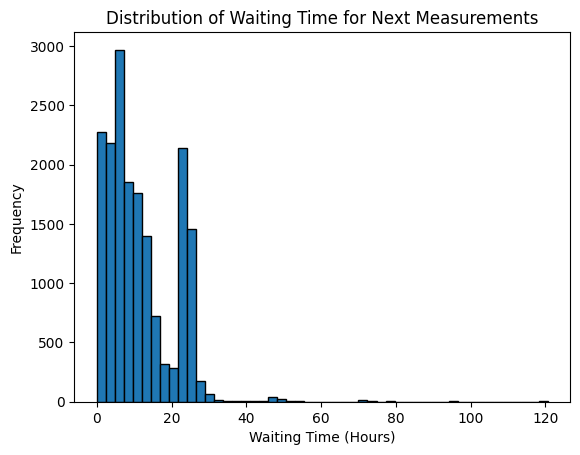

In [132]:
# Descriptive statistics
print(data_cleaned['waiting_time_hours'].describe())

# Histogram
import matplotlib.pyplot as plt

plt.hist(data_cleaned['waiting_time_hours'], bins=50, edgecolor='k')
plt.title('Distribution of Waiting Time for Next Measurements')
plt.xlabel('Waiting Time (Hours)')
plt.ylabel('Frequency')
plt.show()

In [133]:
# Calculate the 90th percentile as a threshold
threshold = data_cleaned['waiting_time_hours'].quantile(0.95)
print(f"The 90th percentile of waiting times is {threshold} hours.")

The 90th percentile of waiting times is 25.033333333333335 hours.


In [134]:
data_cleaned.to_csv('/work/JinStorage/Hyponatremia/MIMIC_4/data_cleaned_2.csv', index=False)

In [3]:
import pandas as pd

prescriptions_df = pd.read_csv('/work/JinStorage/Hyponatremia/MIMIC_4/prescriptions_filtered.csv')
lab_events_df = pd.read_csv('/work/JinStorage/Hyponatremia/MIMIC_4/lab_events_filtered.csv')


subject_id = 10014354
hadm_id = 26486158




In [2]:
filtered_prescriptions = prescriptions_df[(prescriptions_df['subject_id'] == subject_id) & (prescriptions_df['hadm_id'] == hadm_id)]
print("Filtered Prescriptions:")
filtered_prescriptions.head()

Filtered Prescriptions:


subject_id   hadm_id            starttime             stoptime     drug  \
44    10014354  26486158  2148-09-01 22:00:00  2148-09-08 16:00:00  Insulin   
45    10014354  26486158  2148-09-01 22:00:00  2148-09-08 16:00:00  Insulin   
46    10014354  26486158  2148-09-01 22:00:00  2148-09-08 16:00:00  Insulin   
47    10014354  26486158  2148-09-01 22:00:00  2148-09-08 16:00:00  Insulin   
48    10014354  26486158  2148-09-01 22:00:00  2148-09-08 16:00:00  Insulin   

   drug_type         ndc dose_val_rx dose_unit_rx form_val_disp  \
44      MAIN  88222033.0          20         UNIT             1   
45      MAIN  88222033.0          20         UNIT             1   
46      MAIN  88222033.0          20         UNIT             1   
47      MAIN  88222033.0          20         UNIT             1   
48      MAIN  88222033.0          20         UNIT             1   

   form_unit_disp  doses_per_24_hrs route  level_3  duration drug_normalized  
44           VIAL               1.0    SC       28  583200.0         insulin  
45           VIAL               1.0    SC       32   14400.0         insulin  
46           VIAL               1.0    SC       56  918000.0         insulin  
47           VIAL               1.0    SC      122  547200.0         insulin  
48           VIAL               1.0    SC      129  -82800.0         insulin

In [4]:
filtered_lab_events = lab_events_df[(lab_events_df['subject_id'] == subject_id) & (lab_events_df['hadm_id'] == hadm_id)]
print("\nFiltered Lab Events:")
filtered_lab_events.head()


Filtered Lab Events:


subject_id   hadm_id  itemid            charttime  valuenum  \
998     10014354  26486158   51214  2148-08-23 00:00:00    525.00   
999     10014354  26486158   51237  2148-08-23 00:00:00      1.70   
1000    10014354  26486158   51274  2148-08-23 00:00:00     18.20   
1001    10014354  26486158   51275  2148-08-23 00:00:00     40.30   
1002    10014354  26486158   51133  2148-08-23 00:00:00     12.48   

      time_since_reference  
998                    0.0  
999                    0.0  
1000                   0.0  
1001                   0.0  
1002                   0.0